In [7]:
'''Main Body'''

import mpl_toolkits.mplot3d as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.colors as colors
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import cm
from matplotlib.animation import FuncAnimation
import numpy as np
import astropy.io.ascii as ascii 

r_actual = 600790     # Radius of Alpha Cen b in km
r = 1                 # Modelling the radius as a fraction of its total length 

P_rot = 36.2            # Rotation period of Alpha Cen b in days
P_rot_s = P_rot * 86400 # Rotational period in seconds

n_strips = int(input("Please indicate desired number of latitudinal strips: \n"))   # Number of latitudinal strips 
n_lines = n_strips + 5                                                             # Number of lines separating these strips - includes 2 strip-width polar regions
print("Starting trial for", n_strips, "latitudinal strips")

increment = np.pi / (n_lines-1)         # Incremental angle between each latitiude line (radians) (n_lines-1 gives incremental values for strips and counts for 2 strips in polar regions)

standard_z = r * np.sin(increment)  # Standard height of each tile calculated using trig from strip height and angle
standard_area = standard_z**2       # Standard Area of each (square) pixel 

'''Defining arrays for holding information on strip and tile parameters'''
z_proj_arr = []                           # Height of each strip taken parallel to equator 
z_sum = 0
lat_area_arr = [];  tile_areas = []       # Array for areas of latitudinal strips and area of the square tiles making up each strip                         
r_line_arr = [];  r_strip_arr = []        # Radius of latitudinal line at each interval (separating strips) and radius at midpoint of latitudinal strip of area                          
n_tiles_arr =[]                           # No. of tiles in each strip 

theta = np.pi/2                           # Starting angle set at north pole 
lat_phi = (np.pi/2) + (increment/2)       # Mid latitude angle giving centre point of each latitudinal strip
lat_phi_arr = []                          # Storing the mid-lat angles     

polar_tri_arr = []                        # Area of triangular tiles in the polar region  

'''Loop deriving tile numbers per latitudinal strip and in polar regions '''
for i in range(n_lines): 
 
    if i < 2 or i > (n_lines - 3):        # Avoid square tiling the first 2 increments (polar regions)
        theta = theta - increment                 # -> adjust the incremental angles to skip past the poles
        lat_phi = lat_phi - increment
        if i == 1 or i == (n_lines-2):
            lat_phi_arr.append(lat_phi)
            r_strip = r*np.cos(lat_phi)
            r_strip_arr.append(r_strip)
        continue

    z = r - r*np.sin(theta) - z_sum       # Finding height of tiles in current latitudinal strip (through trigonometry of sectors created by theta)
    z_proj_arr.append(z)
    z_sum += z                            # Summing all calculated z values to move with the strips 
    
    r_line = r*np.cos(theta)              # Radius of given latitudinal line 
    r_line_arr.append(r_line)   
    
    if i == 2 or i == (n_lines - 3):     # Combine the 2 uppermost/lowermost strips into a top/bottom circle and divide into triangular tiles
        
        polar_area = np.pi * (r_line**2)                    # Area of circle from a radius of the 3rd line from the pole 
        n_tri_tiles  = int(polar_area / (standard_area/2))  # Divide total area by half of the area of a square tile to give number of tiles 
        arc_angle = (2*np.pi) / n_tri_tiles                 
        area_sector = polar_area / n_tri_tiles              # Area of triangular sector (i.e. with curved base) 
        
        tri_base = 2 * r_line * np.sin(arc_angle/2)         # Deriving the base and height of each triangular tile
        tri_height = r_line * np.cos(arc_angle/2)
        tri_tile_area = 0.5 * tri_base * tri_height         # Deriving the area of each triangular tile
        polar_tri_arr.append(tri_tile_area)
        polar_tile_area = n_tri_tiles * tri_tile_area   
        
    if i > 2 and i < (n_lines - 2):                         # Deriving area and number of tiles per strip inbetween the polar regions 
                                                            #     -> Note: i selected 3 in from top but 2 in from bottom to recover the strip before the penultimate  
        r_strip = r*np.cos(lat_phi)                         # Radius of latitudinal strip at midpoint 
        r_strip_arr.append(r_strip)

        lat_area = 2 * np.pi * r_strip * standard_z         # Deriving the area of the latidutinal strip via circumference x tile height 
        lat_area_arr.append(lat_area)
        
        n_tiles = int(lat_area / standard_area)         # Deriving the number of tiles in each strip through division of total strip area
        n_tiles_arr.append(n_tiles)
        
        lat_phi_arr.append(lat_phi)
    
    theta = theta - increment                           # Incremental movement down the lines & strips
    lat_phi = lat_phi - increment
      
total_stellar_area = np.sum(lat_area_arr) + (2*polar_area)     # Total surface area of the sphere constructed from tiles (for comparison to perfect spherical surface area of 4*pi)
print('Total stellar surface area = ', total_stellar_area)
print('Percentage polar area = ', ((2*polar_area)/total_stellar_area)*100)     # Percentage of the surface area making up polar regions (accuracy testing)

theta = np.pi/2    # Resetting latitudinal angle to north pole
phi = 0            # Angle subtended from centre to current tile (2 pi / n_tiles)

x_arr = []; y_arr = []; z_arr = []   # To store values of 3D coordinate system

def cartesian(theta, phi):         # Function to convert tile coordinates from a spherical to cartesian system 
        x = r * np.sin(phi) * np.cos(theta)
        y = r * np.cos(phi) * np.cos(theta)
        z = r * np.sin(theta)
                                           
        x_arr.append(x)                 
        y_arr.append(y)                        
        z_arr.append(z)
        return(x,y) 

'''Series of loops to move leading vector between strips and then corresponding tiles on each strip to gather cartesian positions of each tile for plotting 
                Firstly considers the triangulated polar regions(first/last 2 strip's worth of area) and then each lateral strip '''

n_it = n_lines + 1           # +1 allows for the double step needed to overlap the line connecting the bottom of the northern triangular pole and the top of the first latitudinal strip
offset = 0                   # Offset prevents starting tile of each strip alligning, which would create a seam down the sphere affecting future lightcurve results 
offset_counter = 0

for i in range(n_it):     
    
    if i == 0 or i == (n_it-1):      #Assigning only a z value to the poles 
        x = 0; y = 0
        z = r
        if i==(n_it-1):
            z = -z                   # Differentiating between north and south pole
        theta = theta - increment
        x_arr.append(x)
        y_arr.append(y)
        z_arr.append(z)
        continue
    
    if i ==1 or i == (n_it-2):   #Ignoring the middle strip of the poles (considered together with the first)
        theta = theta - increment 
        continue 

    if i==2 or i == (n_it-3):      #Polar region boundary
        phi = offset 
        phi_inc = (2*np.pi) / n_tri_tiles
        
        for k in range(n_tri_tiles + 1):        # +1 connects the last point back to the first
            cartesian(theta, phi)
            phi += phi_inc 
      
        if i==2:
            continue 
        if i==(n_it-3):                        # Skipping the line separating the bottom polar region from strips (which was already counted) 
            theta = theta - increment
            continue            
        
    for j in range(2):    
        
        phi = offset
        phi_inc = (2*np.pi) / n_tiles_arr[(i-3)]   # Incremental angle between each tile
                                                   #          -> 'i-3' lines up the arrays of n_it used for 'i' (size:57) and n_tiles_arr (size: 51)
                                                   #                      -> e.g. first i value through this loop will be 3, therefore selecting the 0th element of the tiles array 
        for k in range(n_tiles_arr[(i-3)] + 1):       # +1 connects the last point back to the first
            a = cartesian(theta, phi)
            x_long = np.arcsin(a[0]/(r*np.cos(theta)))
            y_long = np.arccos(a[1]/(r*np.cos(theta)))
            #print(theta, phi,x_long,y_long,a[0],a[1])
           
            phi += phi_inc 
      
        if j == 0:
            theta = theta - increment 
        if j == 1:
            theta = theta
            
    offset += (5*np.pi)/180                       # Offsets the starting point for tiles from the same each strip, preventing periodic spikes in intensity patterns  

'''Spherical test plot of latitudinal strips constructing the sphere'''
'''ax = plt.figure().add_subplot(projection='3d')
ax.plot(x_arr, y_arr, z_arr,  label='star', color='darkorange')
ax.set_xlabel('$X$', fontsize=10)
ax.set_ylabel('$Y$', fontsize=10)'''

x_mid = []; x_mid_plot = []; y_mid = []; y_mid_plot = []; z_mid = []; z_mid_plot = [] 

hide_angle_list = []                              # Stores angle between tile normal vector and earth vector for each tile  
intensity_arr = []                                # Used to store the light intensity of each tile
lightcurve_tot_arr = []; gauss_tile_peak = []     # Stores values of projected area*intensity for whole rotation and for each phase respectively

sum_tiles = 0         # Sum of all total tiles previous to the current tile
hide_angle = 0        # Angle between the Earth vector and tile normal vector

x_norms = []; y_norms = []; z_norms = []    # Arrays to store the normal component of the tile in x/y/z direction
x_proj = []; y_proj =[]                     # Values of x and y for 2d projection stored here
 
def projection (x,y,z,phase,inclination):     
  # Function to convert coordinates of tiles (stored in 4D arrays, for all four corners, as 3 (x,y,z) coordinates) into 2D projection (x,y) coordinates
    X = (x*np.sin(phase)) + (y*np.cos(phase))
    Y = ((-x*np.cos(phase)) + (y*np.sin(phase)))*np.cos(inclination) + z*np.sin(inclination)

    x_proj.append(X)     # Plotting arrays used to make 2D projection of tiles 
    y_proj.append(Y)
    return(X,Y)

def normal (x_av,y_av,z_av):
  # Function to derive the unit normal vector from the radius vector at that point (since a spherical approximation) 
    mag = np.sqrt((x_av**2) + (y_av**2) + (z_av**2))
    '''Note: This method to calculate the normal vector for each tile comes from the perfect spherical approximation 
             of the sample star, and hence, will breakdown for distorted stars '''
    x_norm = x_av / mag;  x_norms.append(x_norm)   # Finding the unit vector and storing component in directions 
    y_norm = y_av / mag;  y_norms.append(y_norm)
    z_norm = z_av / mag;  z_norms.append(z_norm)
    

def allignment (norm_x,norm_y,norm_z):
    # Hidden routine - dot product between Earth vector (observer) and normal to the tiles 
    e_dot_n = (e_x * norm_x) + (e_y * norm_y) + (e_z * norm_z)      # Scalar product between Earth.Normal for each tile

    mag_n = np.sqrt((norm_x * norm_x) + (norm_y * norm_y) + (norm_z * norm_z)) # Deriving magnitudes of each 
    mag_e = np.sqrt((e_x * e_x) + (e_y * e_y) + (e_z * e_z)) 
    
    hide_angle = np.arccos(e_dot_n / (mag_e * mag_n))     # Equation for the dot product rearranged for angle between the two vectors
    hide_angle_list.append(hide_angle)

def poly_area(x,y):                                      # Function to derive the area of indinvidual visable tiles from projected coordinates
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))    
 
def intensity(hidden_angle, c, initial):
    # Quadratic limb darkening function to scale the brightness of each tile by its relative position on stellar face (using angle to the observer)
    u = np.cos(hidden_angle)
    i = initial - c*(1 - u) - (c*((1 - u)**2))
    intensity_arr.append(i)
    return i

cmap = plt.cm.get_cmap('gist_heat')    # Mapping the heat map colour scheme to visualize the limb darkening 
norm = colors.Normalize(vmin=0, vmax=1)
ld_const = 0.5         # Limb darkening constant 

n_phase = 81           #no. of days in sample   #int(input("Number of samples taken in phases of rotation: "))    # Number of phases captured from rotation of the star through 360 deg 
phase_int = 1/36.6     # (1/n_phase)  
phase_phi = 0 

inc_input = int(input("Degrees of inclination from rotation axis through poles: "))
inc = (inc_input / 180)*np.pi               # Inclination angle of the viewpoint (Earth vector direction) from the rotation axis of star 
                                                     #  -> 90 deg is parallel to the plane of the equator

'Deriving active region area - spot surrounded by plage'
# First the area of spot 
perc_coverage_spot = float(input("Please state total percentage cover of spot area: "))
active_area_spot = (total_stellar_area/100)*perc_coverage_spot        # Working out active area coverage via percentage of the surface 
active_tile_num_spot = round(active_area_spot/standard_area)     # Number of tiles in that area 
spot_r = np.sqrt((active_tile_num_spot*standard_area)/np.pi)# Radius of a circle with that surface area coverage
spot_area = np.pi * (spot_r * spot_r)

# latitude & longitude of spot:
lat_spot = (70 * np.pi / 180) # latitude of active region on alpha cen b ~70 degrees according to Dumusque 2014 paper
long_spot = np.pi/2 + np.pi/12           # Starting longitude 
# centre co-ords of spot:
spot_x = r * np.sin(long_spot) * np.cos(lat_spot)
spot_y = r * np.cos(long_spot) * np.cos(lat_spot)
spot_z = r * np.sin(lat_spot)   
 
# Next the area of plage
perc_coverage_plage = float(input("Total percentage cover of plage area: "))
active_area_plage = (total_stellar_area/100)*perc_coverage_plage   # Working out active area coverage via percentage of the surface 
active_tile_num_plage = round(active_area_plage/standard_area)     # Number of tiles in that area 
plage_r = np.sqrt((active_tile_num_plage*standard_area)/np.pi)     # Radius of a circle with that surface area coverage
plage_x = spot_x; plage_y = spot_y; plage_z = spot_z    # Both plage and spot centred on same lat and long
       
vec_i = 0            # Index for current tile number (all tiles)
vis_i = 0            # Index for current visable tile number (only those on near side)

coords = []                         # Gathers coordinates for the corners of the tiles
x_values = []; y_values = []        # Takes x&y values from coords and stores for plotting
tot_vis_area = []                   # Total visable area constructed from the sum of the individual tile areas 

'Gaussian parameters'
int_lb = 1                                                  # km/s  -> intrinsic line broadening 
sigma_int = int_lb                                          # Value remains the same for uncertainty
inst_lb = 1.5                                               # km/s  -> instrumental line broadening (HARPS) Note: this is a FWHM value
sigma_inst = inst_lb/(2*np.sqrt(2*np.log(2)))               #       -> Hence this is the conversion to a unviersal uncertainty value
broadening = np.sqrt((sigma_int **2) + (sigma_inst **2))    # km/s  Total width component due to broadening

'line profile arrays'
rad_vel_arr = [] 
gaussian_arr = []; gaussian_integral_arr = []; total_phase_gaussian_arr = []; total_rot_gaussian_arr = []    
active_gaussian_arr = []; inactive_gaussian_arr = []
rv_values = np.linspace(-10,10,1000)    # Standardised list of rv values between -10 and +10 km/s, binned at 1m/s  
av = []   # Average (centre) Radial velocity array storing centre value for each phase 

'Forming array of observed days for Alpha Cen b data '
data = ascii.read('alpha_cen_active_data.dat')        #NOTE: This is loading in sampled HARPS data (as used in the Thompson et al paper) for observations of Alpha Cen b
day = data['jdb']-55278    # Converting days from the Julian calendar to starting from 0 
e = 0                      # Counter for data set days
phase = []                 # Array for storing the associated data point in terms of fraction (phase) of total rotation
real_phase_gaussian = []   # Array for storing the phases in line with the days of observations for Alpha Cen B (Thompson et al. 2017)


for h in range(n_phase+1): 

    e_theta = 2 * np.pi * (phase_phi)       # e_theta describes stage of rotation on the axis and hence, a fraction of 2*pi         
    
    e_x = (np.cos(e_theta) * np.sin(inc))    # Dividing the earth vector between cartesian direction components for the dot product
    e_y = -(np.sin(e_theta) * np.sin(inc))
    e_z = np.cos(inc)

    offset = 0                               # Resetting the value used for offsetting tiles from centre seem

    fig = plt.figure()                       # Required for visulisation of star (see bottom of code)
    ax = fig.add_subplot(111)
    
    for i in range(n_lines):
    
        if i < 2 or i > (n_lines - 3):     # Ignoring the top and bottom 2 'dummy lines'
            continue 
        
        if i == 2:          # Northern pole
            long_theta_inc = (2*np.pi)/n_tri_tiles          # Incremental longitude moves it by 1 whole tile 
            long_theta_value = ((2*np.pi)/(2*n_tri_tiles))   # Longitude measure set at the middle of the first tile  
                                                              #      -> Note: Triangular pole tiling starts at the same place at the top, which is along the 0deg longitude line
            for j in range(n_tri_tiles):

                x2 = x_arr[0], x_arr[j+1], x_arr[j+2], x_arr[0]      # Traces out the polar triangular sectors, all of which share the polar centre point 
                y2 = y_arr[0], y_arr[j+1], y_arr[j+2], y_arr[0]
                z2 = z_arr[0], z_arr[j+1], z_arr[j+2], z_arr[0]

                x_av = (x_arr[0] + x_arr[j+1] + x_arr[j+2]) / 3     # Locating the midpoint of the tiles
                y_av = (y_arr[0] + y_arr[j+1] + y_arr[j+2]) / 3
                z_av = (z_arr[0] + z_arr[j+1] + z_arr[j+2]) / 3

                normal(x_av,y_av,z_av)           
                allignment(x_norms[vec_i], y_norms[vec_i], z_norms[vec_i])    # Deducing the angle subtended between the normal vector of the tile with the Earth vector
                init_bright = 1             #Setting the initial relative intensity of the tile to 1, before assigning it to a active region & applying limb darkening 
                
                if hide_angle_list[vec_i] < (np.pi/2):
                    vis_i +=1
                    for k in range(4):          #Loop to plot projection X & Y values for the tiles and assigning the normal vector for the tile to the all of coordinates 
                        coords.append(projection (x2[k],y2[k],z2[k],e_theta,inc)) 
                        x_values.append(coords[k][0])               
                        y_values.append(coords[k][1]) 
                    I = intensity(hide_angle_list[vec_i], ld_const,init_bright)       # Assigning the tile its brightness via limb darkening function 
                    plt.plot(x_values, y_values , color = 'black', linewidth = 2)     # Adding the projected X & Y values of the tile to the plot
                    #plt.plot(x_values, y_values , color = cmap(I), linewidth = 1)    # Setting the tile edges to the same heatmap colour as the tile
                    plt.fill(x_values, y_values, color = cmap(I))
                    tile_areas.append(poly_area(x_values,y_values))        # Derving the area of the projected tile and storing to work out total
                    projarea_int = poly_area(x_values, y_values) * I       # Multiplying the visable area of tile by its intensity for lightcurve (relative contribution to total image)
                    x_values = []; y_values = []; coords = []
                    
                    vel = (2 * np.pi * r_strip_arr[0]*r_actual) / P_rot_s                        # Strip rotational velocity (note:  r_strip_arr[0]*r_actual converts radius from fractional value to actual value)
                    rad_vel = vel * (np.cos(long_theta_value - (h*phase_int*2*np.pi)))* np.cos(lat_phi_arr[0]) * np.sin(inc)   # Radial velocity of individual tile 
                    rad_vel_arr.append(rad_vel)
                    
                    g_v =  0.5 * (np.exp(- 0.5 * (((rv_values - rad_vel)**2) / (broadening **2))))   # Constructing the gaussian profile
                    g_v = (-1*g_v)+1
                 
                    gaussian_profile = (g_v *(projarea_int))    # Multiplying gaussian profile by its amplitude contribution 
                    
                    gaussian_arr.append(gaussian_profile) 
                
                vec_i += 1  

                long_theta_value += long_theta_inc
            
            sum_tiles = n_tri_tiles + 2        # Advancing on from the polar regions (25 triangles = 26 base points + 1 top pole point)

        if i > 2 and i < (n_lines - 2):

            long_theta_inc = (2*np.pi)/n_tiles_arr[i-3]          # Incremental longitude moves it by 1 whole tile 
            long_theta_value = ((2*np.pi)/(2*n_tiles_arr[i-3])) + offset   # Longitude measure set at the middle of the first tile - offset added to assign longitude despite offset tiles (0 for first strip)
            
            for j in range(n_tiles_arr[i-3]):
                #Tracing a square tile as 5 coordinates (stored in a 5D array tracing 4 corners and back to starting corner) from the coordinates laid out in the previous arrays  
                x2 = x_arr[j+(sum_tiles)], x_arr[j+(sum_tiles)+1], x_arr[j+(sum_tiles)+(n_tiles_arr[i-3]+2)], x_arr[j+(sum_tiles)+(n_tiles_arr[i-3]+1)], x_arr[j+(sum_tiles)]
                y2 = y_arr[j+(sum_tiles)], y_arr[j+(sum_tiles)+1], y_arr[j+(sum_tiles)+(n_tiles_arr[i-3]+2)], y_arr[j+(sum_tiles)+(n_tiles_arr[i-3]+1)], y_arr[j+(sum_tiles)]
                z2 = z_arr[j+(sum_tiles)], z_arr[j+(sum_tiles)+1], z_arr[j+(sum_tiles)+(n_tiles_arr[i-3]+2)], z_arr[j+(sum_tiles)+(n_tiles_arr[i-3]+1)], z_arr[j+(sum_tiles)]    

                # finding mid points of constructed square tile
                x_av = (x_arr[j+(sum_tiles)] + x_arr[j+1+(sum_tiles)] + x_arr[j+(sum_tiles)+(n_tiles_arr[i-3]+1)] + x_arr[j+(sum_tiles)+(n_tiles_arr[i-3]+2)]) / 4
                y_av = (y_arr[j+(sum_tiles)] + y_arr[j+1+(sum_tiles)] + y_arr[j+(sum_tiles)+(n_tiles_arr[i-3]+1)] + y_arr[j+(sum_tiles)+(n_tiles_arr[i-3]+2)]) / 4
                z_av = (z_arr[j+(sum_tiles)] + z_arr[j+1+(sum_tiles)] + z_arr[j+(sum_tiles)+(n_tiles_arr[i-3]+1)] + z_arr[j+(sum_tiles)+(n_tiles_arr[i-3]+2)]) / 4 
                
                normal(x_av,y_av,z_av)           
                allignment(x_norms[vec_i], y_norms[vec_i], z_norms[vec_i])    # Deducing the angle subtended between the normal vector of the tile with the Earth vector
                init_bright = 1        
                redshift = 0
                
                if long_theta_value >= (2*np.pi):
                    remainder = long_theta_value - (2*np.pi)  
                    long_theta_value = 0 + remainder 
                
                
                '''Adjusting the tile properties for active regions'''
                if ((((x_av - plage_x)*(x_av - plage_x)) + ((y_av - plage_y)*(y_av - plage_y)) + ((z_av - plage_z)*(z_av - plage_z))) < (plage_r * plage_r)):
                    init_bright = 1.25         # Brightness of a plage region of 200K difference 
                    redshift = 0.3
                if ((((x_av - spot_x)*(x_av - spot_x)) + ((y_av - spot_y)*(y_av - spot_y)) + ((z_av - spot_z)*(z_av - spot_z))) < (spot_r * spot_r)):
                    init_bright = 0.1    # Brightness of a spot region corresponds to 1000k difference 
                    redshift = 0       # Resetting the convective blueshift effect as negligible for spots 

                if hide_angle_list[vec_i] < (np.pi/2):
                    vis_i +=1
                    for k in range(5):                               #Loop to plot projection X & Y values for the tiles and assigning the normal vector for the tile to the all of coordinates 
                        coords.append(projection (x2[k],y2[k],z2[k],e_theta,inc))
                        x_values.append(coords[k][0])                 
                        y_values.append(coords[k][1])
                    I = intensity(hide_angle_list[vec_i], ld_const,init_bright)
                    plt.plot(x_values, y_values , color = 'black', linewidth = 1)     # Adding the projected X & Y values of the tile to the plot
                    #plt.plot(x_values, y_values , color = cmap(I), linewidth = 1)    # This plots the lines in the same colour as the heat map, hence use either this line or the line previous, not both
                    plt.fill(x_values, y_values, color = cmap(I))
                    
                    
                    tile_areas.append(poly_area(x_values,y_values))   # Derving the area of the projected tile and storing to work out total
                    projarea_int = poly_area(x_values,y_values) * I
                
                    x_values = []; y_values = []; coords = []
                    
                    vel = (2 * np.pi * (r_strip_arr[i-2])*r_actual) / P_rot_s    # Calculating the actual velocity of the tiles in strip (note r_strip indexed as i-2 instead of i-3 as the first value of r_strip is for polar triangles) 
                    rad_vel = vel * (np.cos(long_theta_value - (h*phase_int*2*np.pi))) * np.cos(lat_phi_arr[i-2]) * np.sin(inc) + redshift # Radial velocity of individual tile
                    rad_vel_arr.append(rad_vel)        
                    g_v =  0.5 * (np.exp(- 0.5 * (((rv_values - rad_vel)**2) / (broadening **2))))   # Constructing the gaussian profile
                    g_v = (-1*g_v)+1
                
                    gaussian_profile = (g_v *(projarea_int))    # Multiplying gaussian profile by its amplitude contribution 
                    gaussian_arr.append(gaussian_profile)    
                    
                vec_i += 1              
                
                x_mid_plot.append(x_av); y_mid_plot.append(y_av); z_mid_plot.append(z_av)

                if j == (n_tiles_arr[i-3]-1):
                    sum_tiles += 2*(n_tiles_arr[i-3]+1)                 # Moving on to the 1st coordinate of the next strip after plotting the last of current strip 
                
                long_theta_value += long_theta_inc     
            offset += (5*np.pi)/180
            
        if i == (n_lines - 3):     # Southern pole
            
            long_theta_inc = (2*np.pi)/n_tri_tiles          # Incremental longitude moves it by 1 whole tile 
            long_theta_value = ((2*np.pi)/(2*n_tri_tiles)) + ((2+n_strips)*(5*np.pi/180))   # Longitude measure set at the middle of the first tile  
                                                                                            #      -> Note: Triangular pole tiling starts at the same place top and bottom, which is along the 0deg longitude line
            index = len(hide_angle_list)
            a = len(x_arr) - 1                            # 'a' value selects polar cap coordinate
            b = int(len(x_arr)) - (n_tri_tiles + 2)      # Setting x_array value selector to the first triangular southern pole coord
            b2 = len(x_mid_plot) - (n_tri_tiles)        # Storing the index number of first southern pole triangle tile (for midpoint plotting)

            for j in range(n_tri_tiles):

                x2 = x_arr[a], x_arr[j+b], x_arr[j+b+1], x_arr[a]      # Traces out the polar triangular sectors, all of which share the polar centre point 
                y2 = y_arr[a], y_arr[j+b], y_arr[j+b+1], y_arr[a]
                z2 = z_arr[a], z_arr[j+b], z_arr[j+b+1], z_arr[a]

                x_av = (x_arr[a] + x_arr[j+b] + x_arr[j+b+1]) / 3     
                y_av = (y_arr[a] + y_arr[j+b] + y_arr[j+b+1]) / 3
                z_av = (z_arr[a] + z_arr[j+b] + z_arr[j+b+1]) / 3  

                normal(x_av,y_av,z_av)           
                allignment(x_norms[vec_i], y_norms[vec_i], z_norms[vec_i])    # Deducing the angle subtended between the normal vector of the tile with the Earth vector
                init_bright = 1           #Setting the initial relative intensity of the tile to 1, before assigning it as a spot
                
                if long_theta_value >= (2*np.pi):
                    remainder = long_theta_value - (2*np.pi)  
                    long_theta_value = 0 + remainder     
                
                if hide_angle_list[vec_i] < (np.pi/2):
                    vis_i +=1
                    for k in range(4):                               # Loop to plot projection X & Y values for the tiles and assigning the normal vector for the tile to the all of coordinates 
                        coords.append(projection (x2[k],y2[k],z2[k],e_theta,inc))
                        x_values.append(coords[k][0])
                        y_values.append(coords[k][1])
                    I = intensity(hide_angle_list[vec_i], ld_const,init_bright)
                    plt.plot(x_values, y_values , color = 'black', linewidth = 1)     # Adding the projected X & Y values of the tile to the plot
                    #plt.plot(x_values, y_values , color = cmap(I), linewidth = 1)   
                    plt.fill(x_values, y_values, color = cmap(I))
                    tile_areas.append(poly_area(x_values,y_values))
                    projarea_int = poly_area(x_values,y_values) * I
                    x_values = []; y_values = []; coords = []
                    
                    vel = (2 * np.pi * (r_strip_arr[(len(r_strip_arr)-1)]*r_actual)) / P_rot_s
                    rad_vel = vel * (np.cos(long_theta_value - (h*phase_int*2*np.pi))) * np.cos(lat_phi_arr[(len(lat_phi_arr)-1)]) * np.sin(inc) 
                    rad_vel_arr.append(rad_vel)
                    g_v =  0.5 * (np.exp(- 0.5 * (((rv_values - rad_vel)**2) / (broadening **2))))   # Constructing the gaussian profile
                    g_v = (-1*g_v)+1
                    
                    gaussian_profile = (g_v *(projarea_int))    # Multiplying gaussian profile by its amplitude contribution 
                    gaussian_arr.append(gaussian_profile) 
                    
                    
                vec_i += 1  
               
                long_theta_value += long_theta_inc
       
    'Deriving Total Gaussian line profile'
    for i in range(len(rv_values)):
        gaussian_integral_arr = []
        for j in range(vis_i):
            gaussian_integral_arr.append(gaussian_arr[j][i])            # Creating an array to extract the amplitude of the profiles at each 1m/s interval of rv range 
        total_phase_gaussian_arr.append(np.sum(gaussian_integral_arr))  # Total light profile for current phase by storing the total amplitude (intensity) at each rv value
    
    if h == int(day[e]):                                                # Adding to a separate array storing the profiles for the phases corresponding to the data sampling of Alpha Cen B (Thompson et al. 2017)
        real_phase_gaussian.append(total_phase_gaussian_arr)
        phase.append((e/36.6))                                          # Alpha Cen b has a 36.6 day rotation period, hence this appends a list of values in terms of phase of rotation period
        e+=1
        
    total_rot_gaussian_arr.append(total_phase_gaussian_arr)             # Appending the current phase array to a permanent array to track the full rotation 
    
    tile_areas = []; intensity_arr = []; gauss_tile_peak = []
    rad_vel_arr = []; gaussian_arr = []; total_phase_gaussian_arr = []
    x_mid_plot = []; y_mid_plot = []; z_mid_plot = [] 
    vis_i = 0
    
    'Visualisation of star'
    '''plt.style.use('dark_background')
    ax.set_aspect('equal')
    ax.set_title('2D stellar projection', size = 20)
    fig.set_size_inches(15,15)
    ax.set_xlabel('X', size = 15)
    ax.set_ylabel('Y', size = 15)
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax) 
    cbar.set_label(label = 'Intensity of Light', size =20)
    #fig_save_value +=1
    #plt.savefig('Inclined star view phase.' + str(fig_save_value) + '.png')
    plt.show()
    plt.clf()'''
    
    print(h,'/',n_phase)
    phase_phi += phase_int

'''Lightcurve plot - Total visable area vs rotation phase'''
'''x_phase = np.arange(0,1+phase_int,phase_int)
plt.figure(figsize=(12,8))
plt.plot(x_phase, tot_vis_area)
plt.xlabel('Phase of rotation', size = 15)
plt.ylabel('Total visable area (units) ', size = 15)   
yy, locs = plt.yticks()
ll = ['%.5f' % a for a in yy]
plt.yticks(yy, ll)   
plt.title('Lightcurve showing total visable area vs rotation phase', size = 15)
plt.show()
'''



 

Please indicate desired number of latitudinal strips: 
61
Starting trial for 61 latitudinal strips
Total stellar surface area =  12.562581606814408
Percentage polar area =  0.4658873206919266
Degrees of inclination from rotation axis through poles: 45
Please state total percentage cover of spot area: 0
Total percentage cover of plage area: 0
0 / 81
1 / 81
2 / 81
3 / 81
4 / 81
5 / 81
6 / 81
7 / 81
8 / 81
9 / 81
10 / 81
11 / 81
12 / 81
13 / 81
14 / 81
15 / 81
16 / 81
17 / 81
18 / 81
19 / 81
20 / 81
21 / 81
22 / 81
23 / 81
24 / 81
25 / 81
26 / 81
27 / 81
28 / 81
29 / 81
30 / 81
31 / 81
32 / 81
33 / 81
34 / 81
35 / 81
36 / 81
37 / 81
38 / 81
39 / 81
40 / 81
41 / 81
42 / 81
43 / 81
44 / 81
45 / 81
46 / 81
47 / 81
48 / 81
49 / 81
50 / 81
51 / 81
52 / 81
53 / 81
54 / 81
55 / 81
56 / 81
57 / 81
58 / 81
59 / 81
60 / 81
61 / 81
62 / 81
63 / 81
64 / 81
65 / 81
66 / 81
67 / 81
68 / 81
69 / 81
70 / 81
71 / 81
72 / 81
73 / 81
74 / 81
75 / 81
76 / 81
77 / 81
78 / 81
79 / 81
80 / 81
81 / 81


"ax = plt.figure().add_subplot(projection='3d')\nax.plot(x_arr, y_arr, z_arr,  label='star', color='darkorange')\nax.set_xlabel('$X$', fontsize=10)\nax.set_ylabel('$Y$', fontsize=10)"

In [9]:
'''This cell is used to create normalised arrays for comparing gaussian profile arrays from a sample with an active region
   against one without an active region (the inactive sample)
        -> To use, first run the previous cell for ideal strip number but with no active region in place - this is the inactive sample 
            Hence, hash out the active array storage below and run 
        -> then run a trial of previous cell with the active region in place on the model, before hashing out the inactive array storage below 
           and storing the gaussian arrays for the active sample
        -> Note: both of these arrays are then normalised, so that their continuum values all are raised to 1, this is important for the 
           during the division of the two array components to create a reference profile '''


#active_gaussian_full = total_rot_gaussian_arr 
inactive_gaussian_full = total_rot_gaussian_arr
#active_gaussian_selective = real_phase_gaussian
inactive_gaussian_selective = real_phase_gaussian

inactive_gaussian_full_norm =[]; active_gaussian_selective_norm =[]; inactive_gaussian_selective_norm =[]; active_gaussian_full_norm = []

'Process of normalisation for the phase profiles'
'    -> Full describes 81 phases taken each day, selective describes those corresponding to the selective 48 days trialed by HARPS'

e = 0
for i in range(len(inactive_gaussian_full)):
    normalisation_const_active = active_gaussian_full[i][0]
    normalisation_const_inactive = inactive_gaussian_full[i][0]
    
    inactive_gaussian_full_norm.append(inactive_gaussian_full[i]/normalisation_const_inactive)
    active_gaussian_full_norm.append(active_gaussian_full[i]/normalisation_const_active)
    
    if i == int(day[e]):
        normalisation_const_active = active_gaussian_selective[e][0]
        normalisation_const_inactive = inactive_gaussian_selective[e][0]  

        inactive_gaussian_selective_norm.append(inactive_gaussian_selective[e]/normalisation_const_inactive)
        active_gaussian_selective_norm.append(active_gaussian_selective[e]/normalisation_const_active)
        e+=1
    
 


0.0035734676079930416 -0.6906906906906904 30 1
[ 0.03987385 -0.70323966  2.36913602  0.96369942]


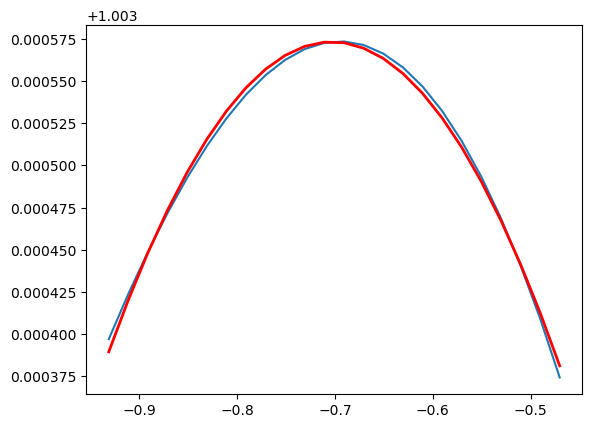

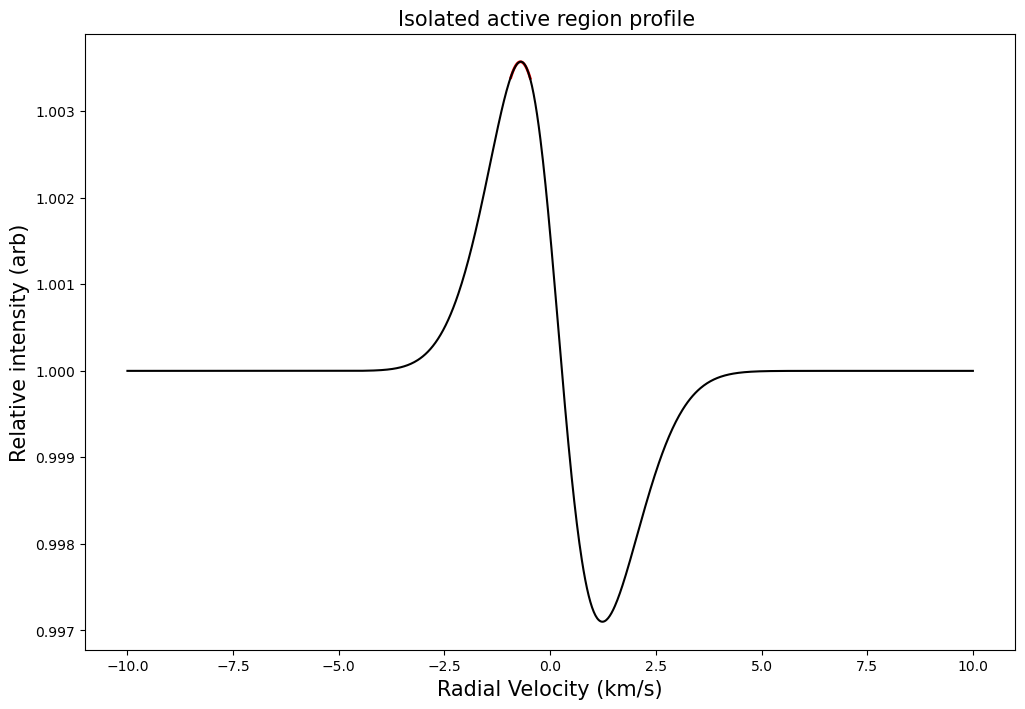

0.0034786946194358404 -0.6706706706706704 30 1
[ 0.00120999 -0.66971339  0.40389562  1.00226944]


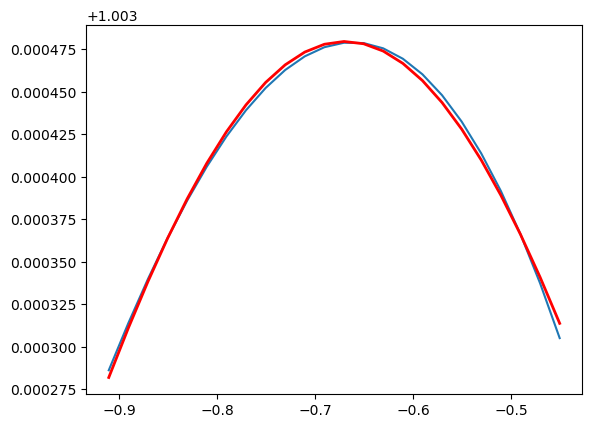

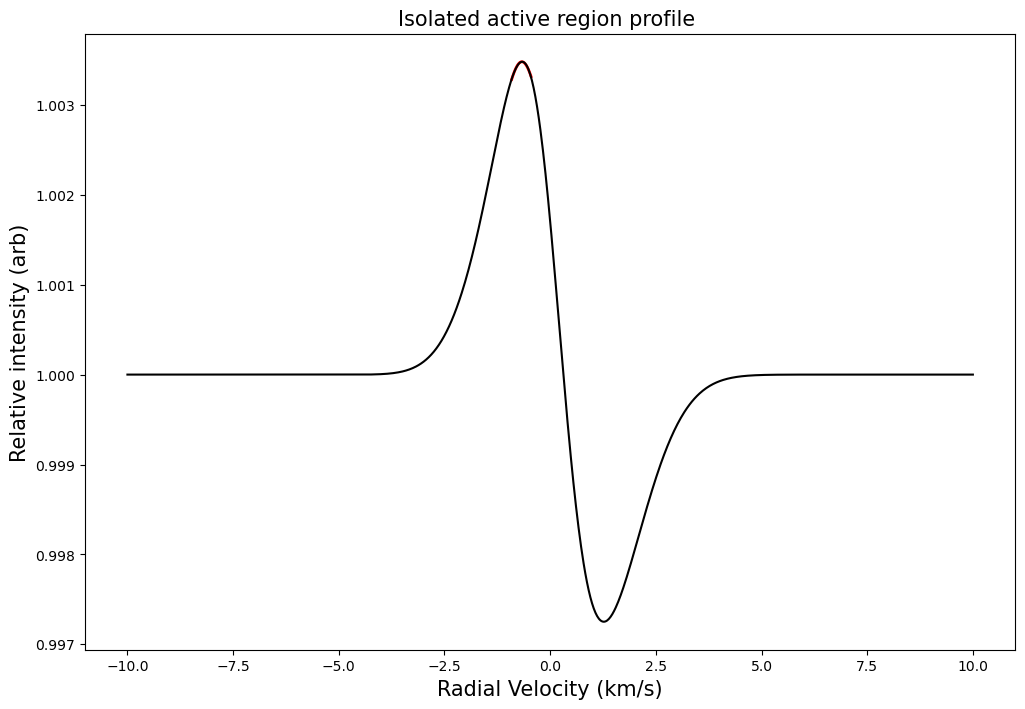

0.003347417706034417 -0.6306306306306304 30 1
[ 0.0016147  -0.63374205  0.4751506   1.00173304]


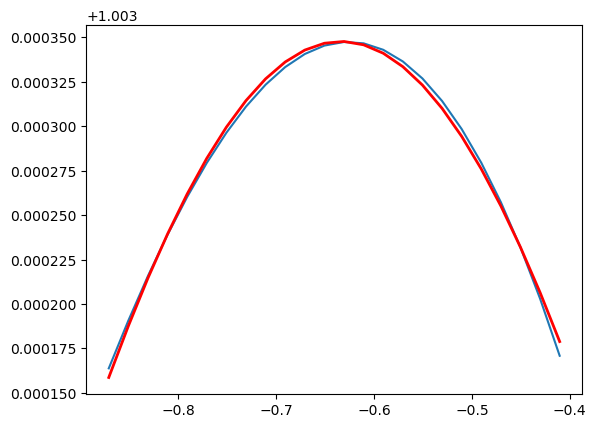

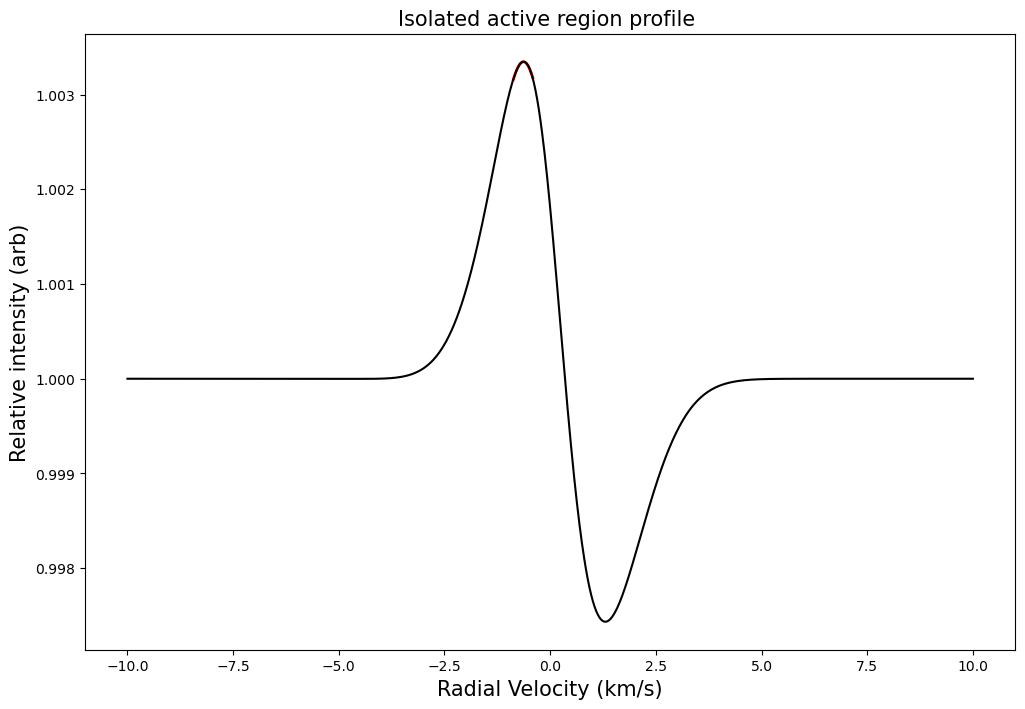

0.003187125355160081 -0.5905905905905904 30 1
[ 0.00183199 -0.59516425  0.5154348   1.00135532]


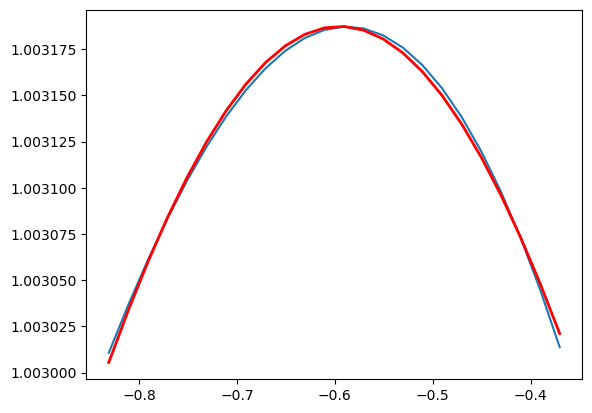

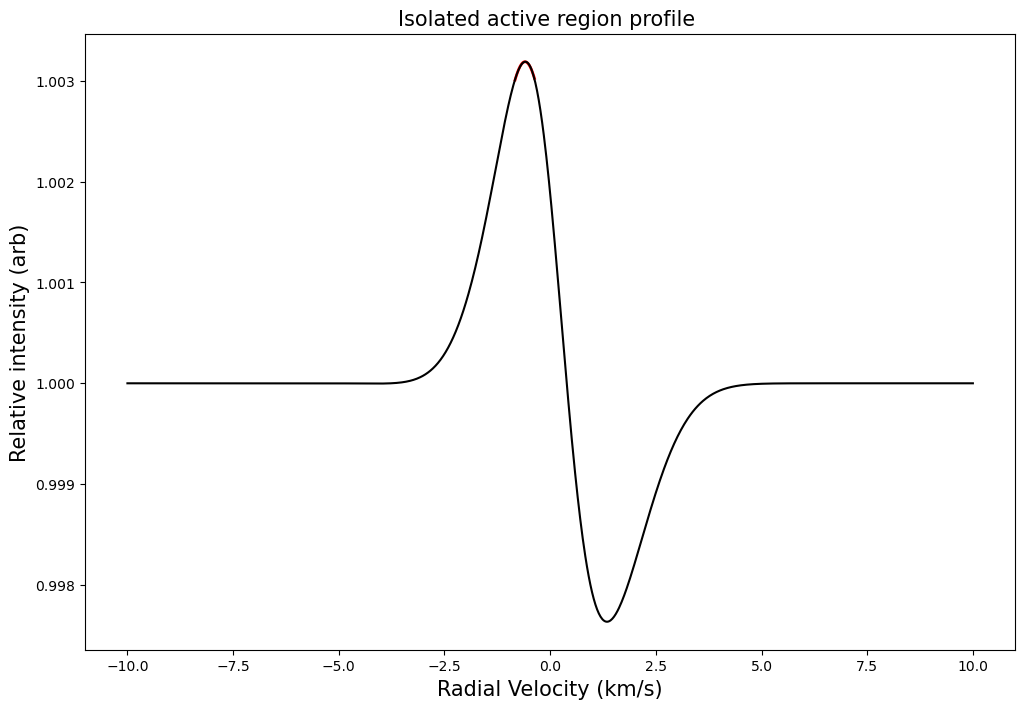

0.003006407128096411 -0.5505505505505504 30 1
[ 0.00227651 -0.55637184  0.58794935  1.00072997]


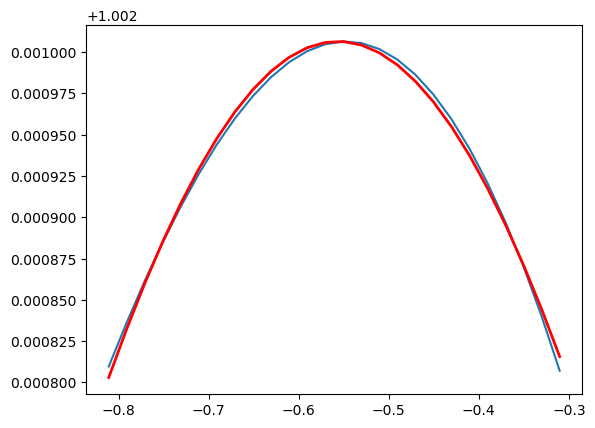

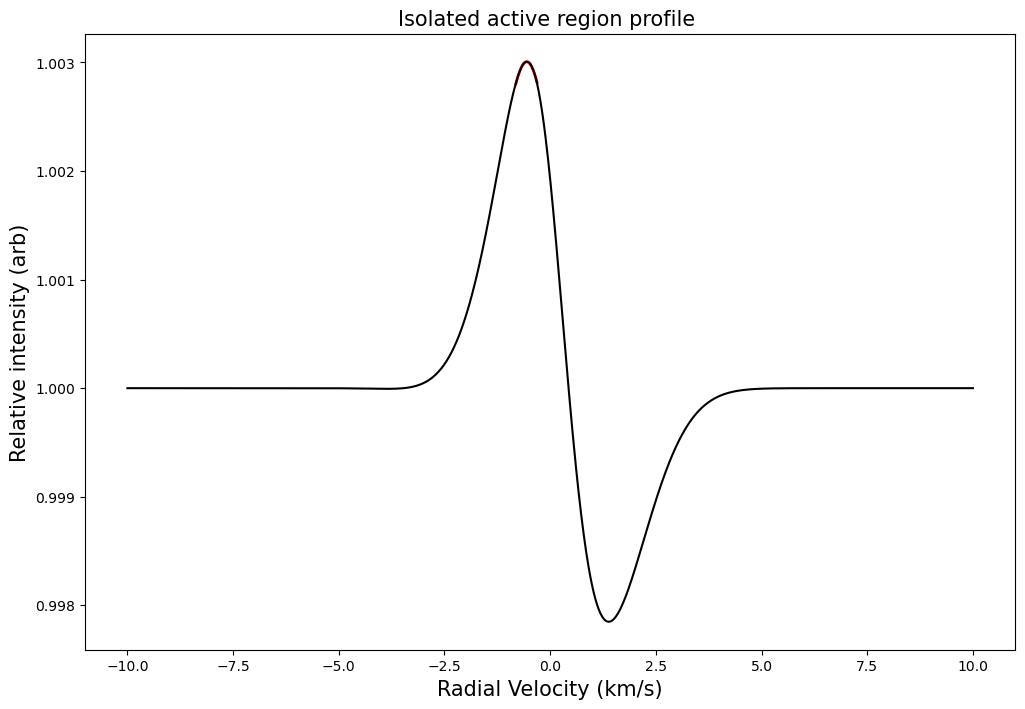

0.0028134085797990593 -0.5105105105105103 30 1
[ 0.00204305 -0.51592408  0.56959128  1.00077046]


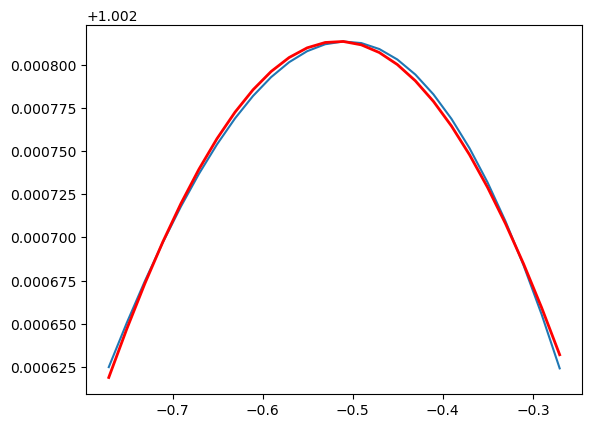

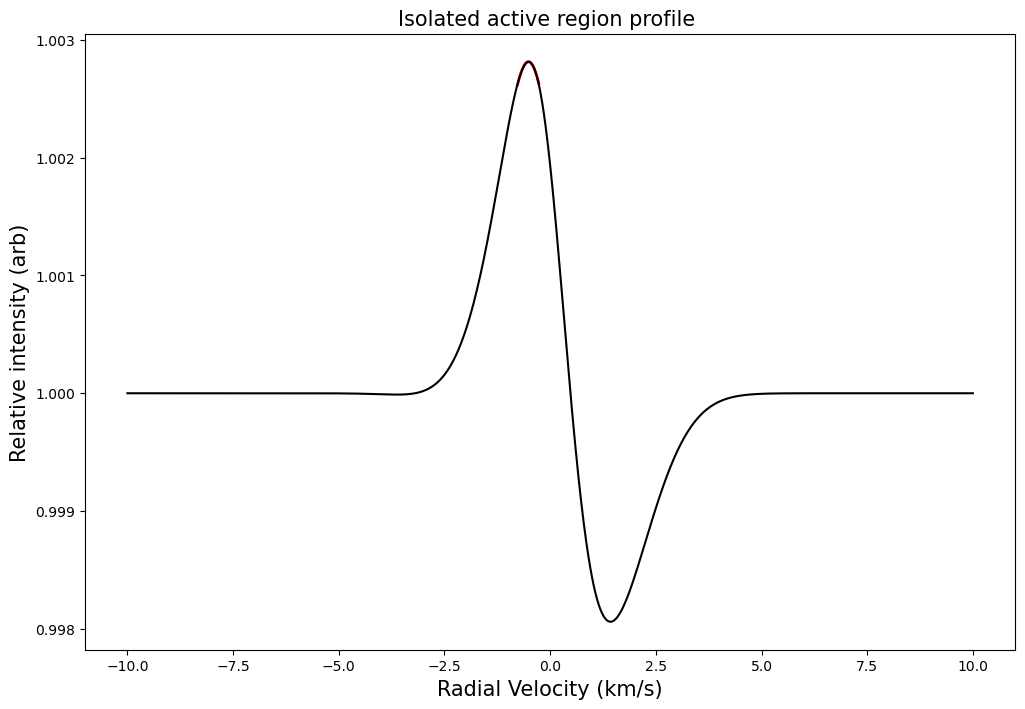

0.002615247175875801 -0.4704704704704703 30 1
[ 0.0021162  -0.4766945   0.59654255  1.00049909]


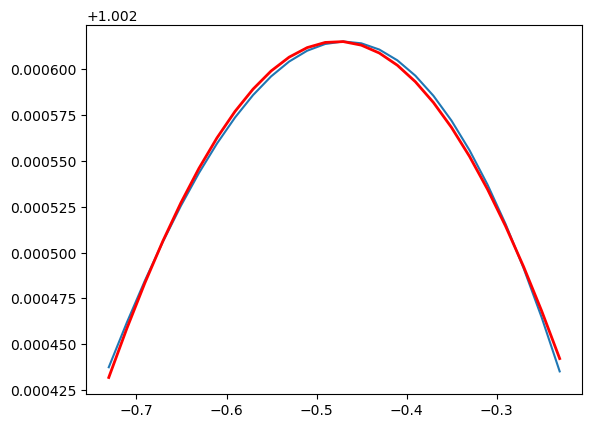

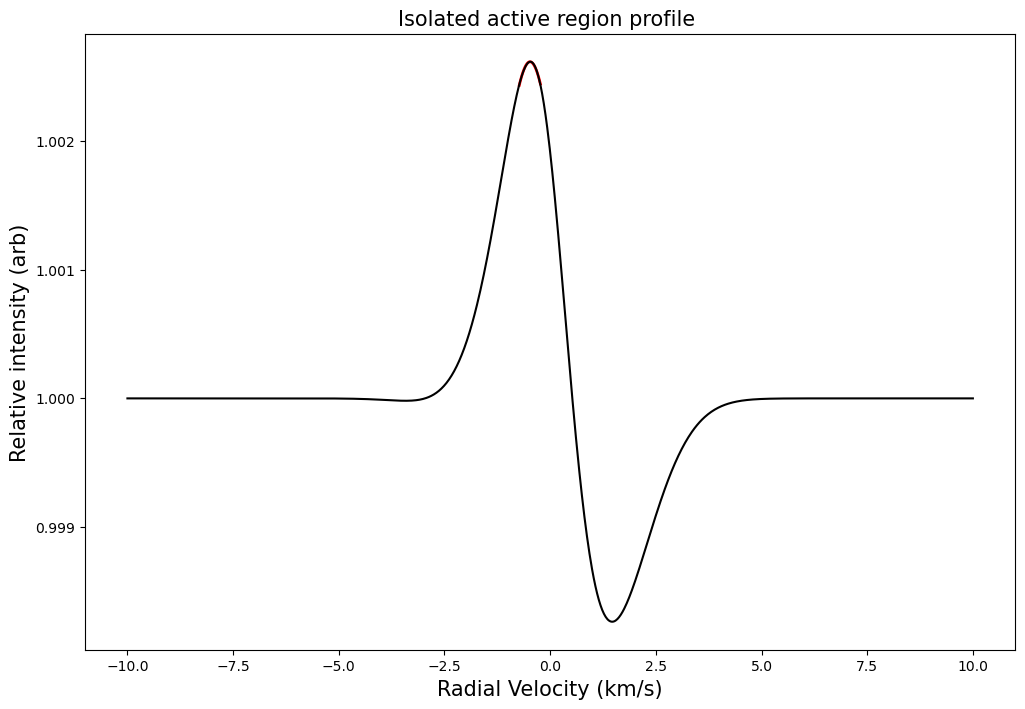

0.0024176528579691325 -0.4304304304304303 30 1
[ 0.00126004 -0.44056139  0.46975652  1.00115796]


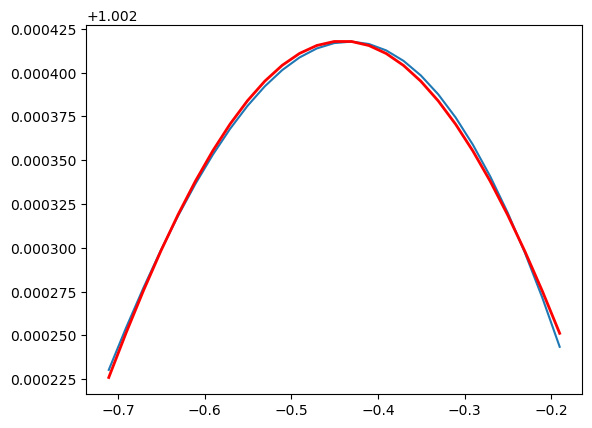

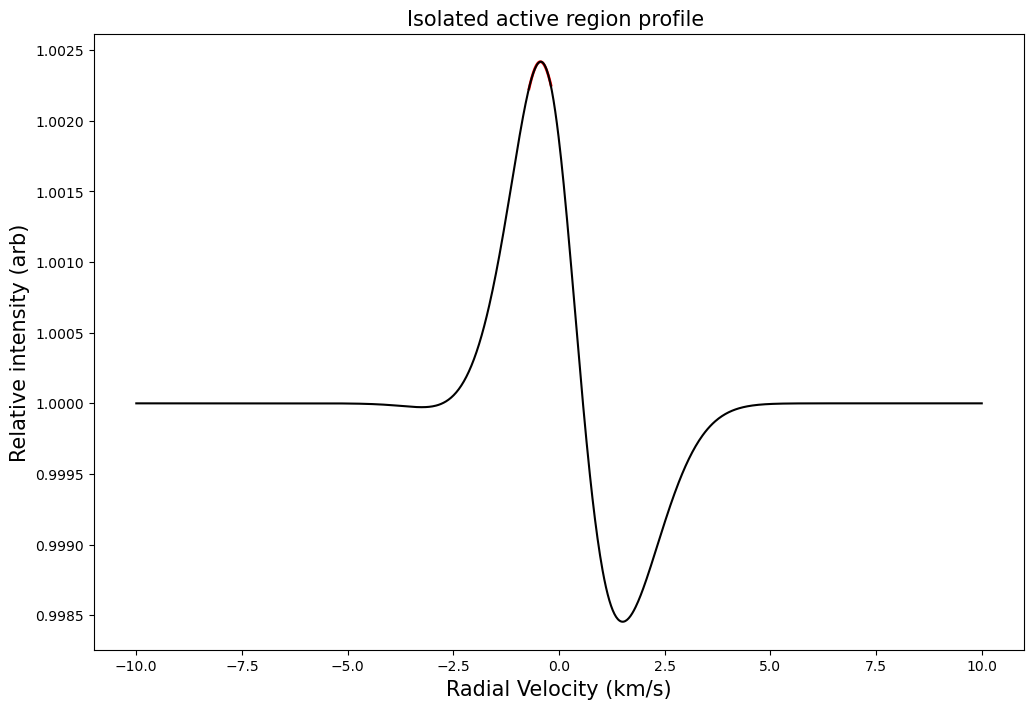

0.0022248686663752792 -0.41041041041041026 30 1
[ 0.00116183 -0.40904382 -0.46602668  1.00106364]


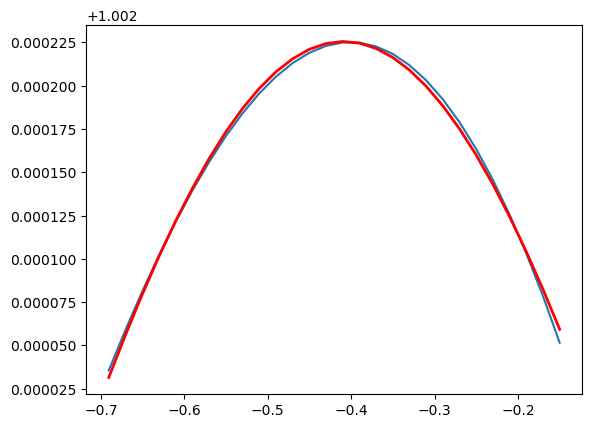

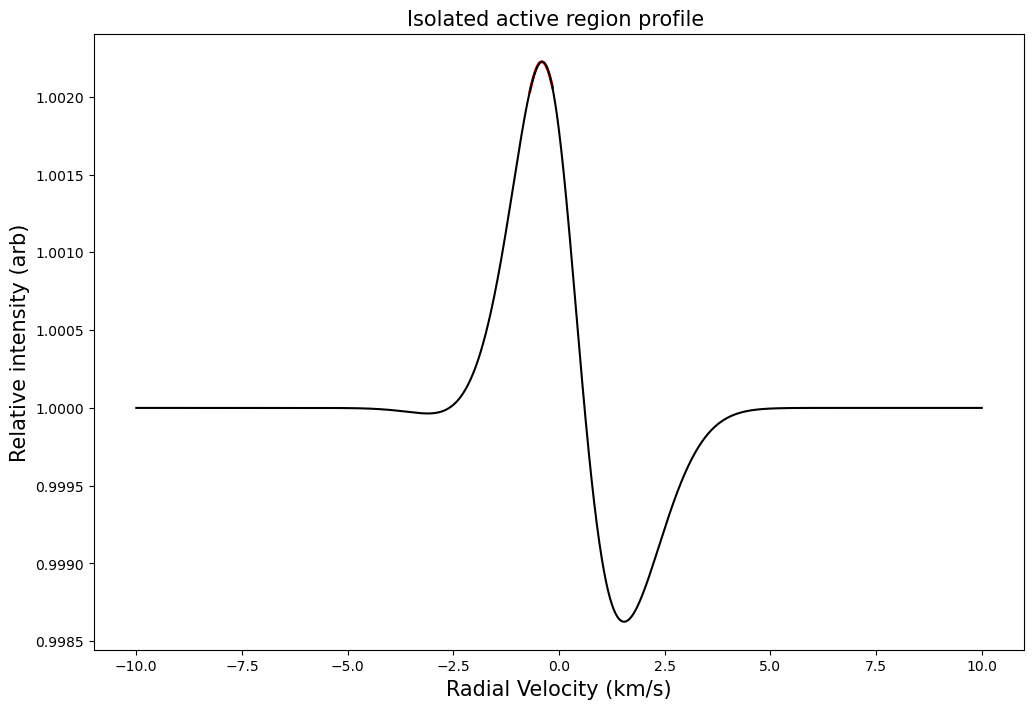

0.0020408462038461472 -0.37037037037037024 30 1
[ 0.00148956 -0.38387421  0.55192352  1.0005515 ]


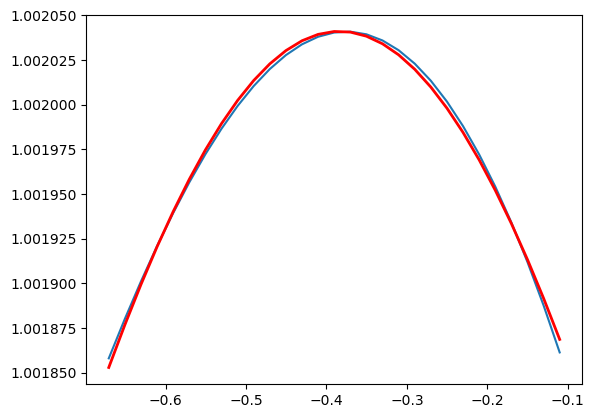

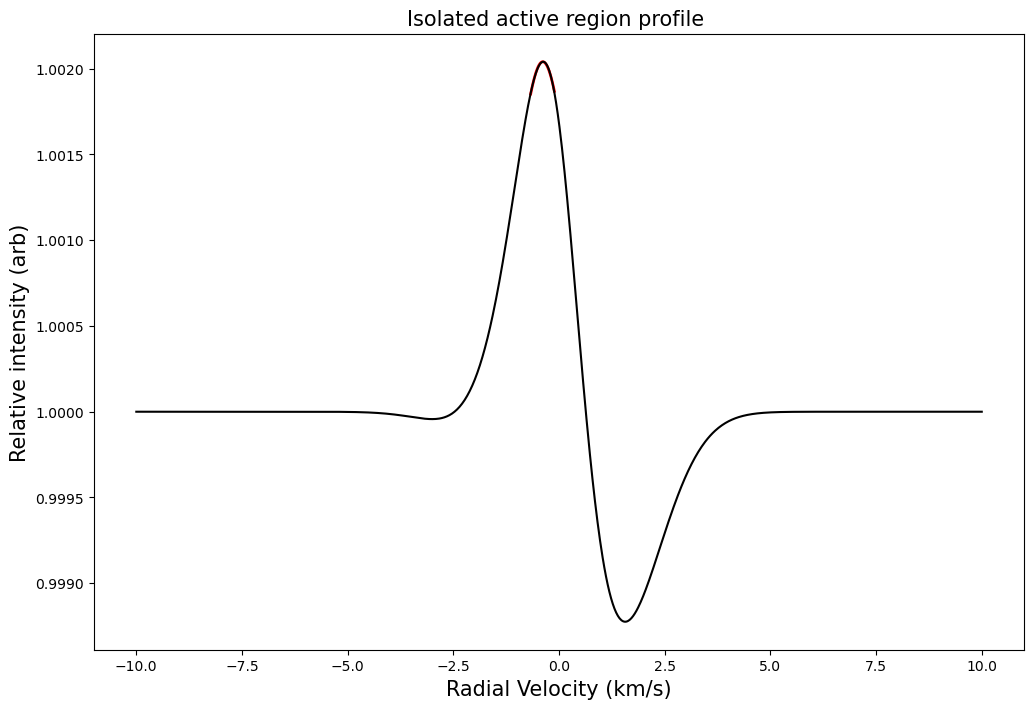

0.0018677306309349273 -0.3503503503503502 30 1
[ 0.00180075 -0.36665263  0.63491212  1.00006708]


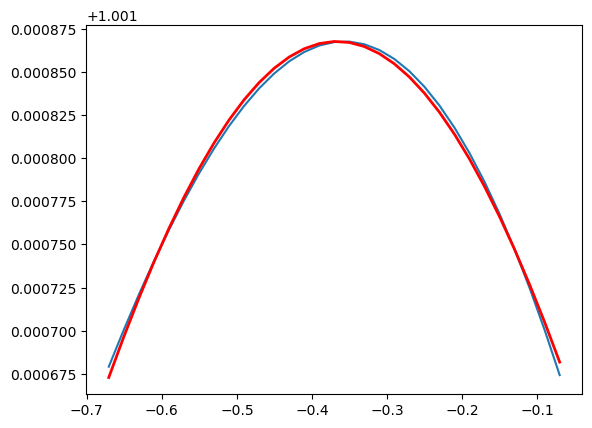

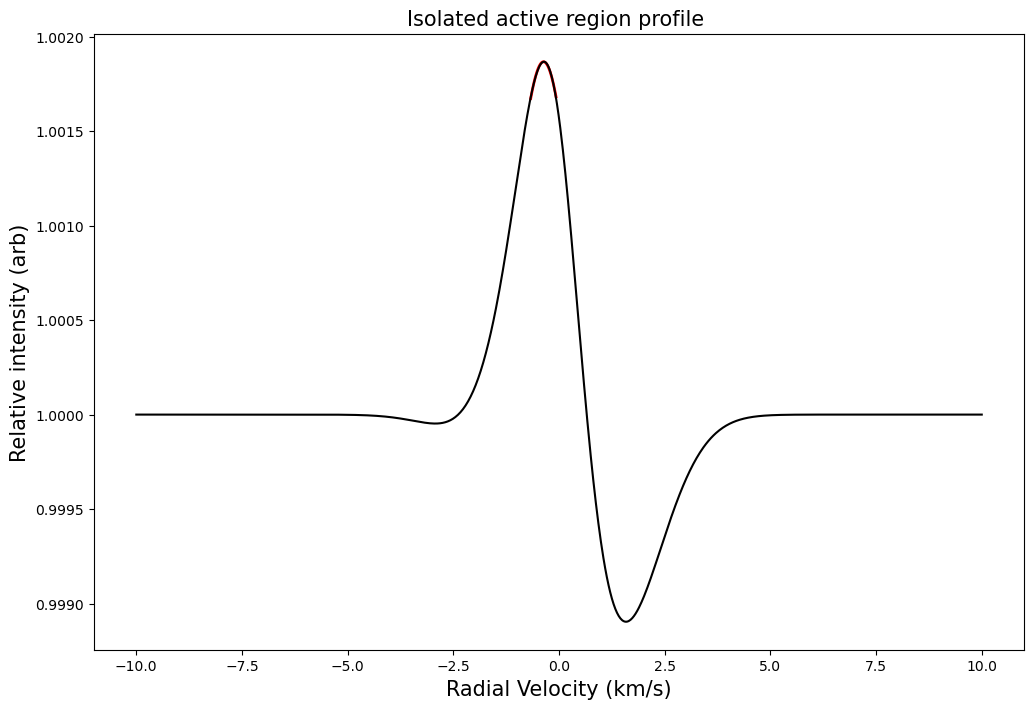

0.001708312359330666 -0.3503503503503502 30 1
[ 0.00179127 -0.35741505  0.66145955  0.999917  ]


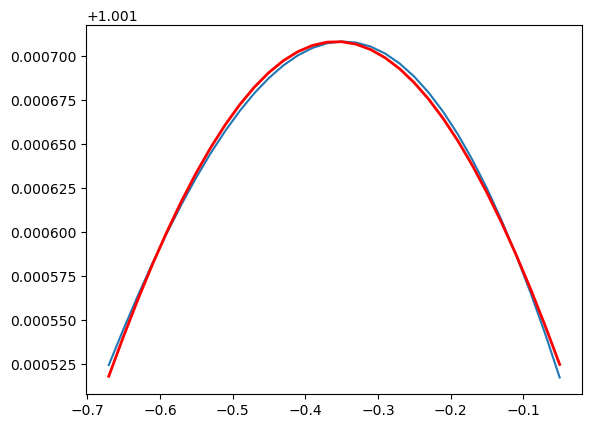

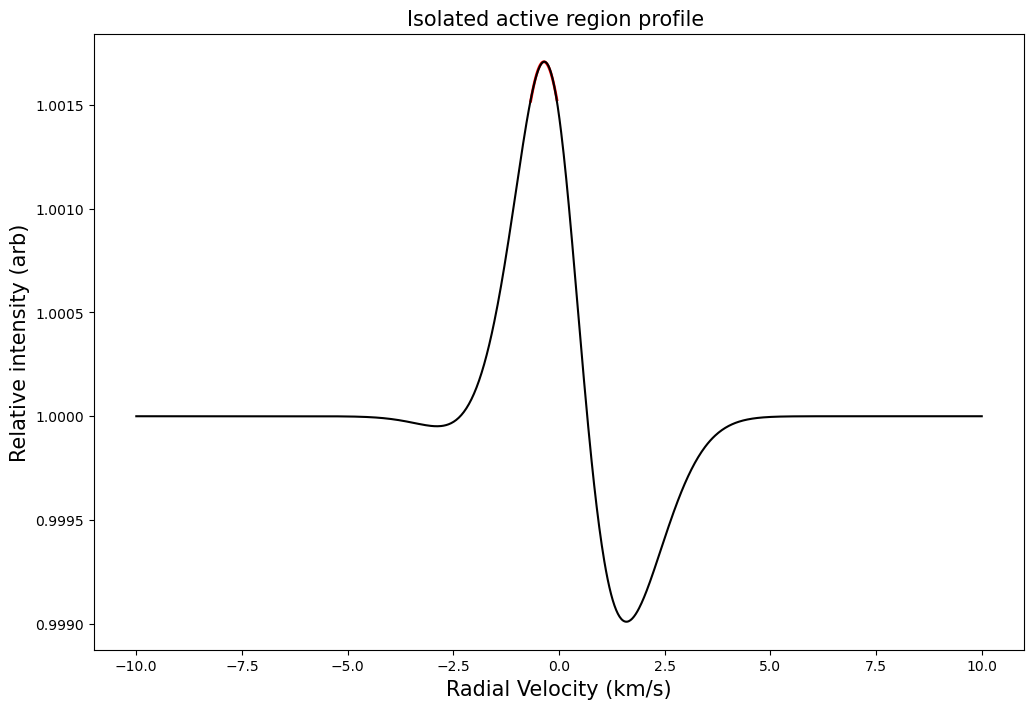

0.0015647371477596206 -0.3503503503503502 30 1
[ 0.00179909 -0.35819571  0.69355977  0.99976555]


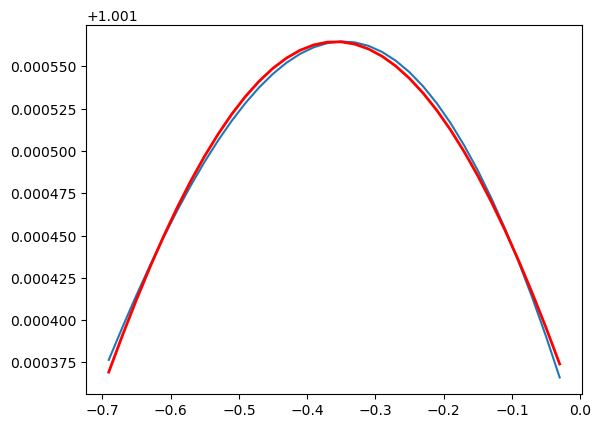

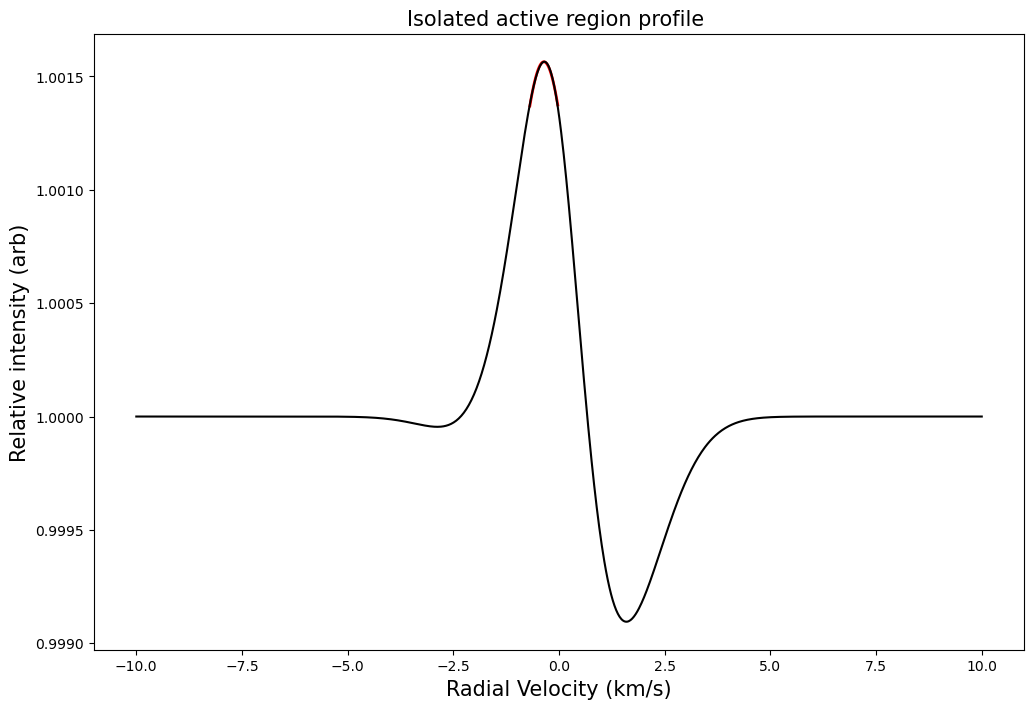

0.0014394098448149428 -0.3503503503503502 30 1
[ 0.00164498 -0.36798501  0.69243722  0.99979437]


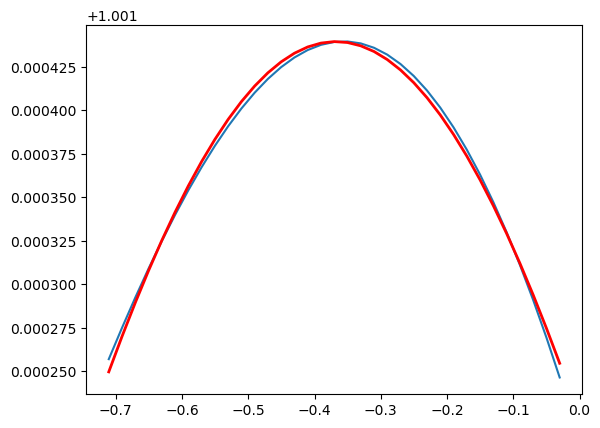

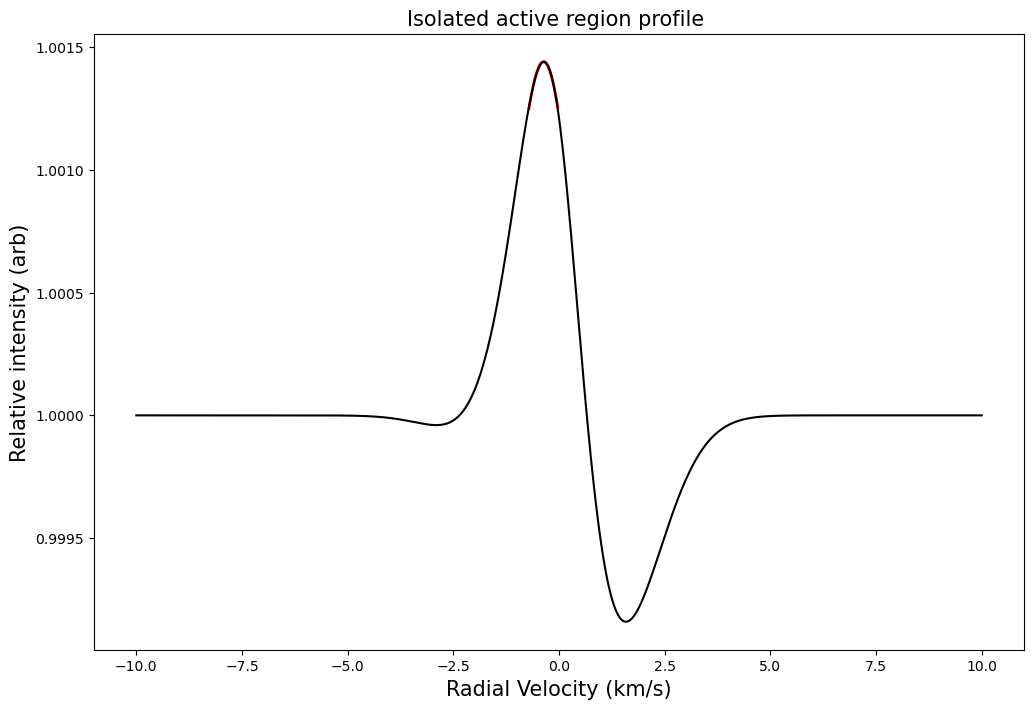

0.0013346327783496648 -0.37037037037037024 30 1
[ 0.00154988 -0.38779014  0.70099277  0.99978462]


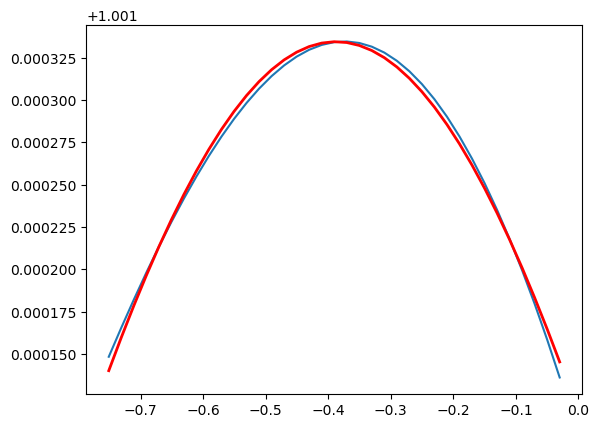

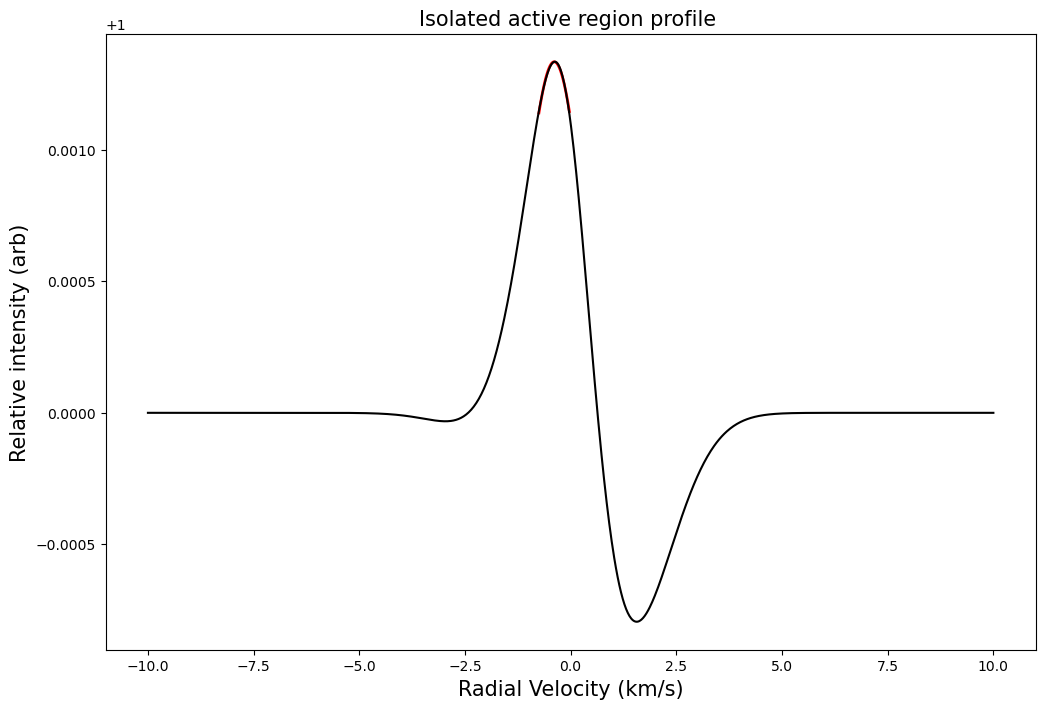

0.0012520652690559686 -0.39039039039039025 30 1
[ 0.00124357 -0.41515702  0.6493105   1.00000859]


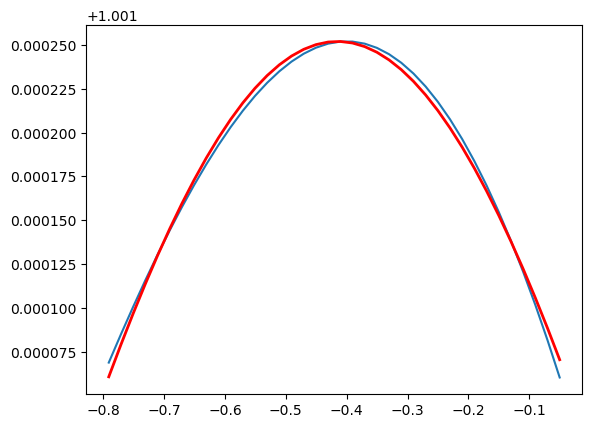

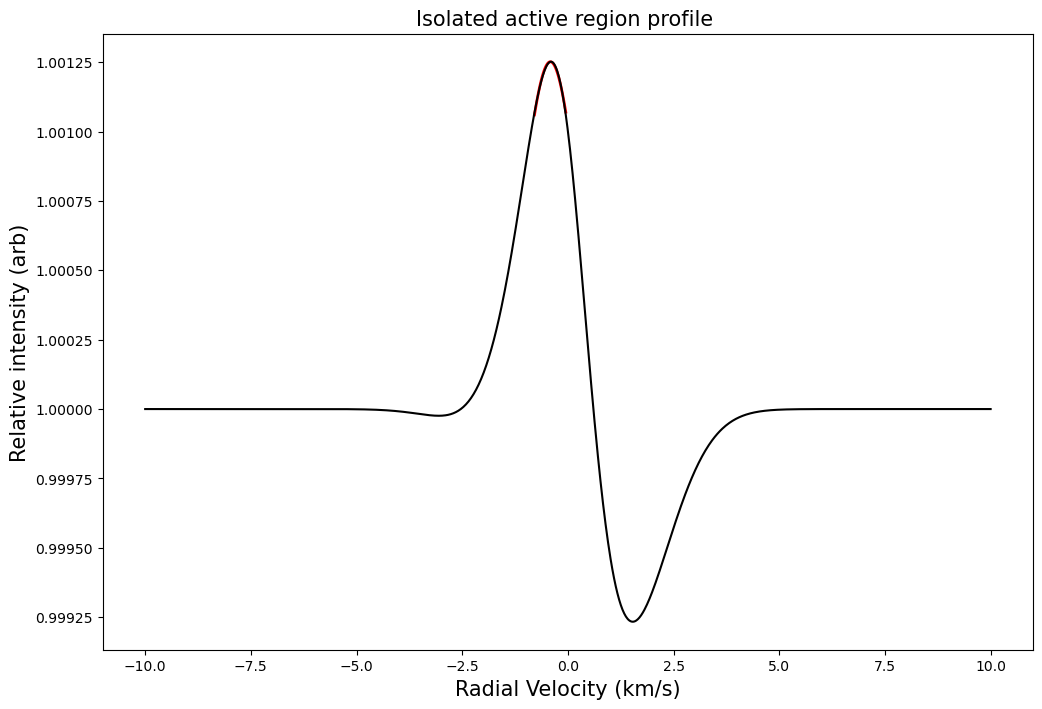

0.0011936183726866112 -0.4304304304304303 30 1
[ 9.49973796e-04 -4.49920026e-01  5.80989159e-01  1.00024382e+00]


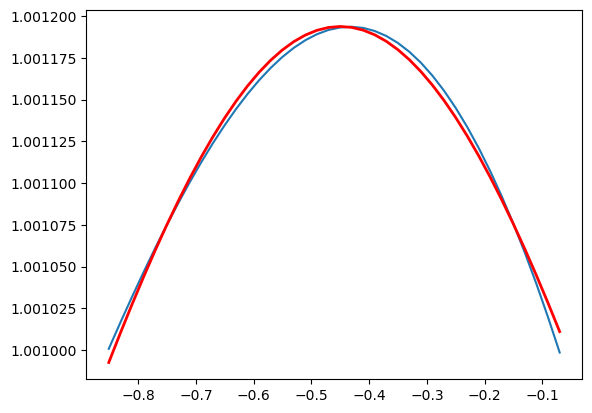

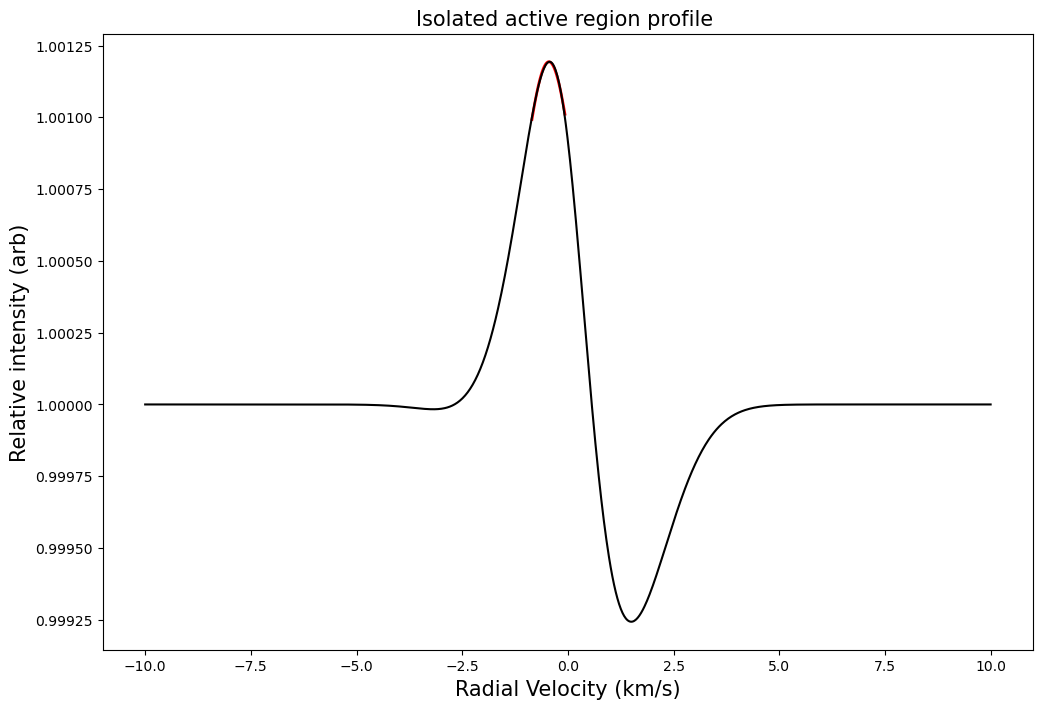

0.0011600646682690119 -0.4704704704704703 30 1
[ 8.38093412e-04 -4.87920218e-01  5.56474270e-01  1.00032223e+00]


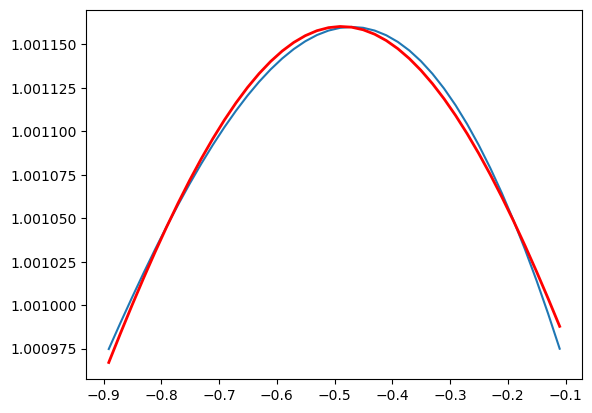

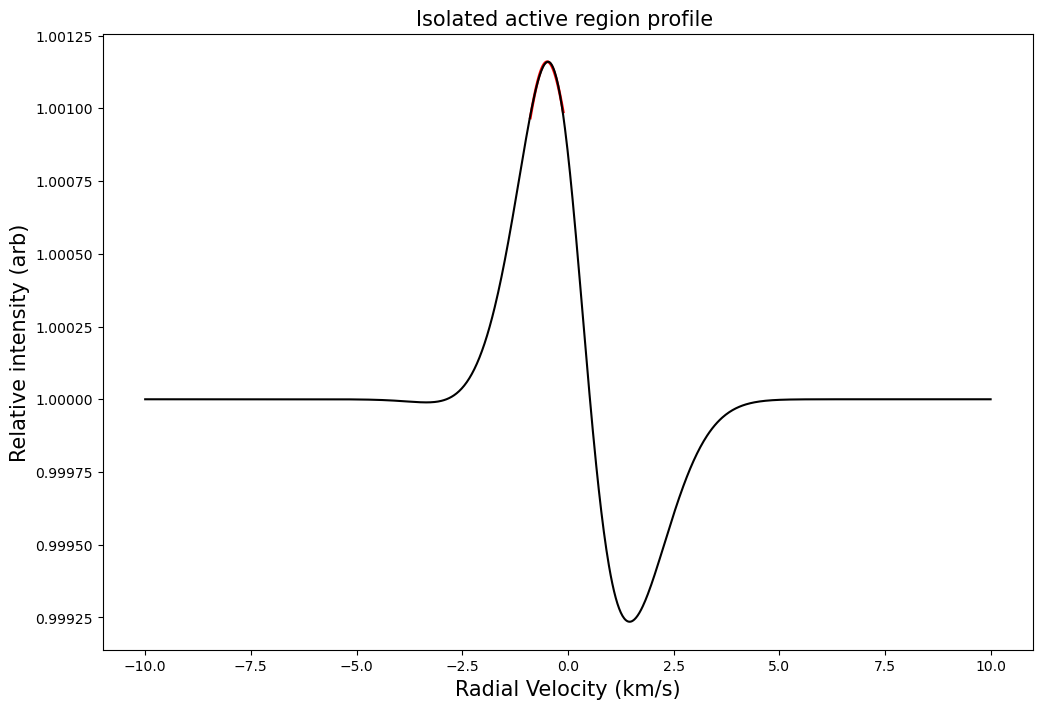

0.001152496929533342 -0.5105105105105103 30 1
[ 6.43352137e-04 -5.28736825e-01  4.87360664e-01  1.00050979e+00]


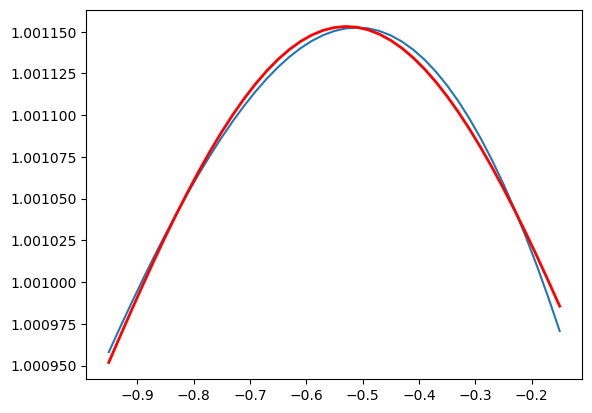

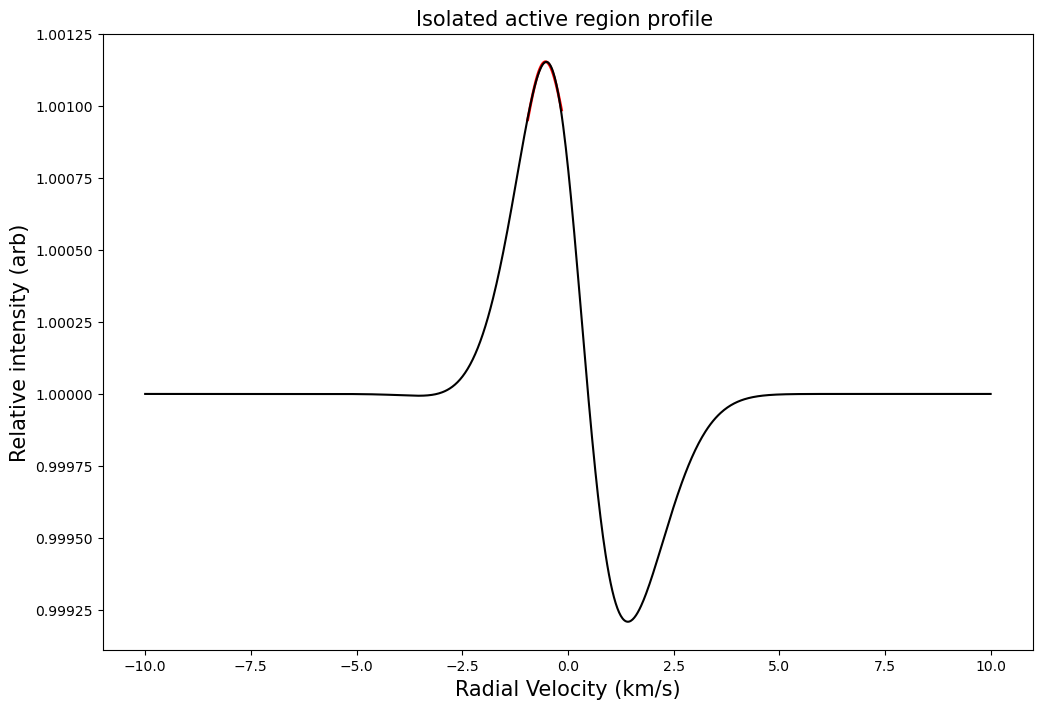

0.0011719116817123787 -0.5505505505505504 30 1
[ 6.60295238e-04 -5.70319838e-01  4.95408123e-01  1.00051221e+00]


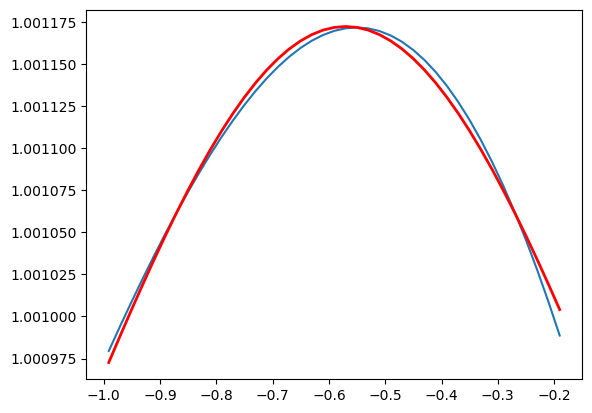

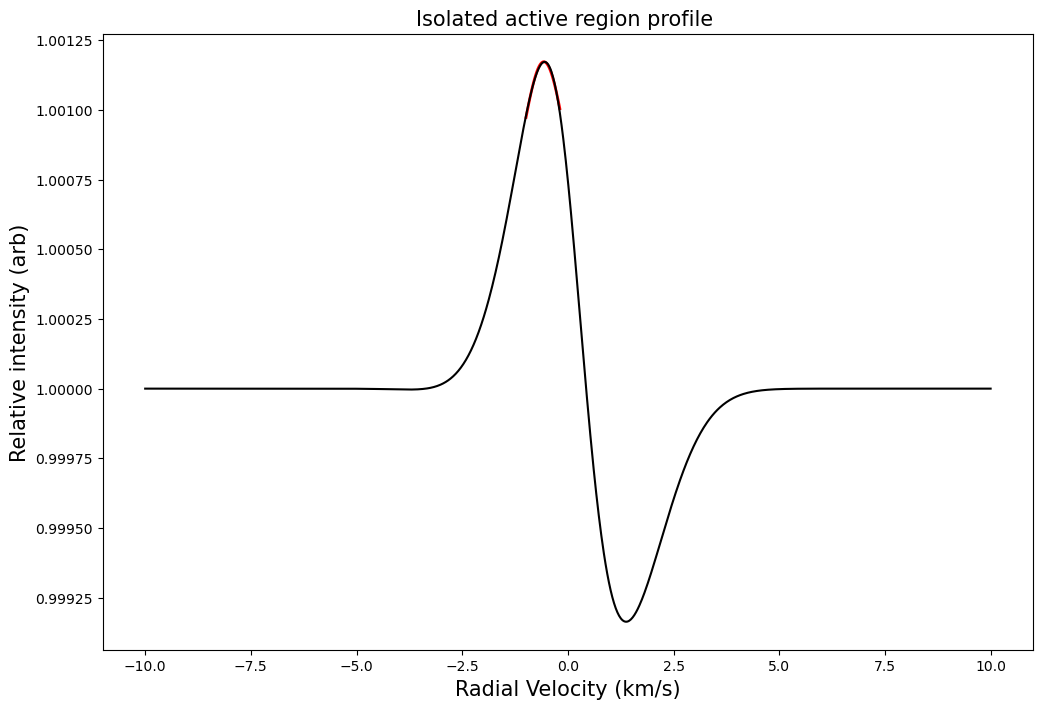

0.0012194158850431513 -0.5905905905905904 30 1
[ 6.82184734e-04 -6.10963865e-01  4.98970938e-01  1.00053781e+00]


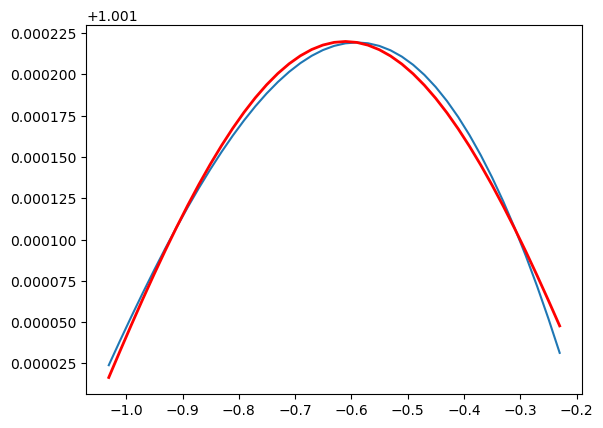

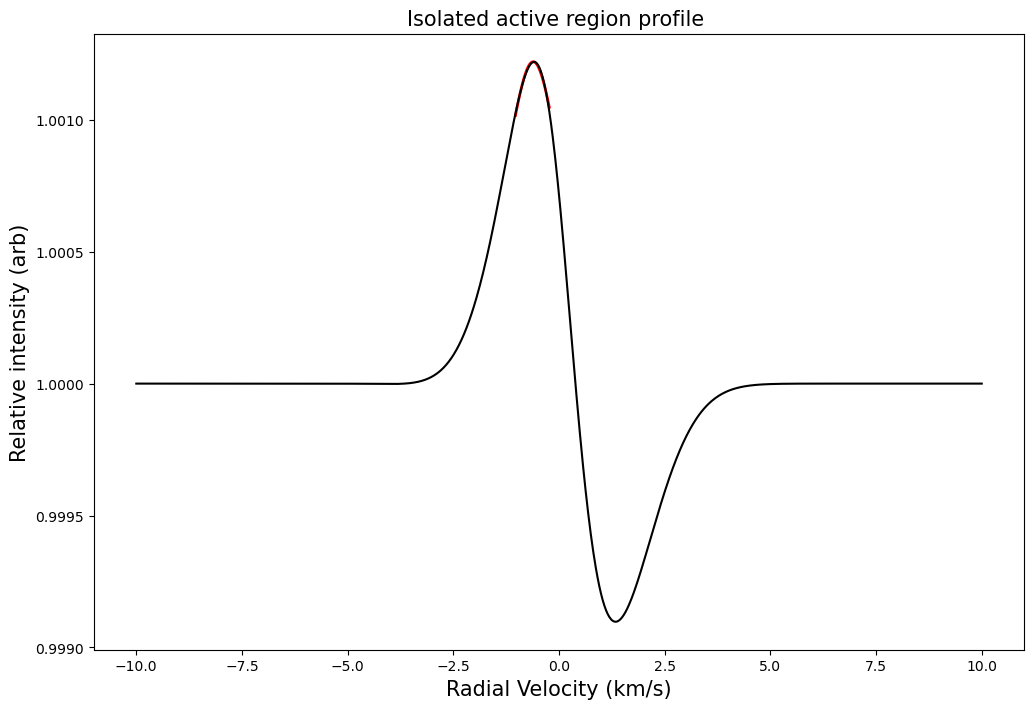

0.0012961461772771354 -0.6306306306306304 30 1
[ 9.41831171e-04 -6.49395343e-01  5.82566683e-01  1.00035447e+00]


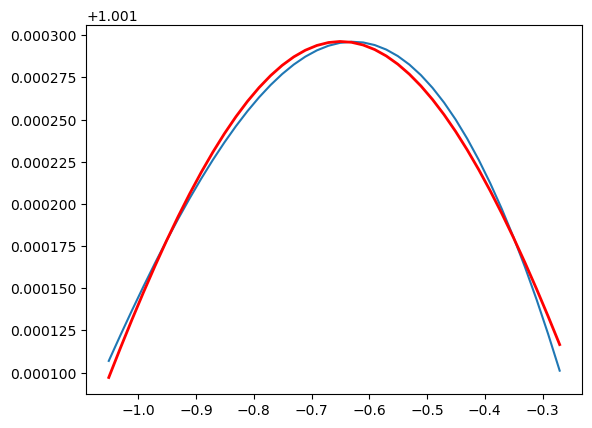

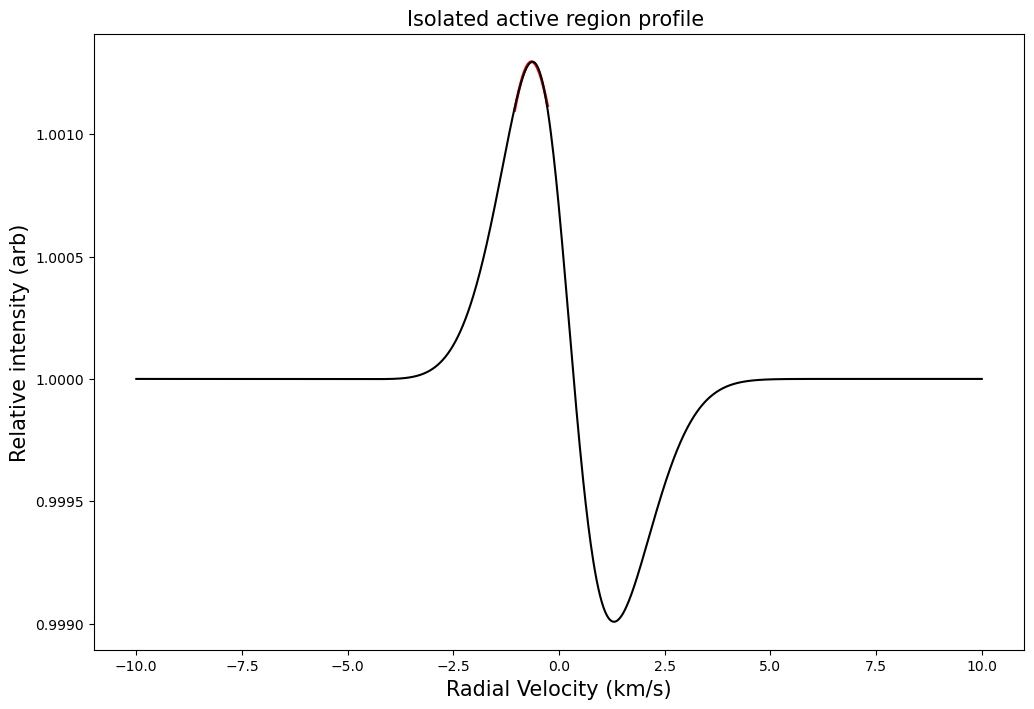

0.0014029435124867096 -0.6706706706706704 30 1
[ 7.11062561e-04 -6.82463526e-01  4.84105541e-01  1.00069252e+00]


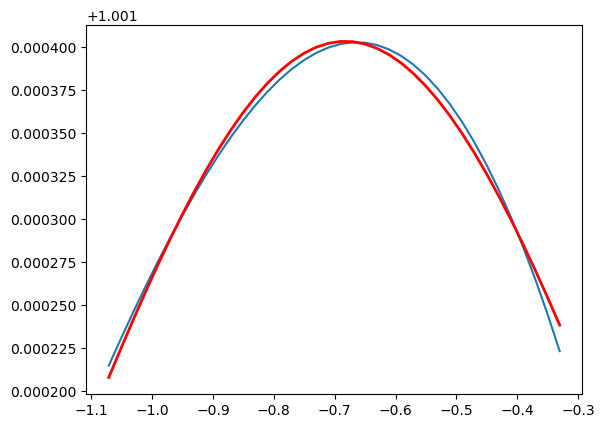

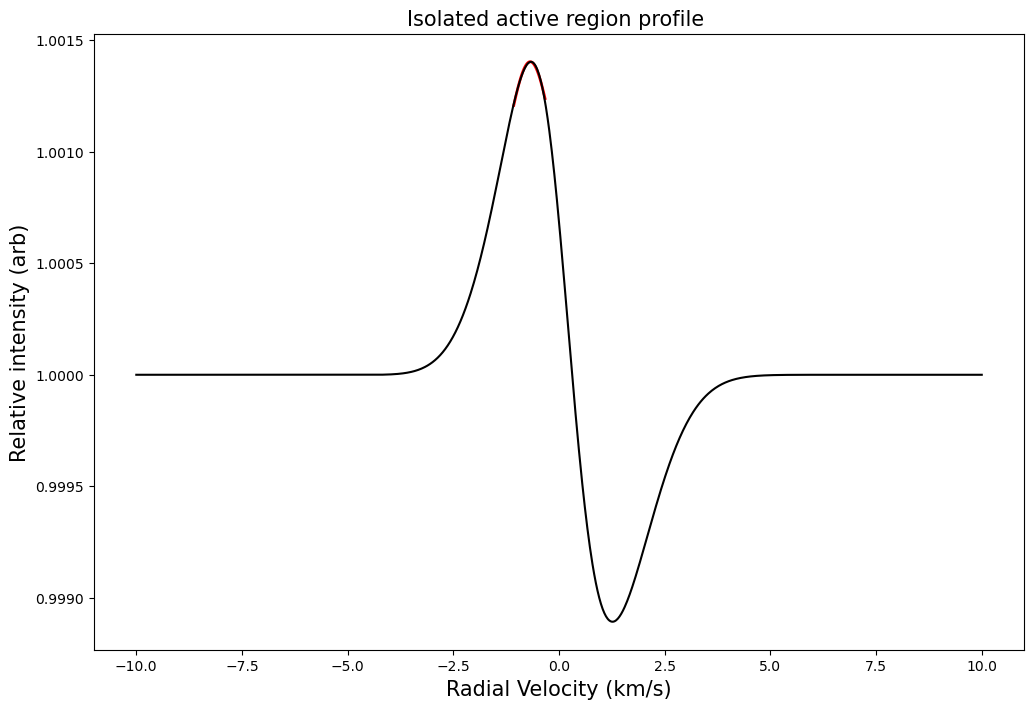

0.0015401439113191806 -0.6906906906906904 30 1
[ 7.82509959e-04 -7.14151504e-01  4.89751251e-01  1.00075820e+00]


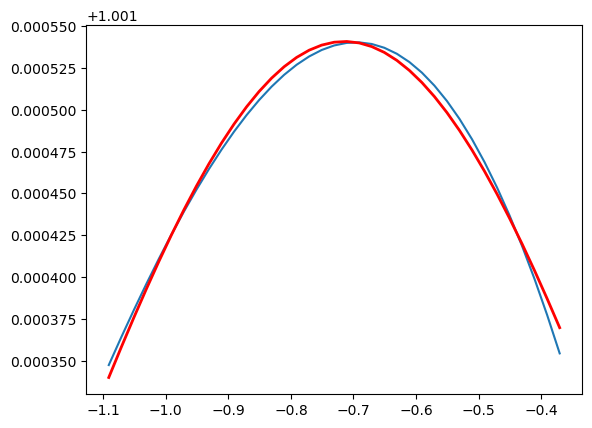

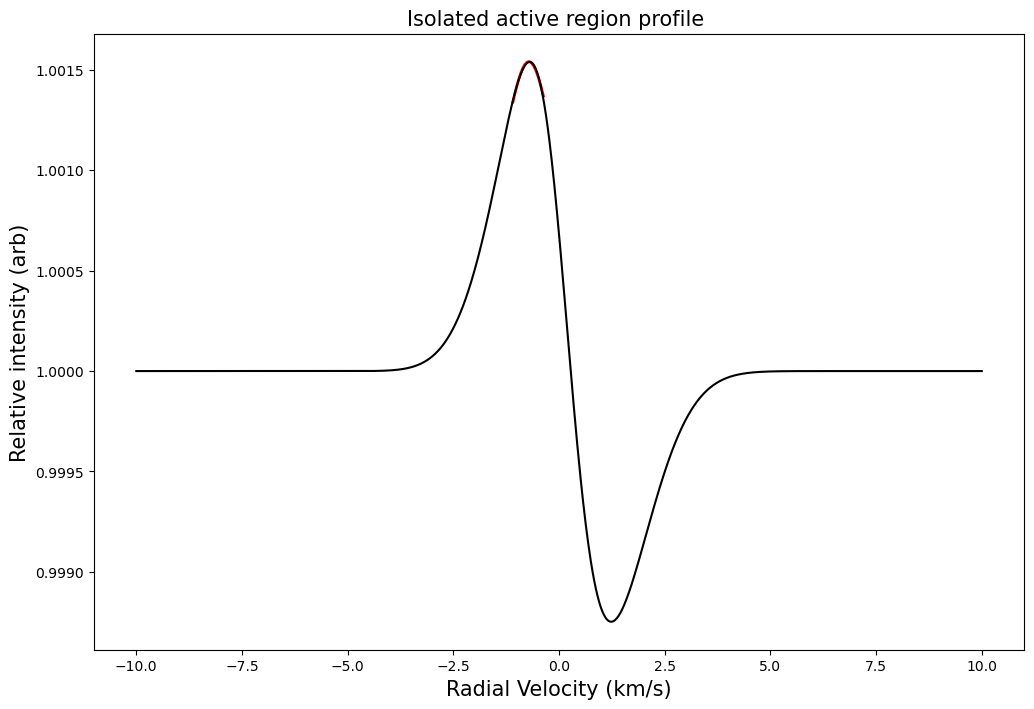

0.0017065848714201692 -0.7307307307307305 30 1
[ 0.00116377 -0.7416994   0.57946824  1.00054301]


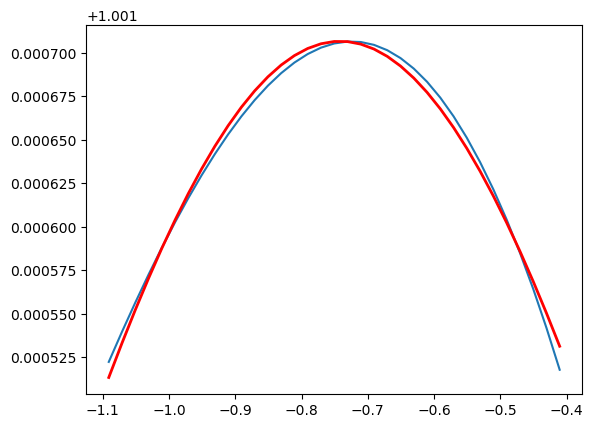

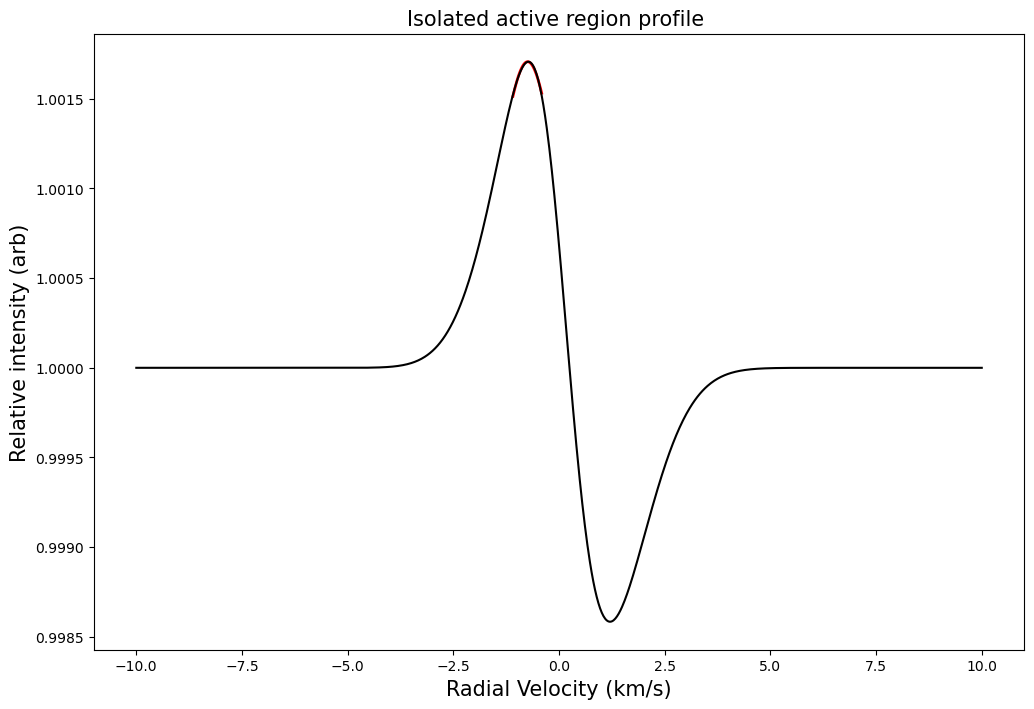

0.00189975928486108 -0.7507507507507505 30 1
[ 8.55071243e-04 -7.64927695e-01  4.66987396e-01  1.00104527e+00]


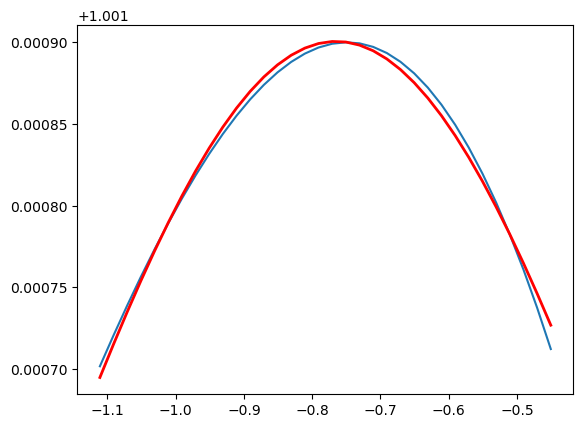

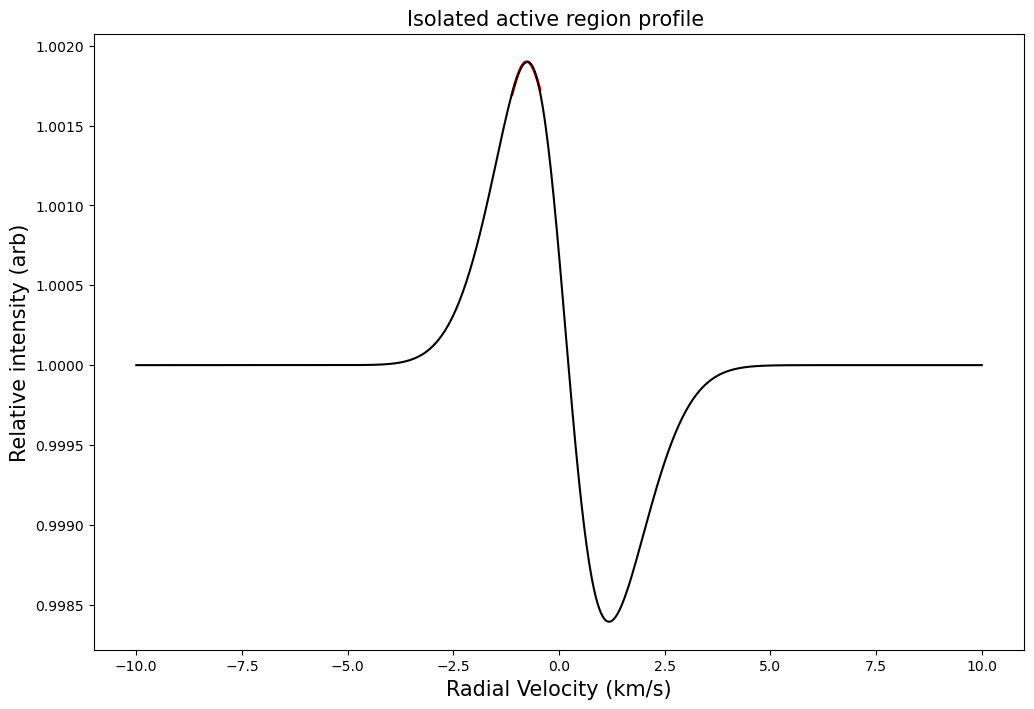

0.0021149366235013733 -0.7707707707707705 30 1
[ 8.18319625e-04 -7.83464272e-01  4.33845226e-01  1.00129728e+00]


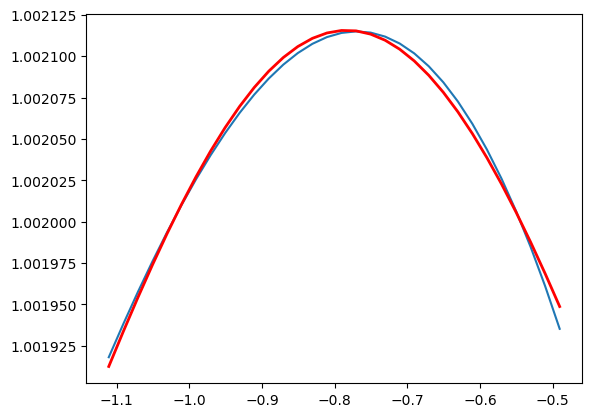

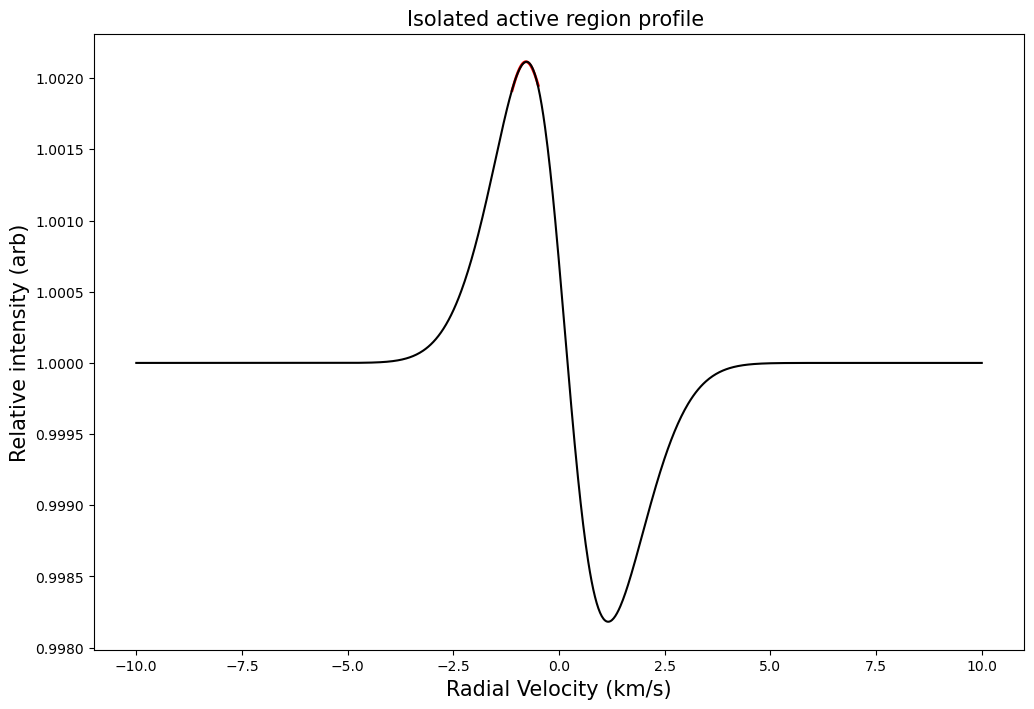

0.002345544282282397 -0.7907907907907905 30 1
[ 0.00110178 -0.79911752  0.48438731  1.00124424]


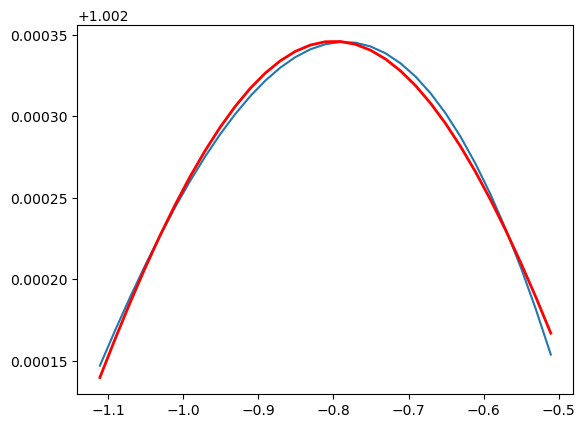

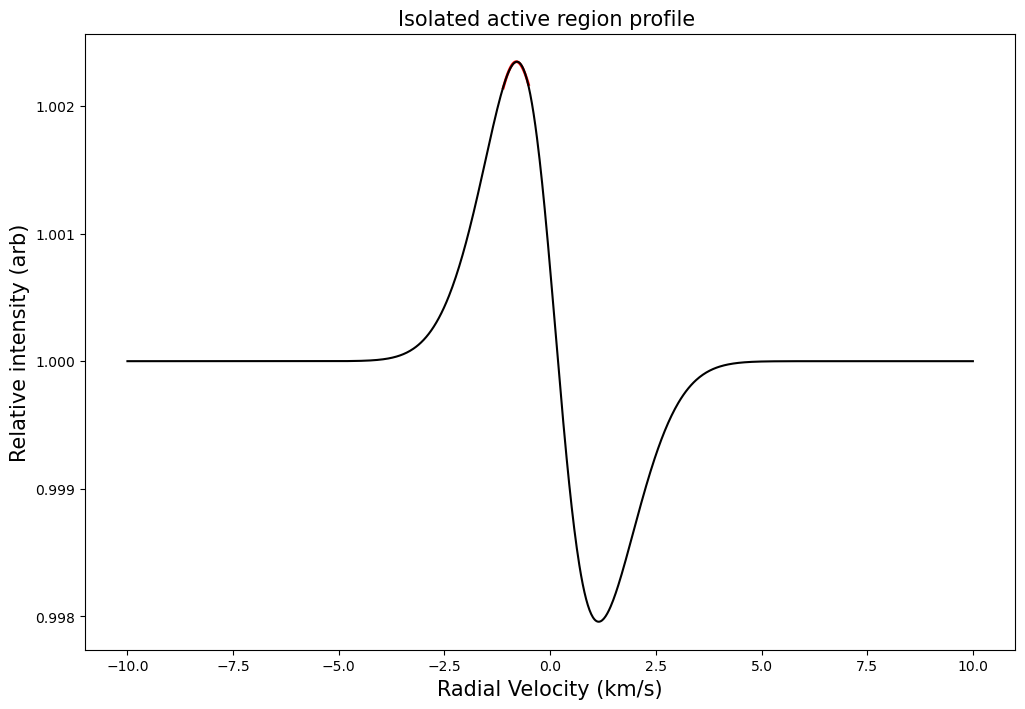

0.0025833108675568095 -0.7907907907907905 30 1
[ 0.00409513 -0.80934768  0.91319003  0.998488  ]


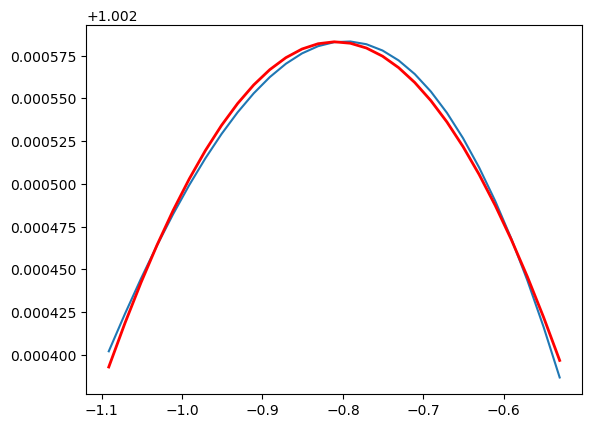

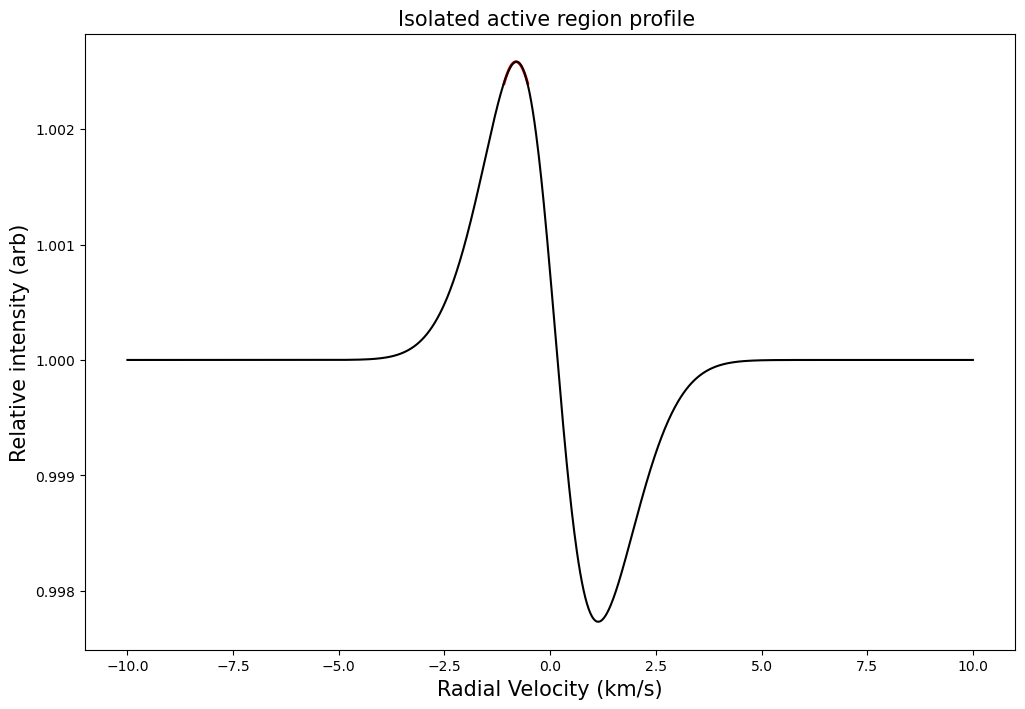

0.0028184026064264067 -0.8108108108108105 30 1
[ 0.00180303 -0.81481565  0.57394588  1.00101562]


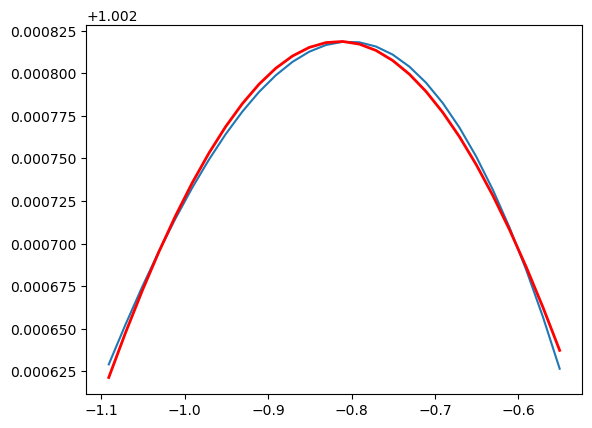

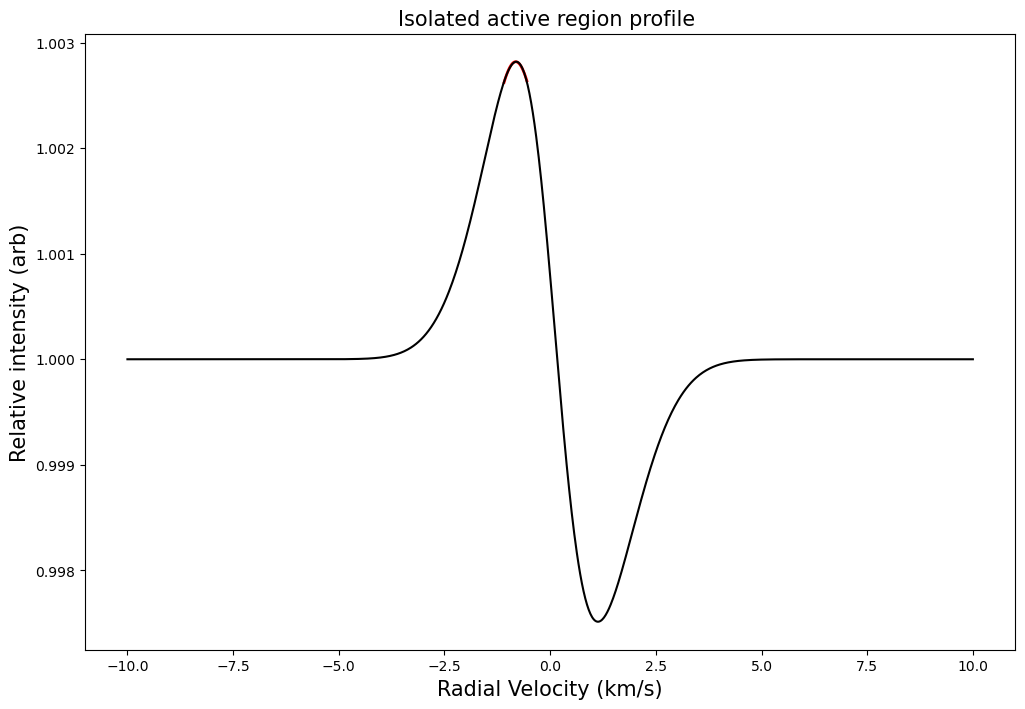

0.0030404736400178045 -0.8108108108108105 30 1
[ 0.00172769 -0.81481424  0.54046393  1.00131303]


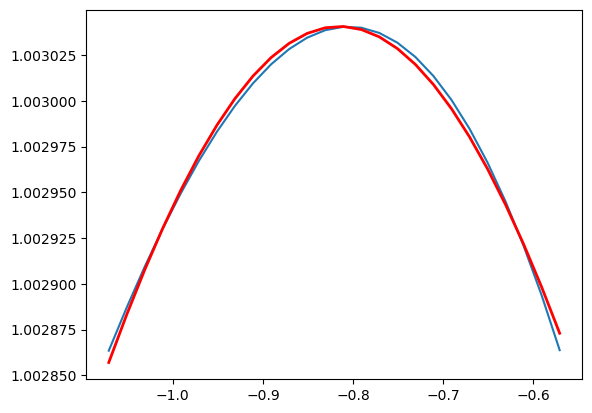

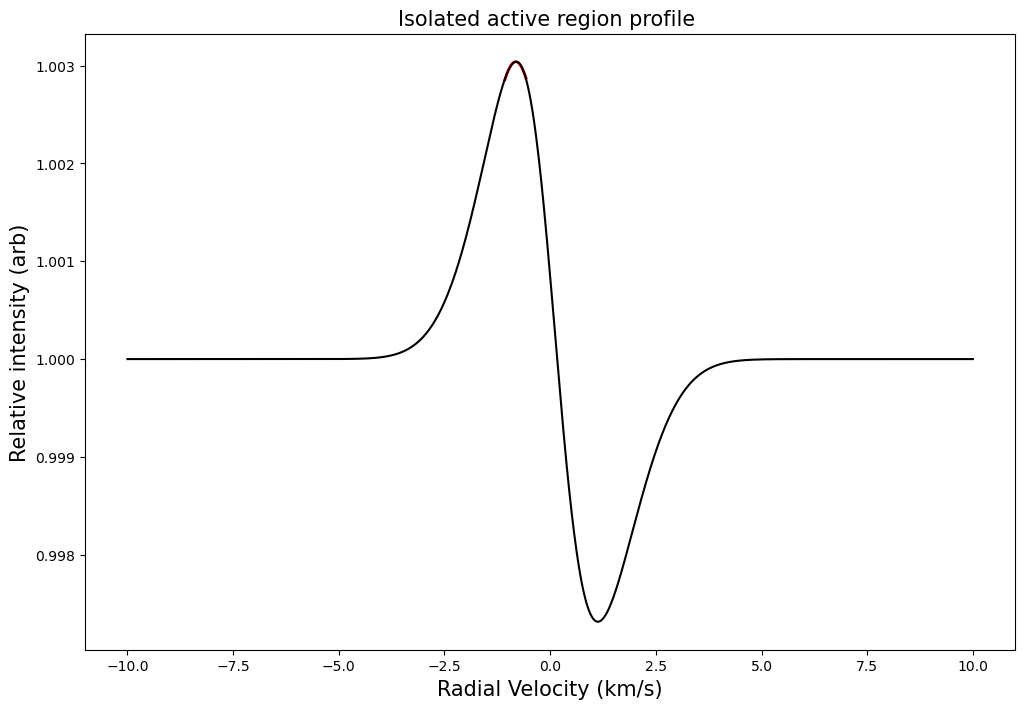

0.0032387085848182284 -0.8108108108108105 30 1
[ 0.00130788 -0.81122929  0.4515897   1.00193148]


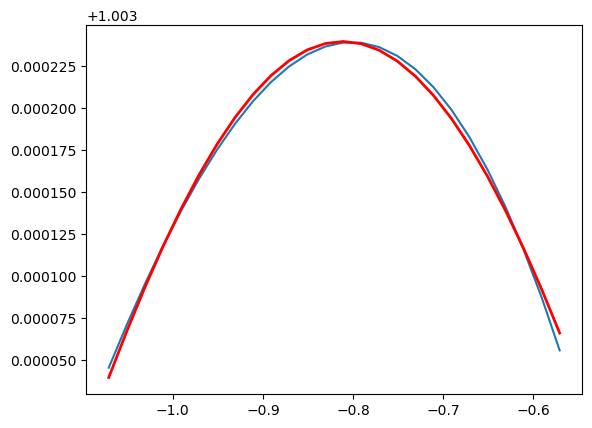

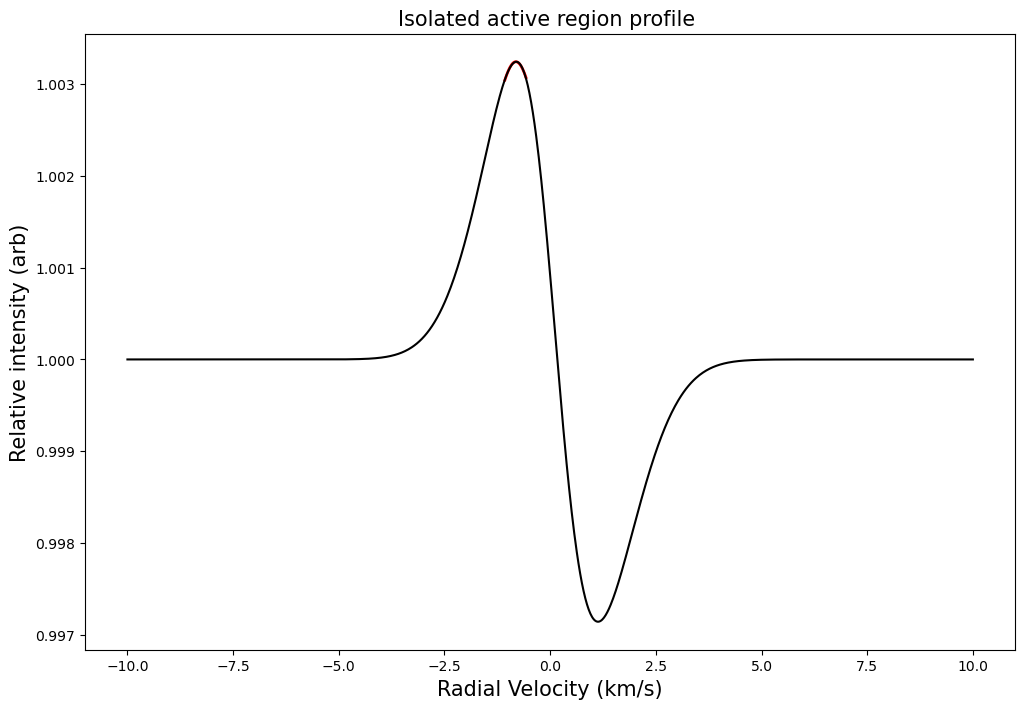

0.0034040993626343052 -0.7907907907907905 30 1
[ 0.00140273 -0.80223404  0.45603382  1.00200172]


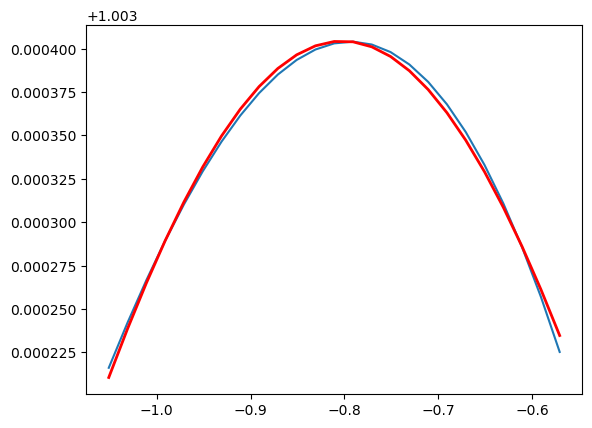

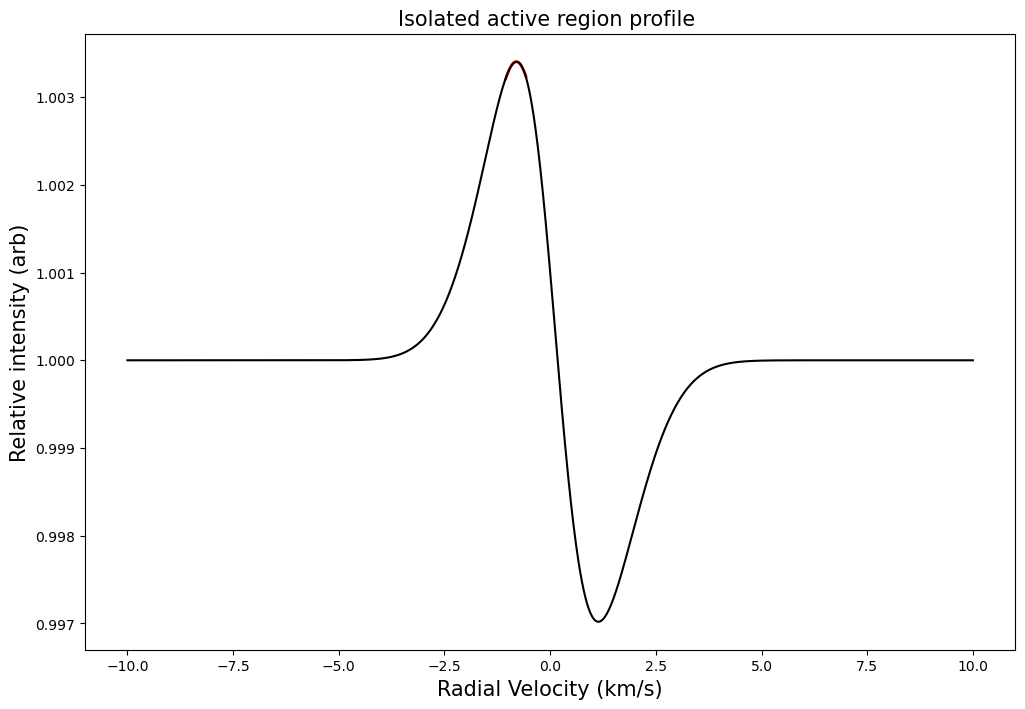

0.0035277147425081257 -0.7707707707707705 30 1
[ 0.00482344 -0.78937533  0.84251135  0.99870439]


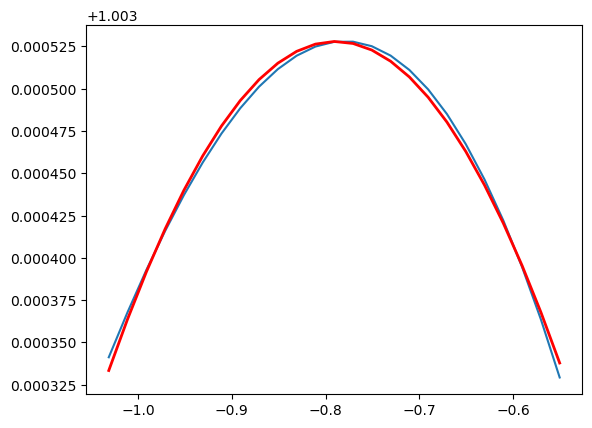

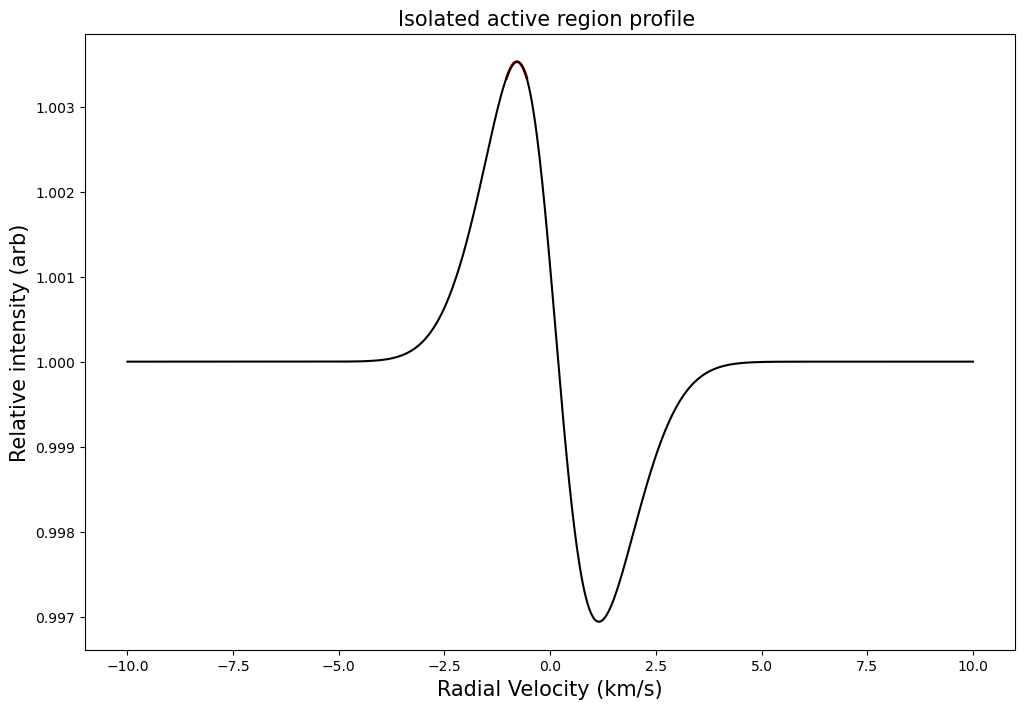

0.003604723817507205 -0.7707707707707705 30 1
[ 0.00121773 -0.77023379  0.40802955  1.00238772]


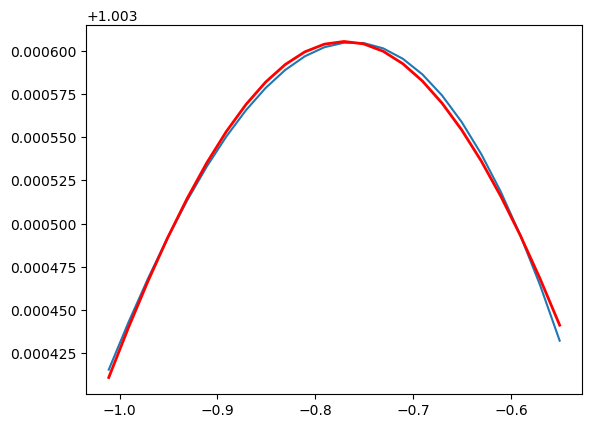

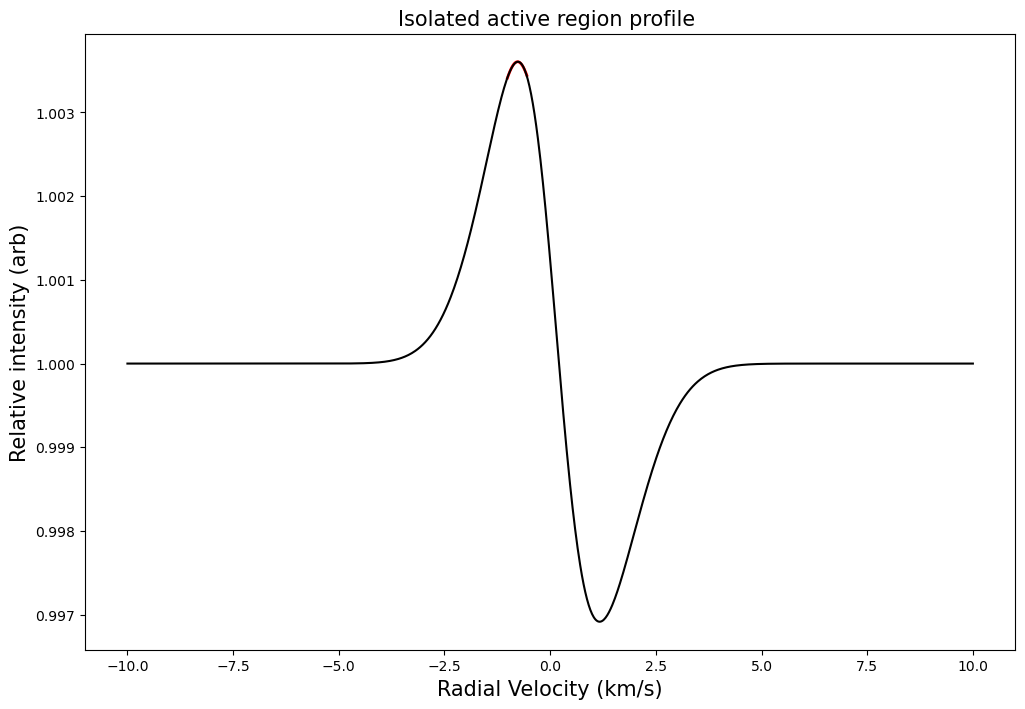

0.00363188363361866 -0.7307307307307305 30 1
[ 0.00107512 -0.74751159  0.37826422  1.00255764]


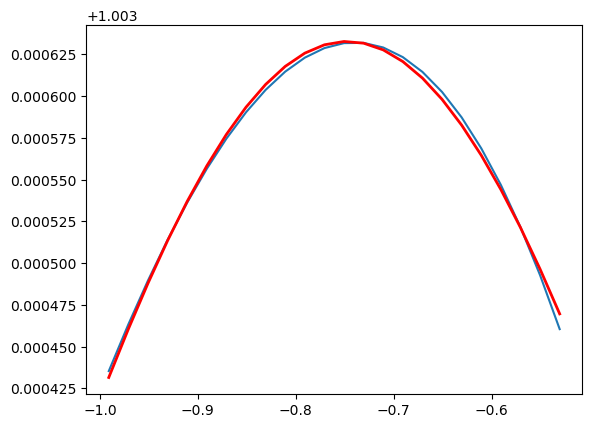

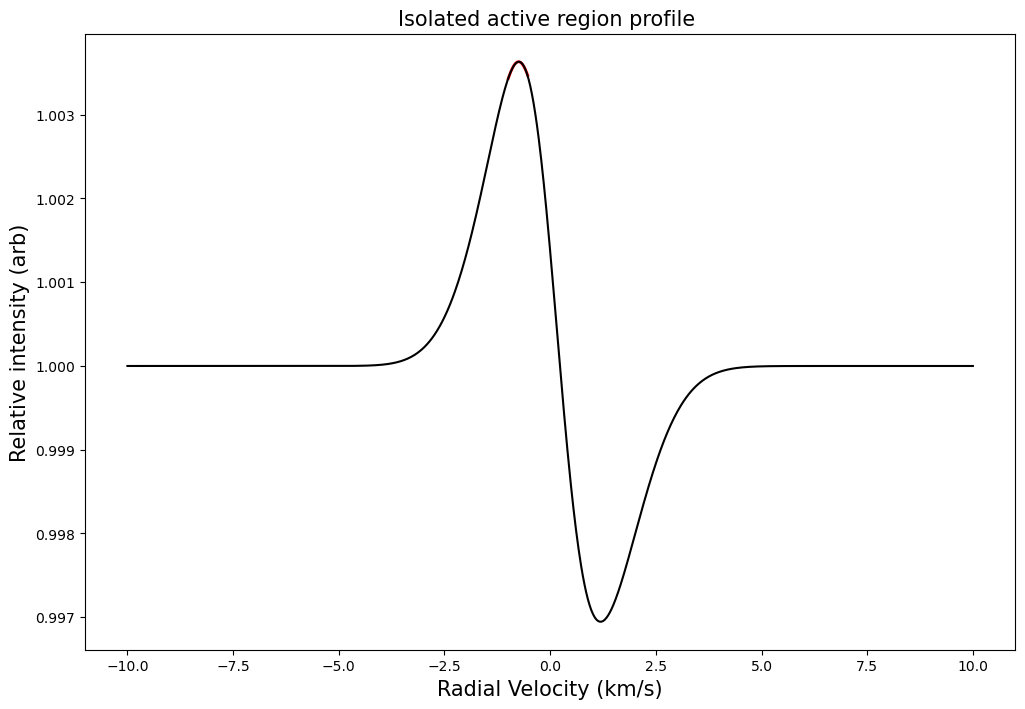

0.0036096851842448707 -0.7107107107107105 30 1
[ 0.01331986 -0.72130601  1.36720834  0.99028956]


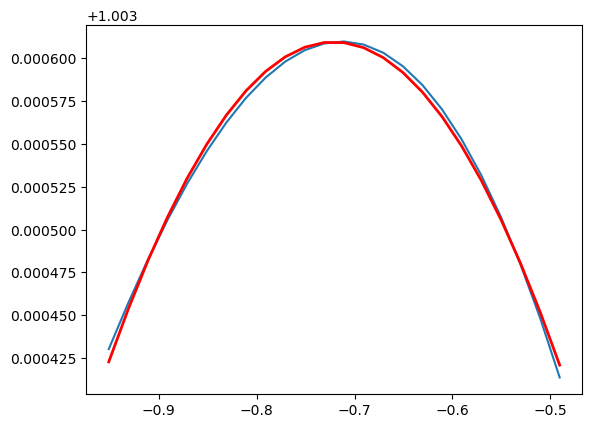

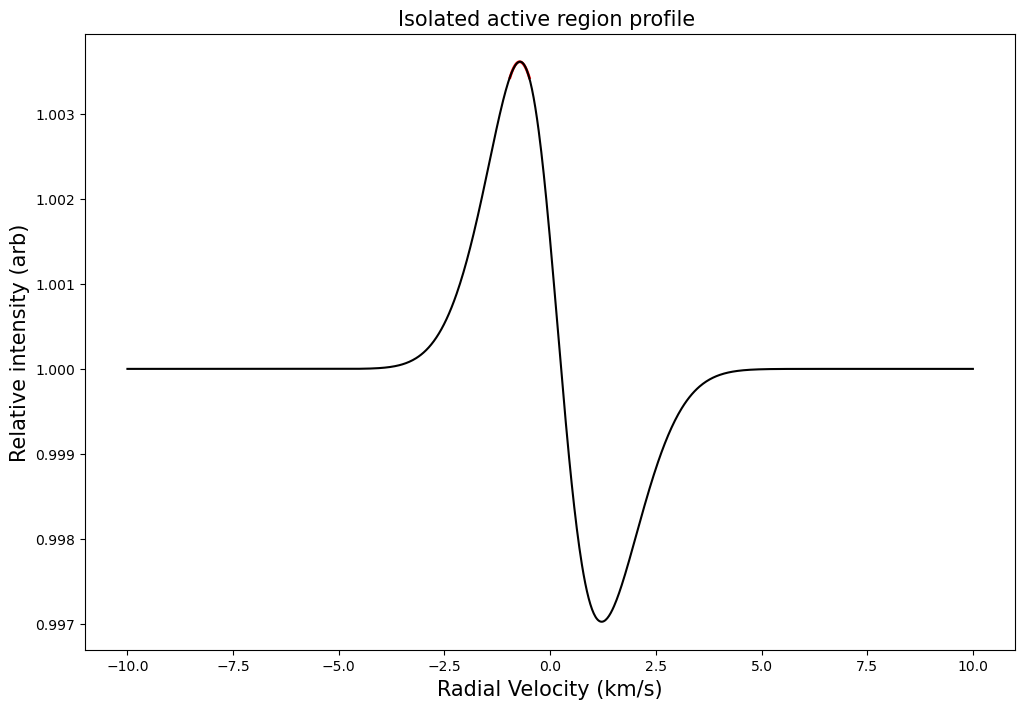

0.0035403393574047204 -0.6906906906906904 30 1
[ 0.00123391 -0.6899671   0.40642744  1.00230715]


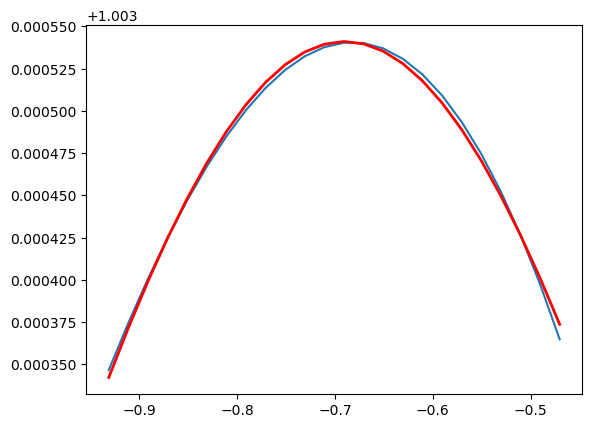

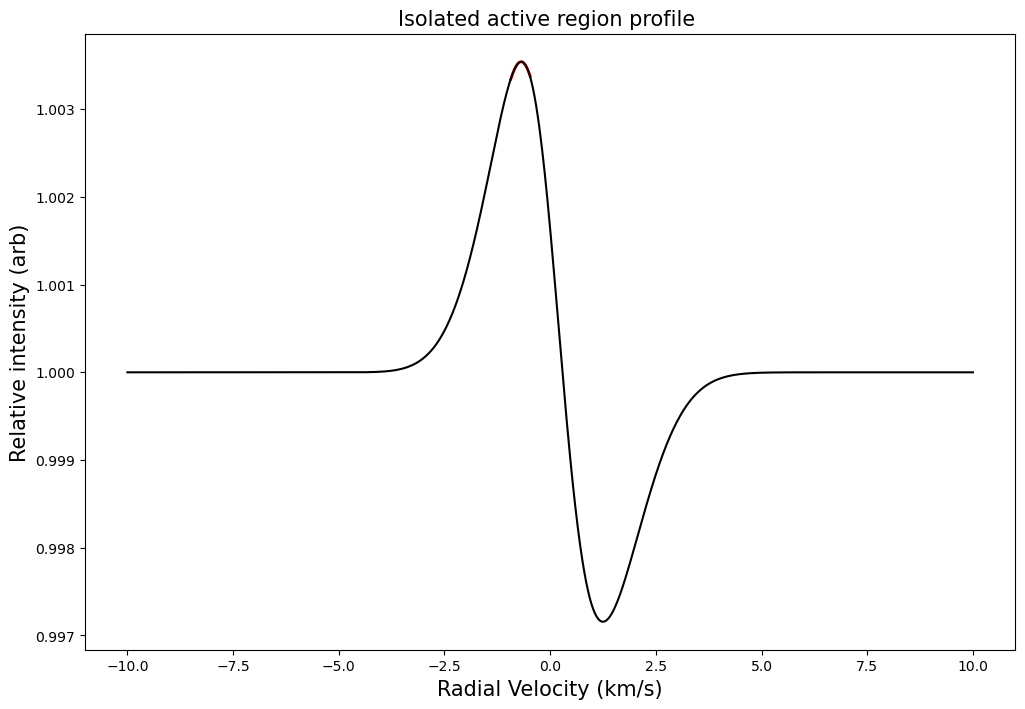

0.0034303455043069864 -0.6506506506506504 30 1
[ 0.0021213  -0.65591442  0.54354317  1.00130918]


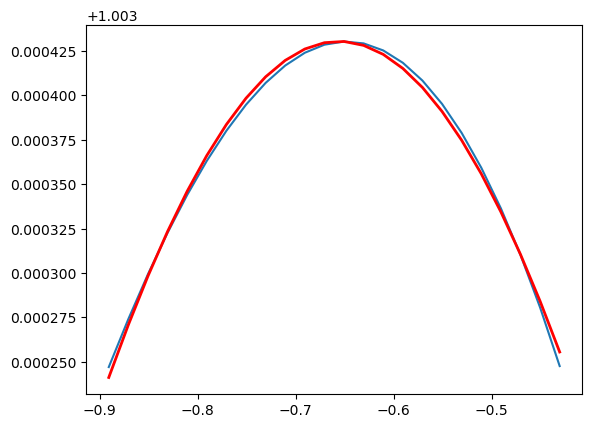

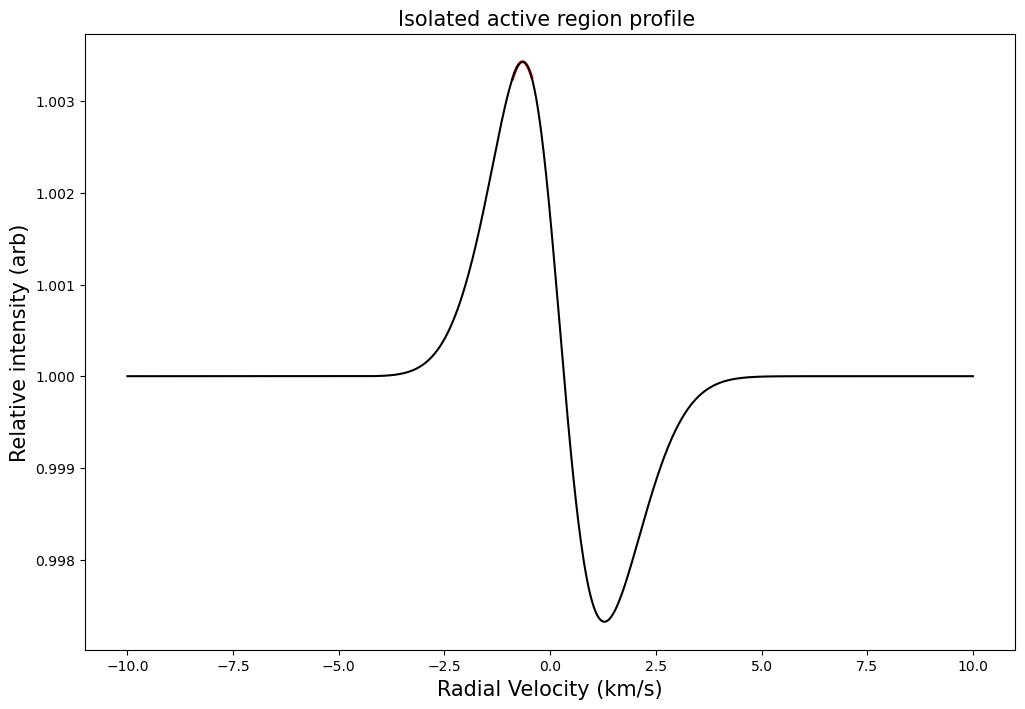

0.0032863462182568526 -0.6106106106106104 30 1
[ 0.00344789 -0.61871988  0.70620364  0.99983837]


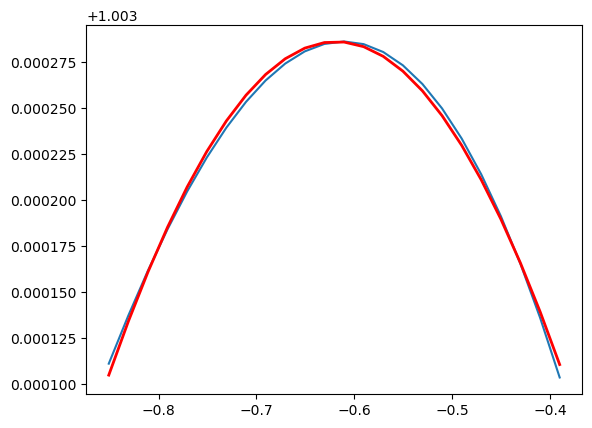

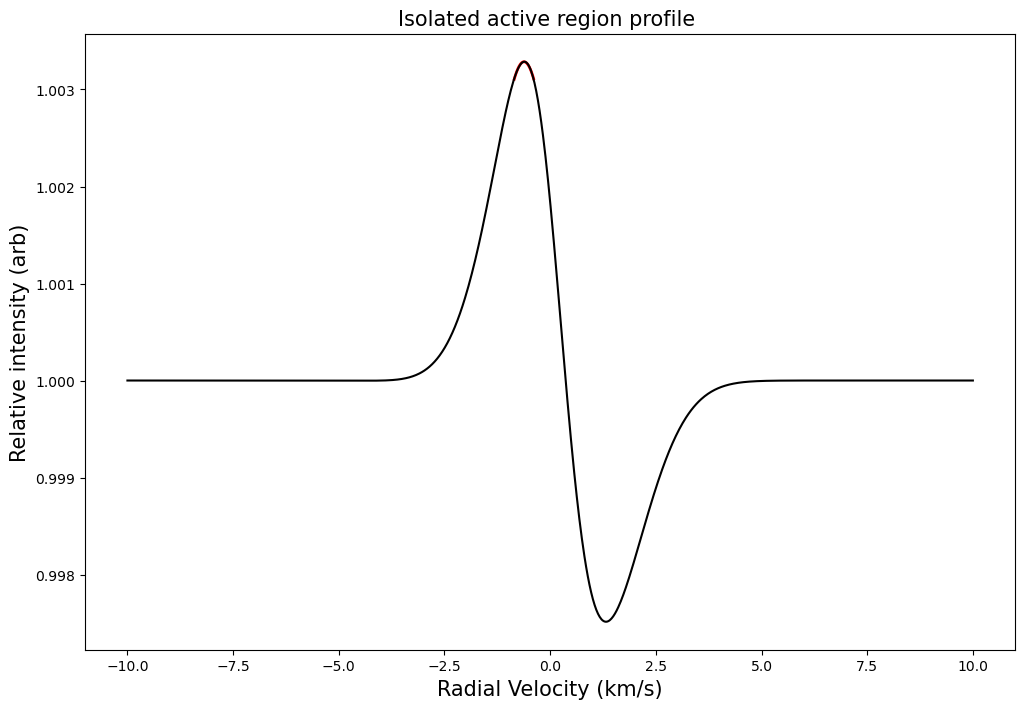

0.0031168370742131746 -0.5705705705705704 30 1
[ 0.00122392 -0.57957345  0.42012937  1.00189337]


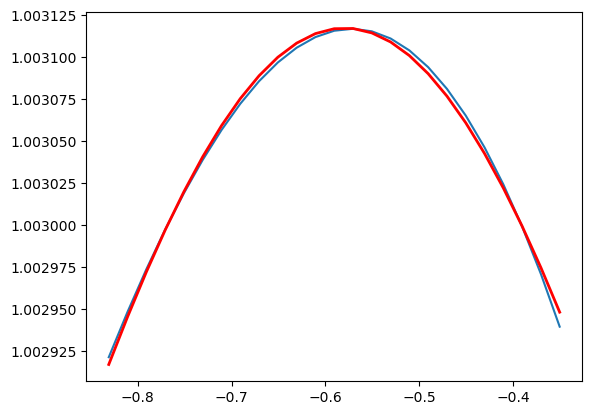

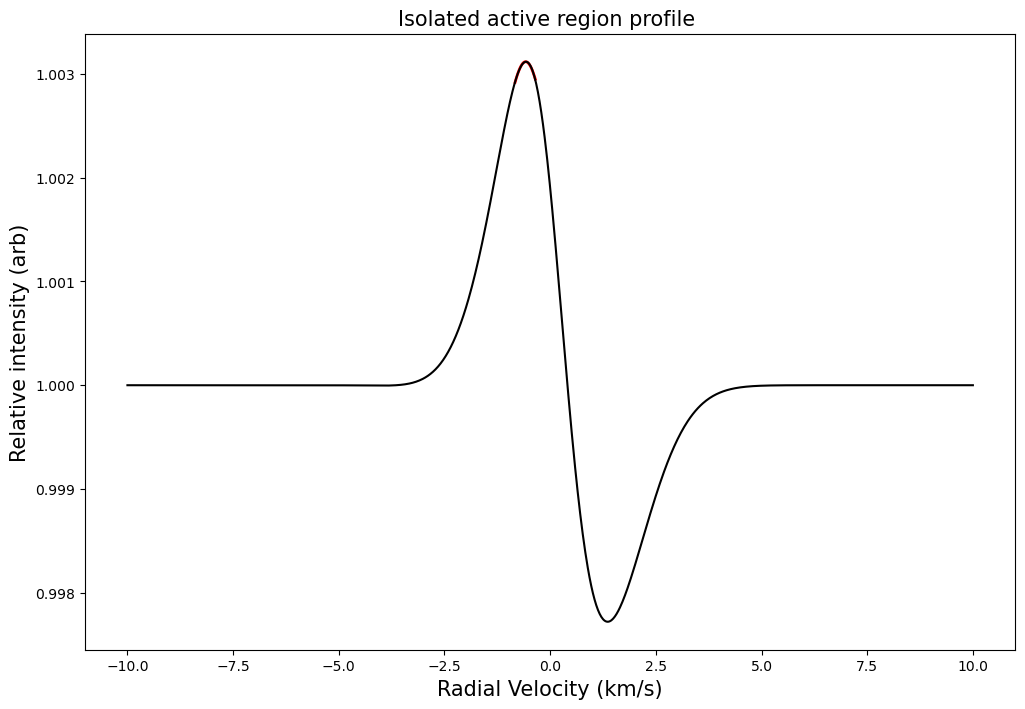

0.0029302770268668787 -0.5305305305305303 30 1
[ 0.00116296 -0.5391591   0.41814976  1.00176776]


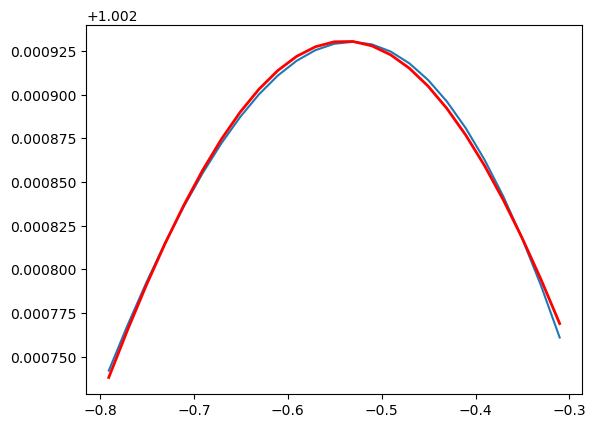

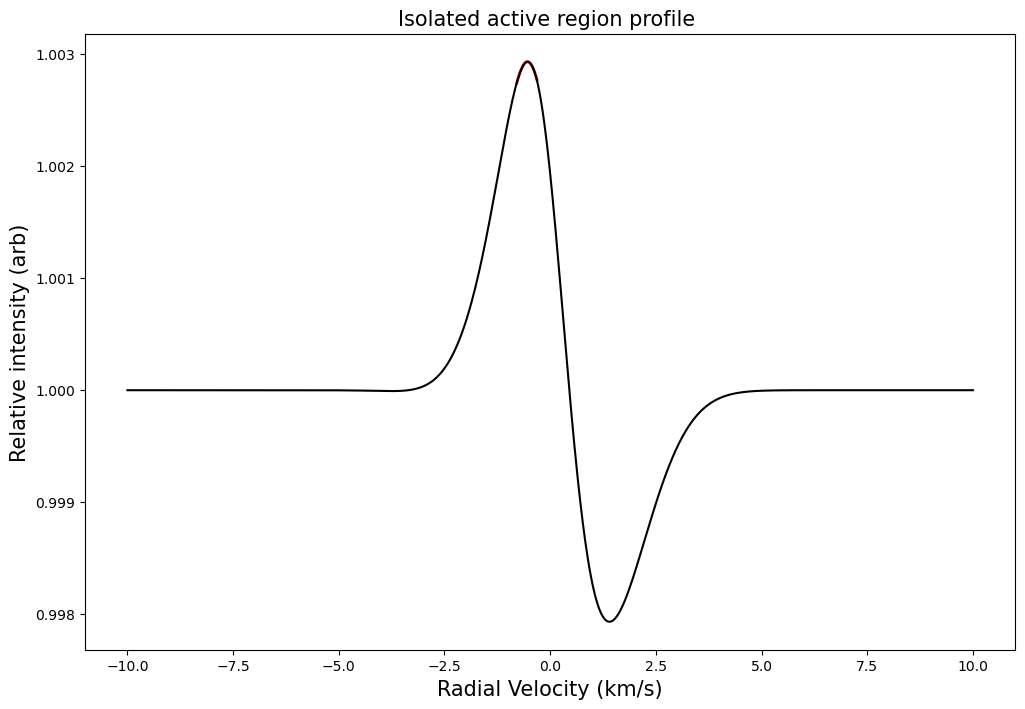

0.0027344226602199484 -0.4904904904904903 30 1
[ 0.00405616 -0.50010089  0.81819102  0.99867809]


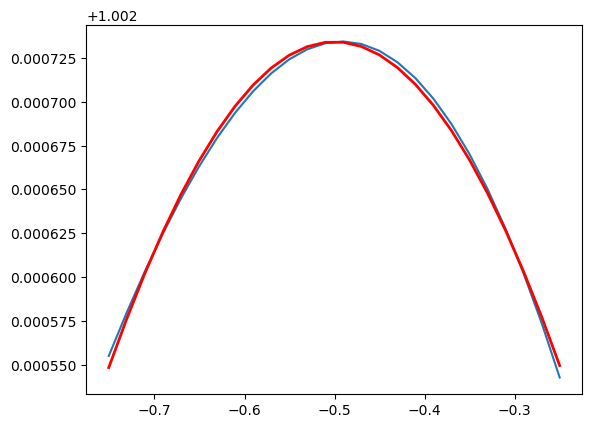

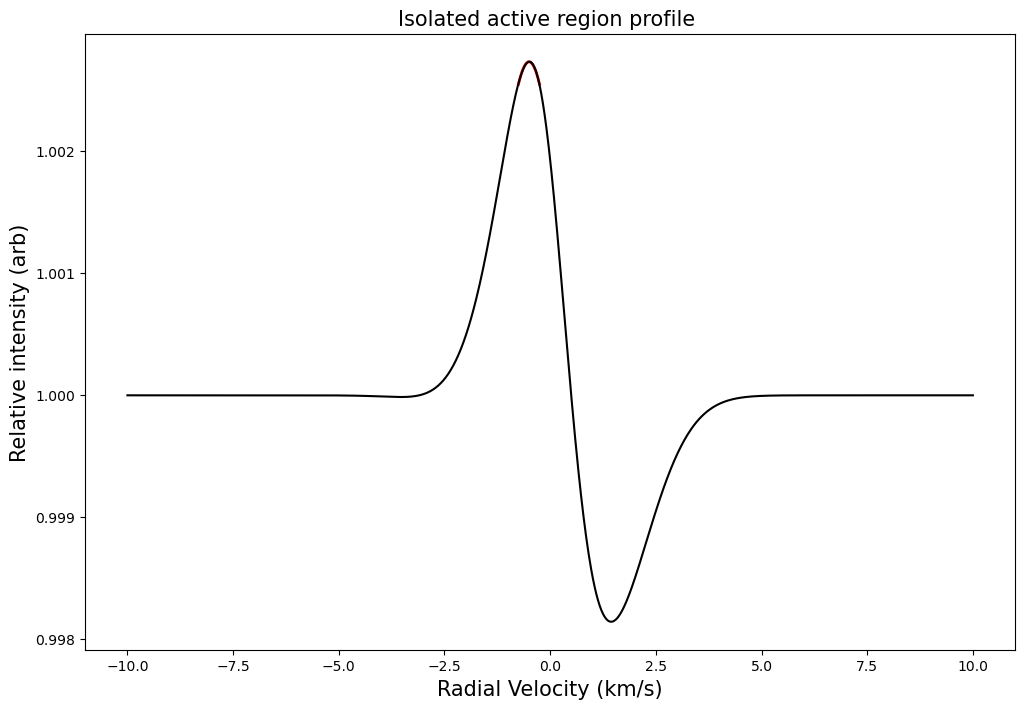

0.002535839833620379 -0.4504504504504503 30 1
[ 0.00142537 -0.46210005  0.49142918  1.00111078]


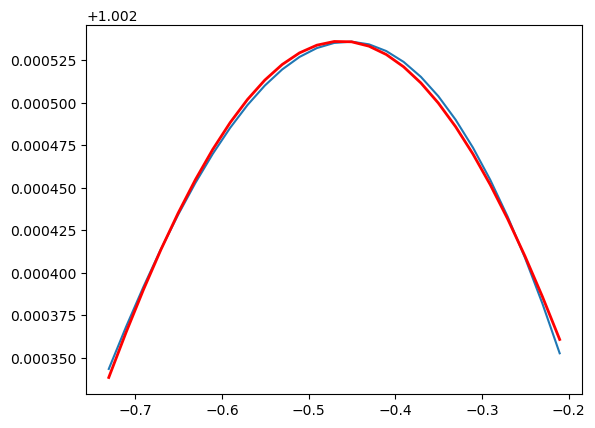

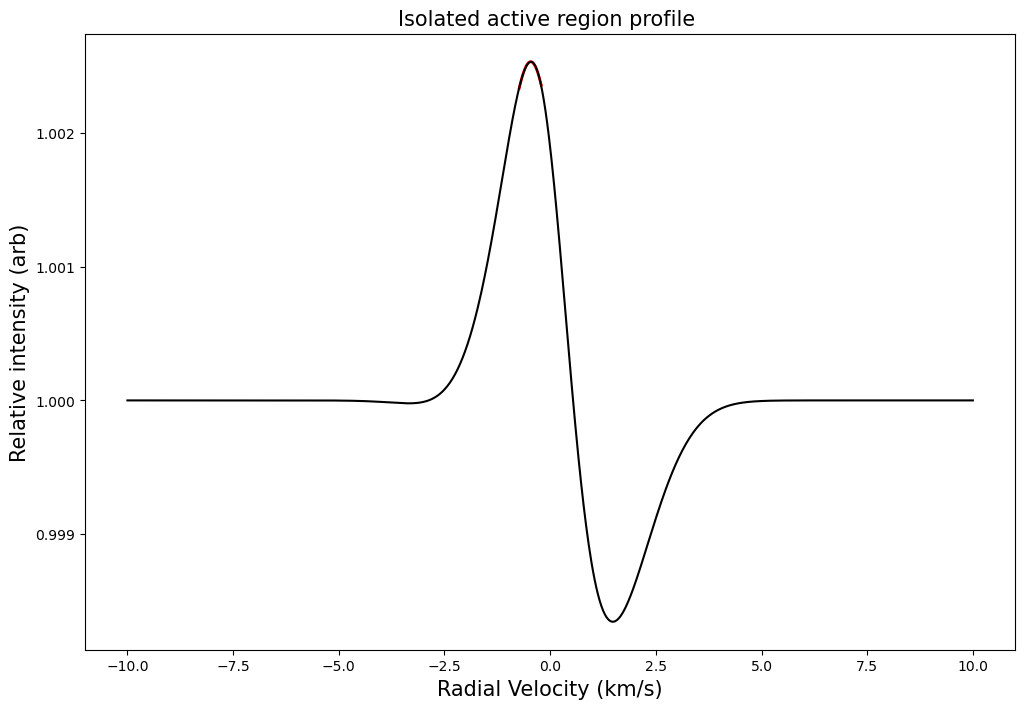

0.0023396064532992256 -0.41041041041041026 30 1
[ 0.00112374 -0.42755367  0.44784517  1.00121654]


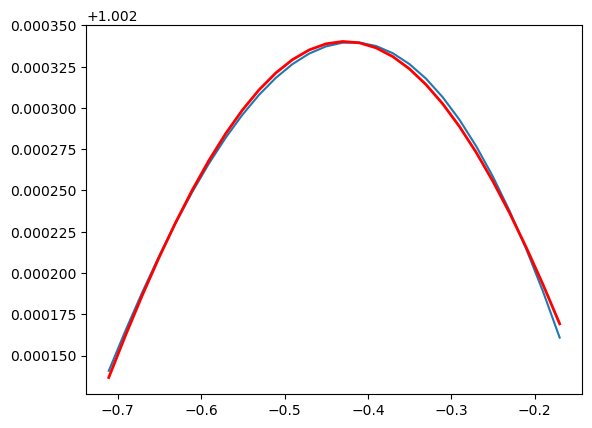

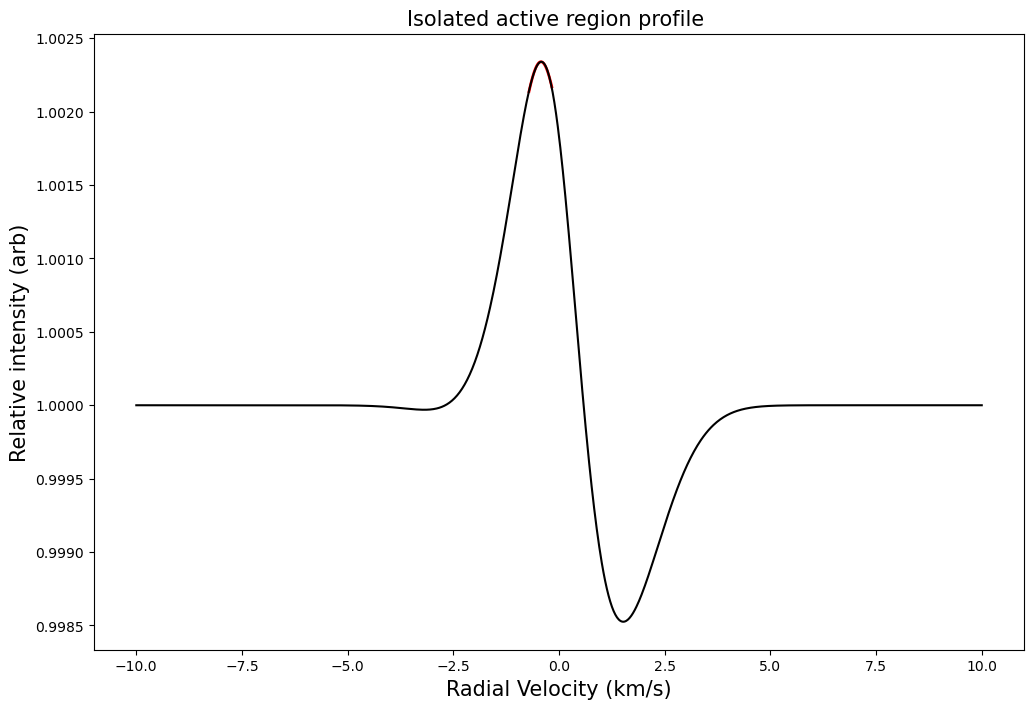

0.0021502499390606555 -0.39039039039039025 30 1
[ 0.00115159 -0.39839311  0.47052731  1.00099905]


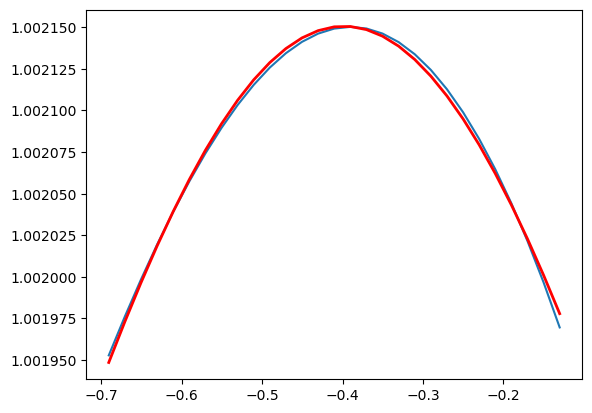

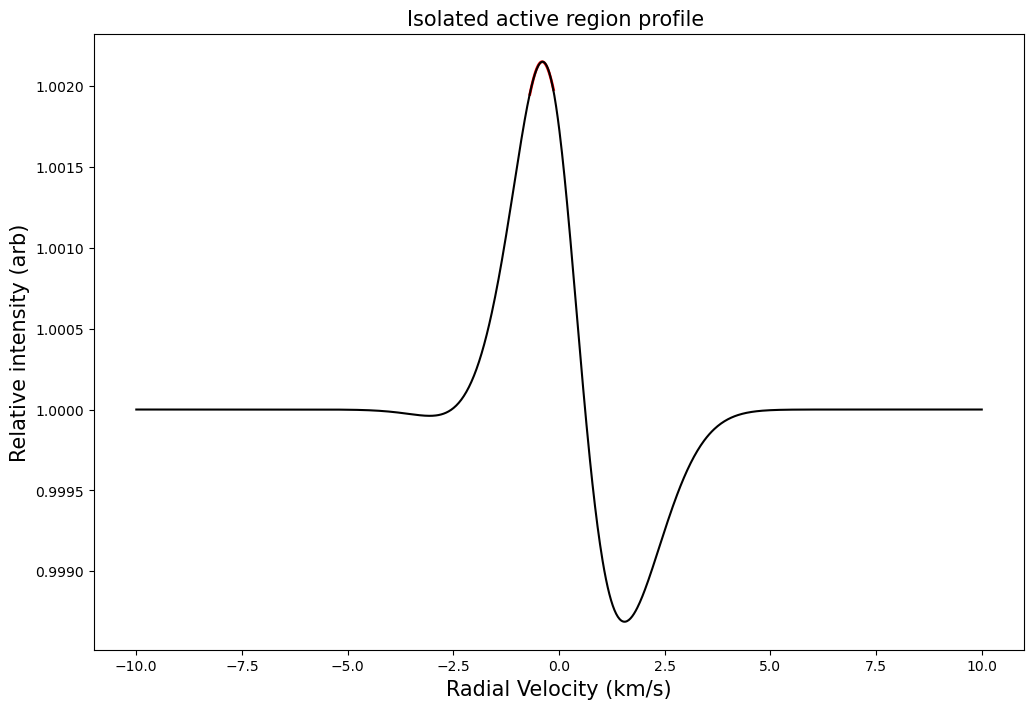

0.001970184609502601 -0.37037037037037024 30 1
[ 0.00177474 -0.37617105  0.61450896  1.00019549]


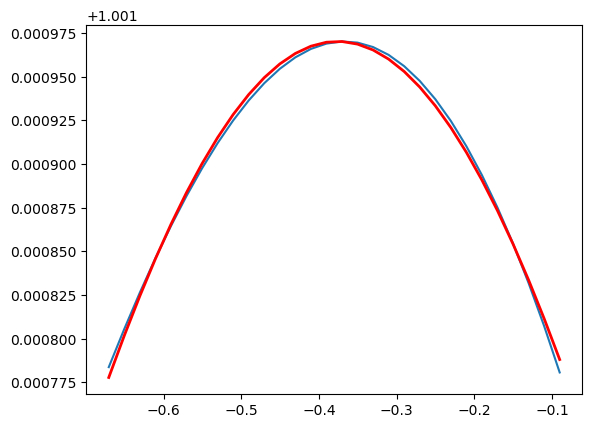

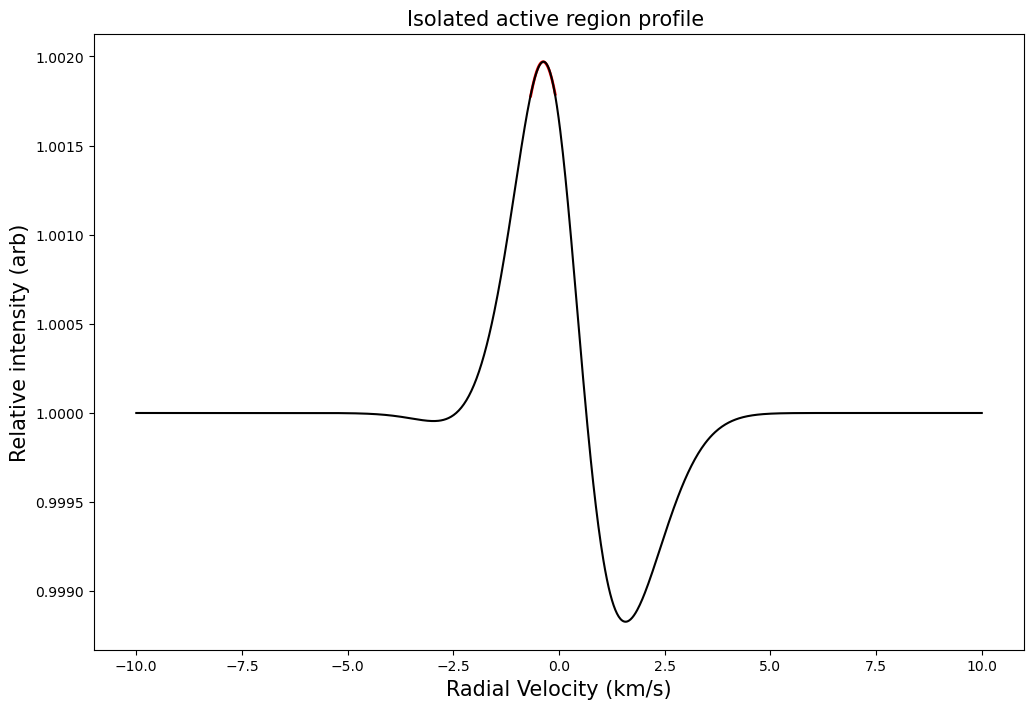

0.0018022647549769122 -0.3503503503503502 30 1
[ 0.00124254 -0.36143237  0.53185714  1.00055997]


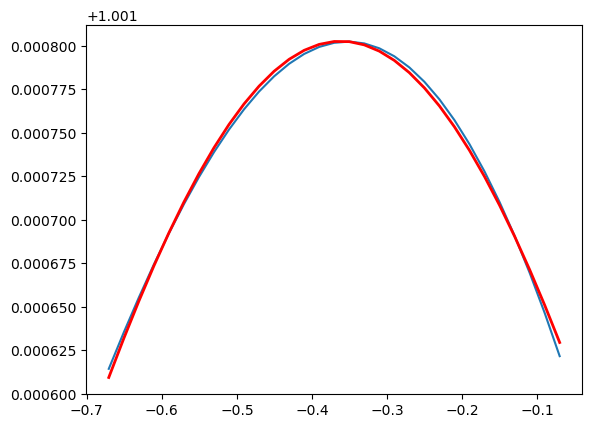

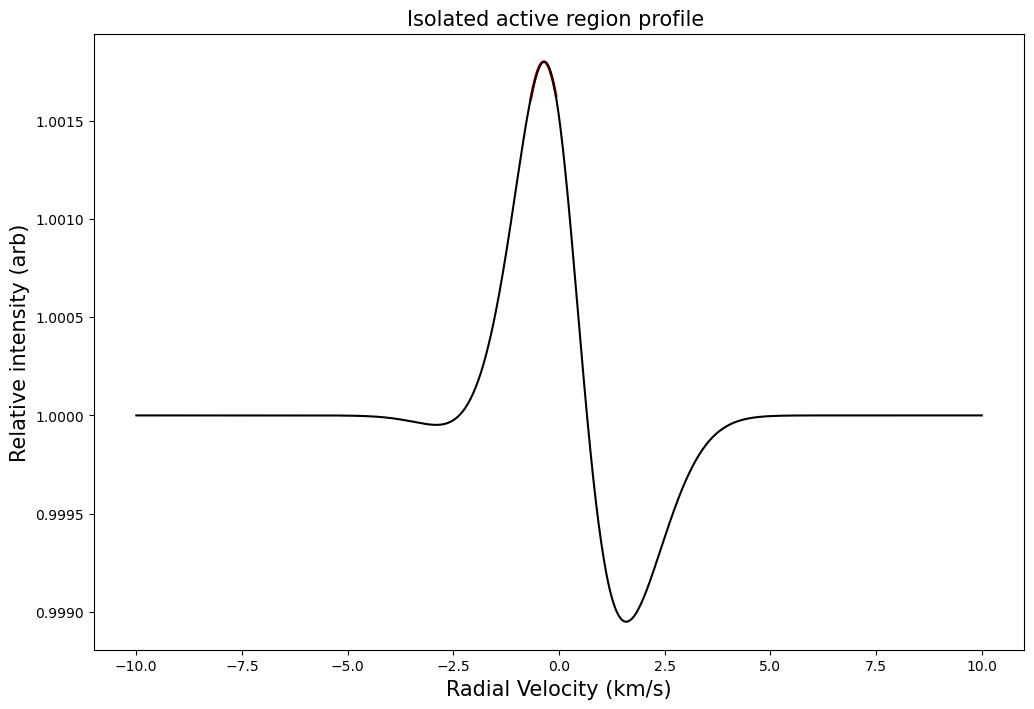

0.0016488209940239695 -0.3503503503503502 30 1
[ 9.92446056e-04 -3.56198164e-01  4.92983192e-01  1.00065683e+00]


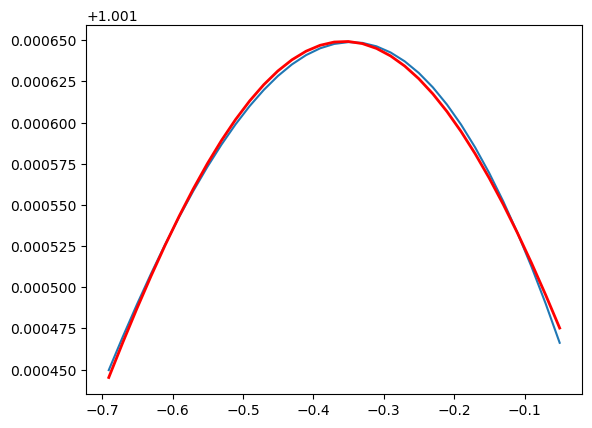

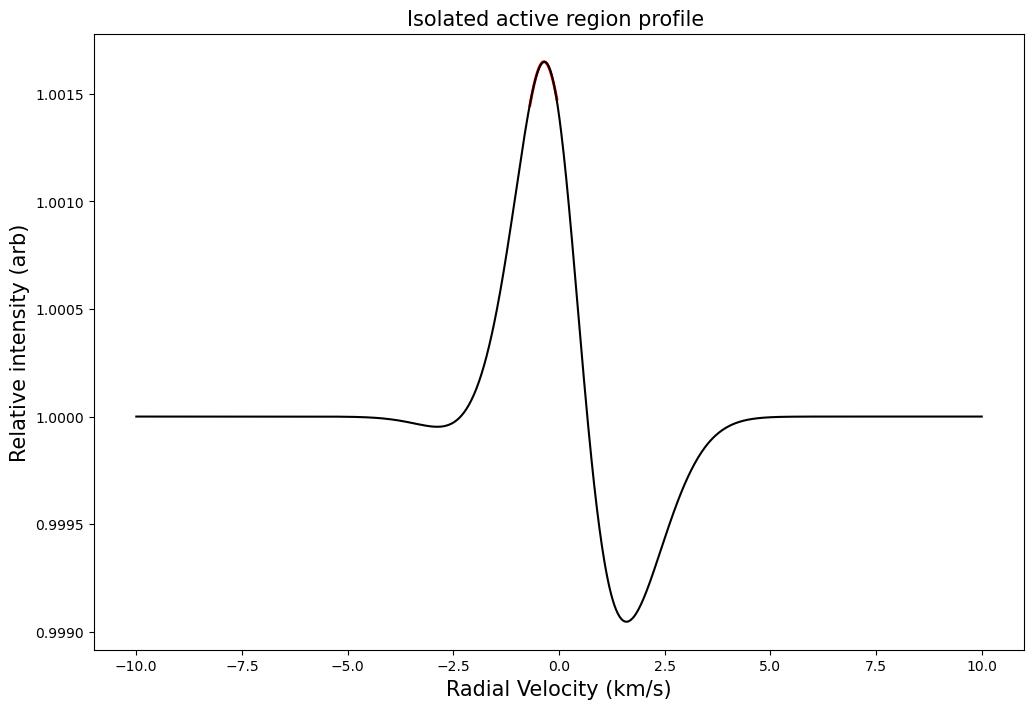

0.001512318092925069 -0.3503503503503502 30 1
[ 0.00116012 -0.36109281  0.56057946  1.00035241]


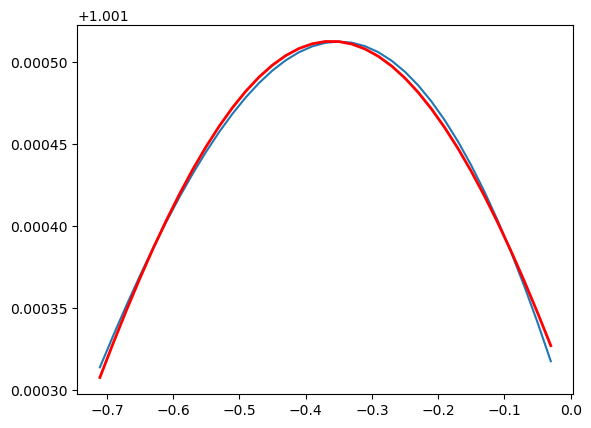

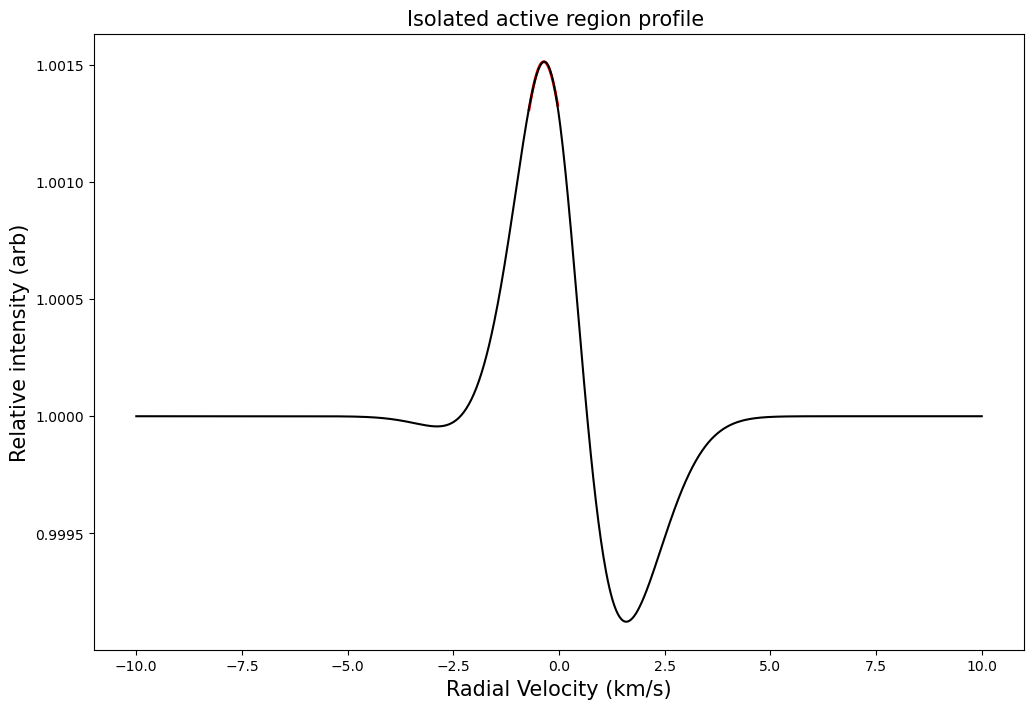

0.0013948643397754257 -0.37037037037037024 30 1
[ 0.00131809 -0.37485818  0.62740973  1.0000769 ]


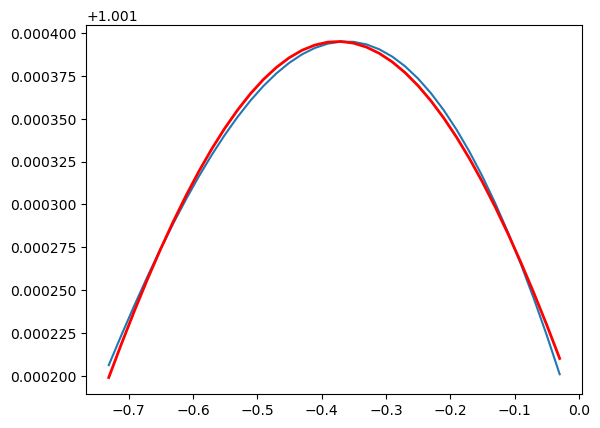

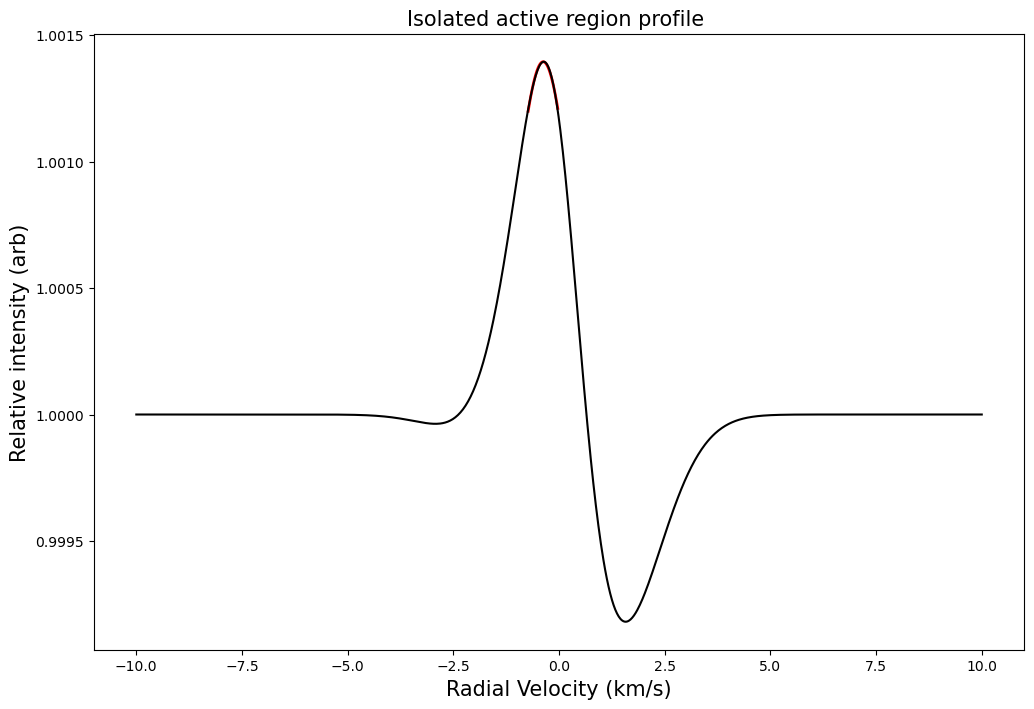

0.0012988315642417092 -0.39039039039039025 30 1
[ 8.82008641e-04 -3.97027776e-01 -5.28002726e-01  1.00041724e+00]


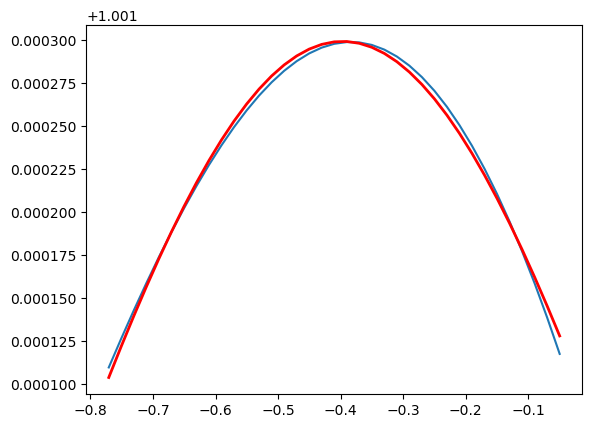

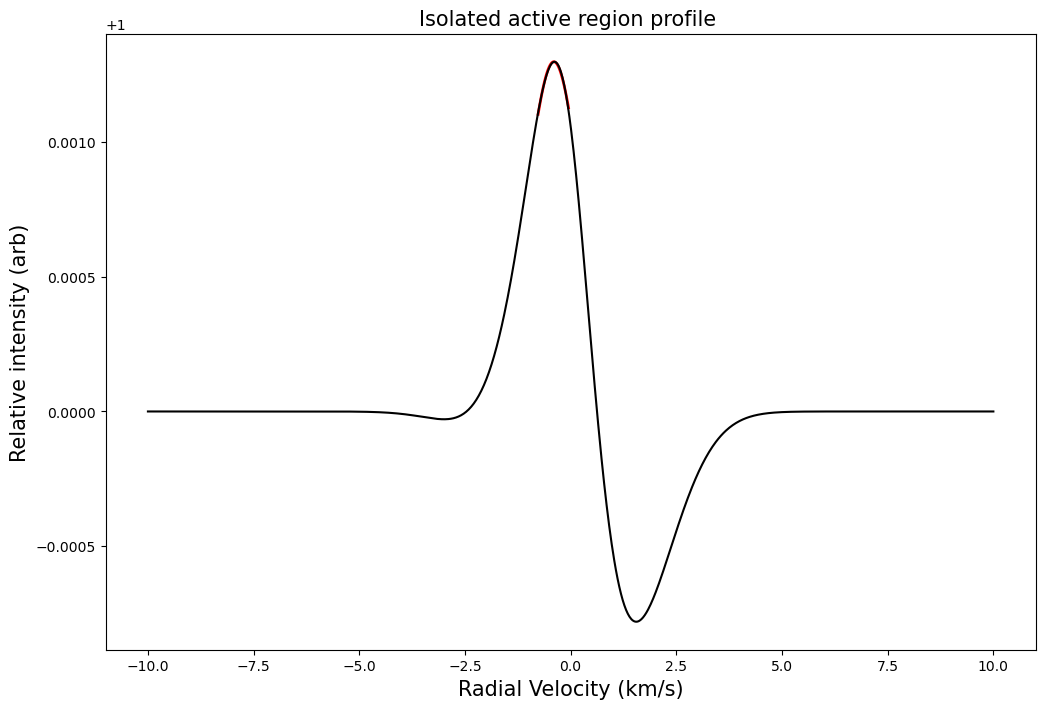

0.0012258338491488718 -0.41041041041041026 30 1
[ 8.48852630e-04 -4.27371095e-01  5.36809590e-01  1.00037730e+00]


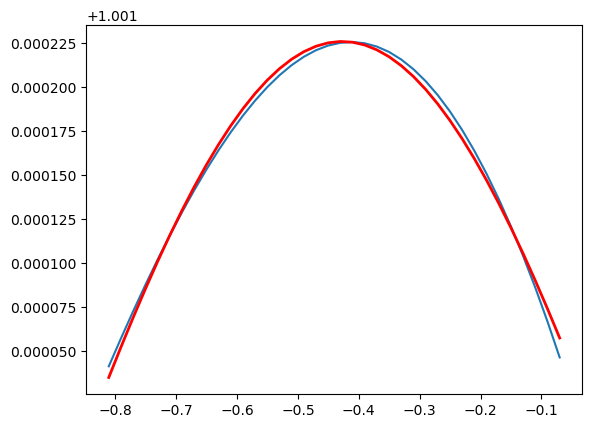

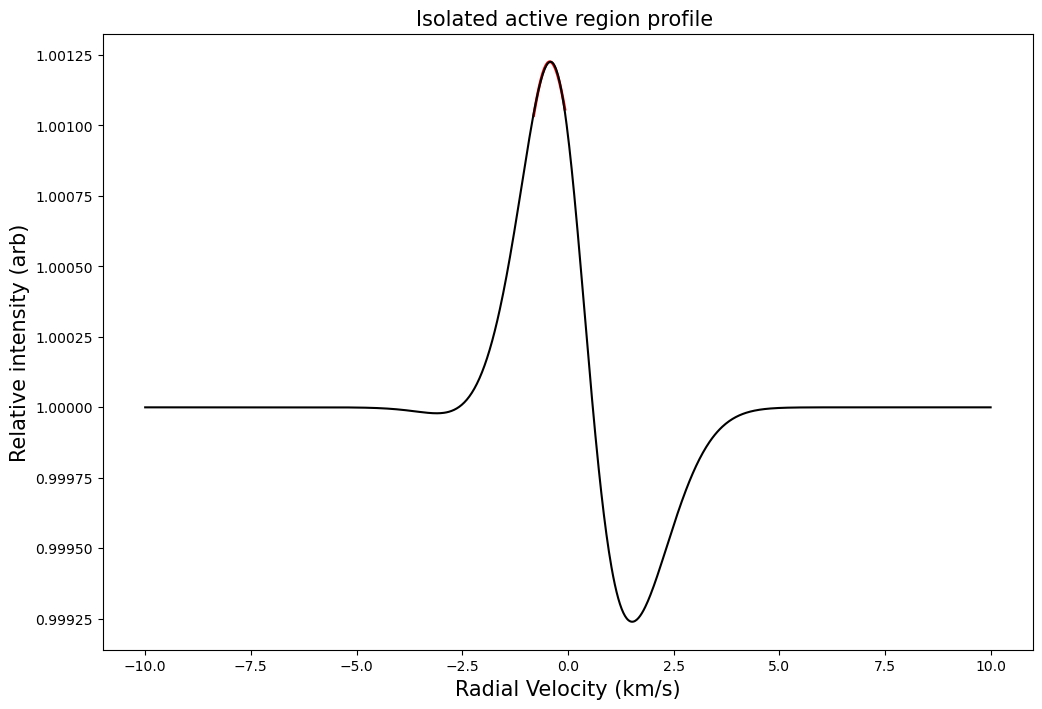

0.00117712952065685 -0.4504504504504503 30 1
[ 7.64834022e-04 -4.64302687e-01  5.22023433e-01  1.00041274e+00]


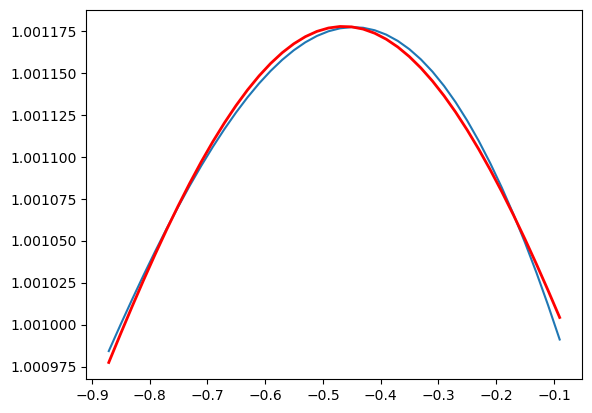

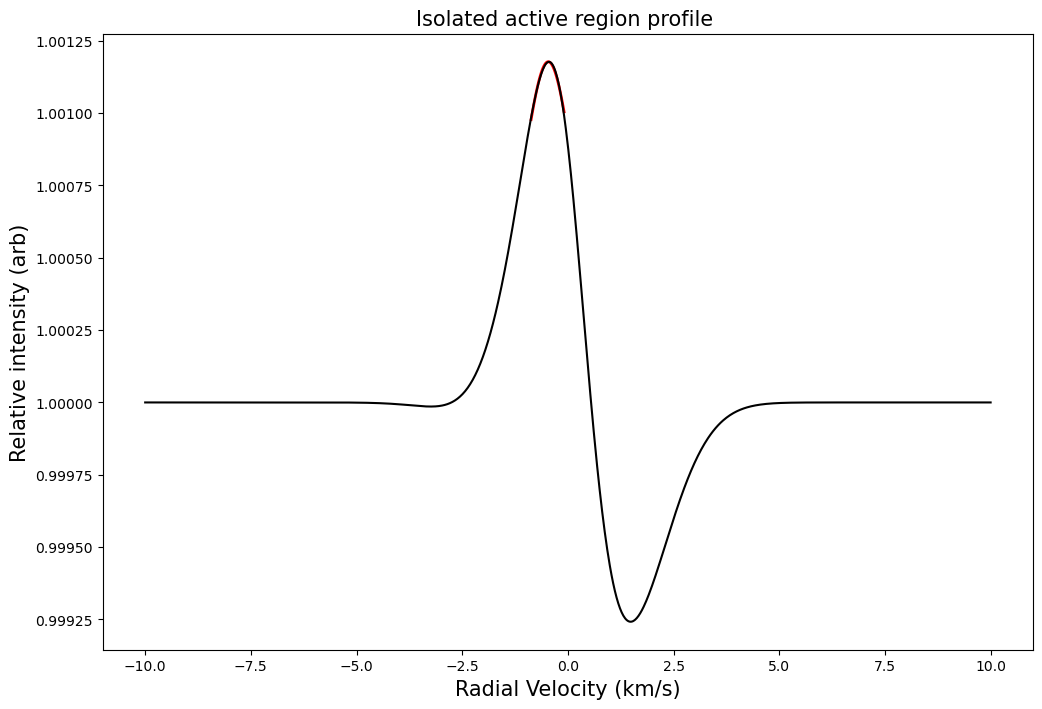

0.0011538370983414925 -0.4904904904904903 30 1
[ 0.00124087 -0.50546221  0.69161969  0.9999128 ]


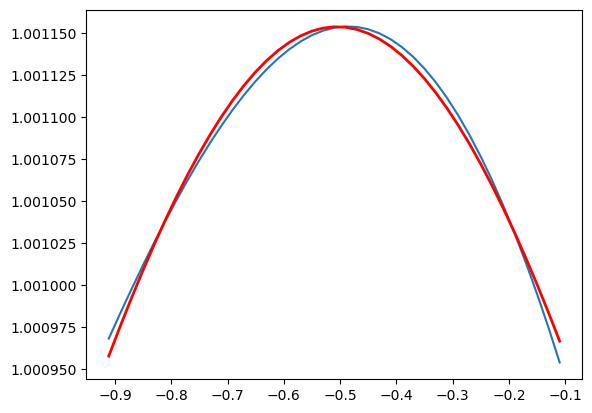

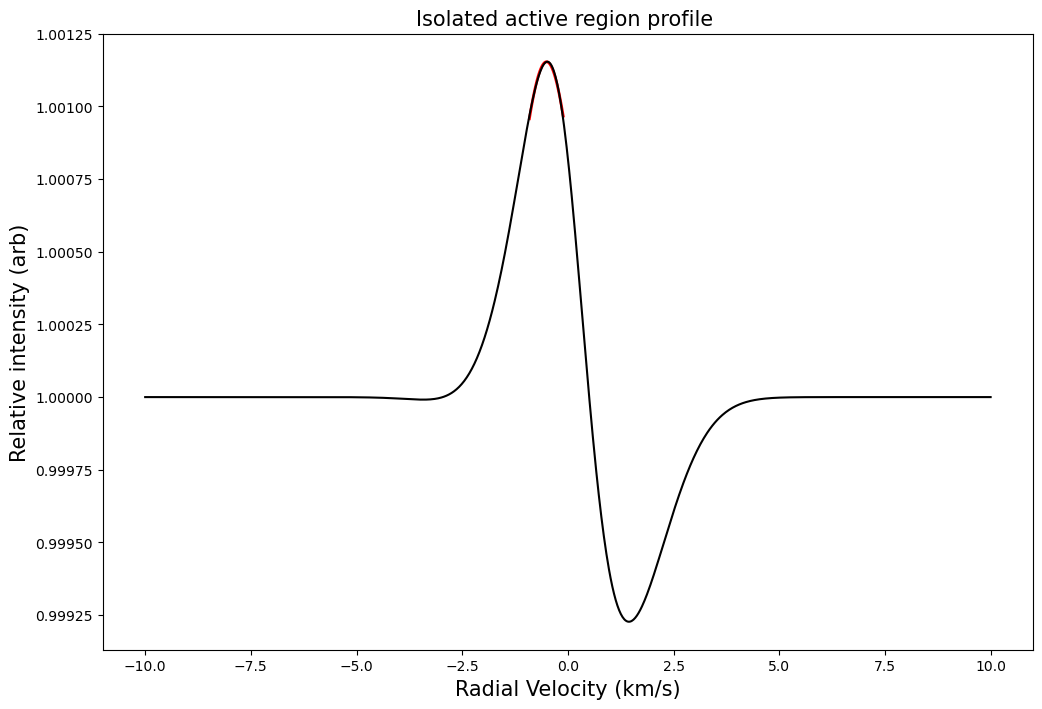

0.0011569415334533595 -0.5305305305305303 30 1
[ 8.35839536e-04 -5.47118932e-01  5.64043217e-01  1.00032138e+00]


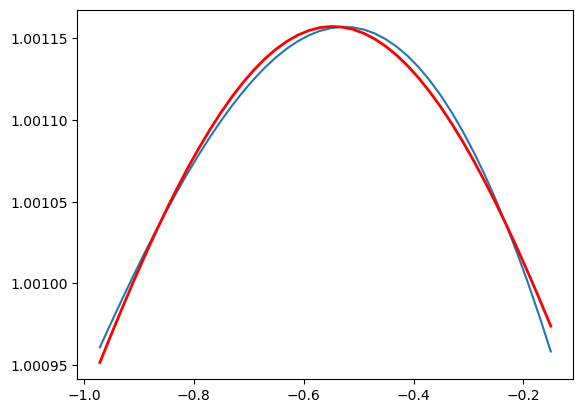

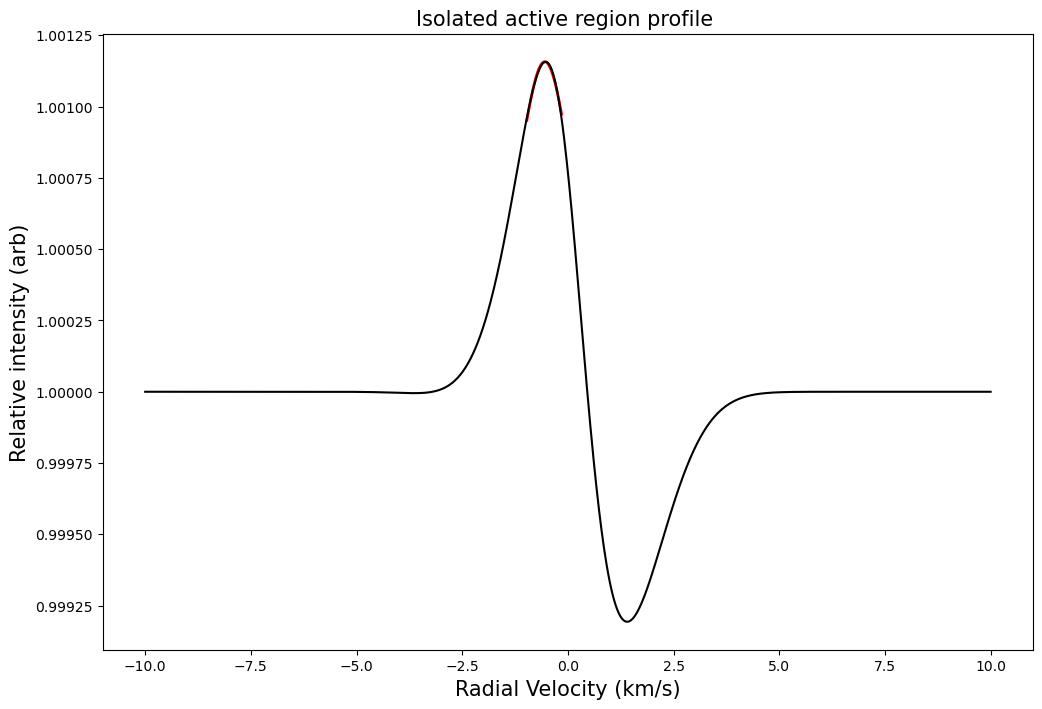

0.001187457245756418 -0.5705705705705704 30 1
[ 6.07000508e-04 -5.86287027e-01  4.71259739e-01  1.00058123e+00]


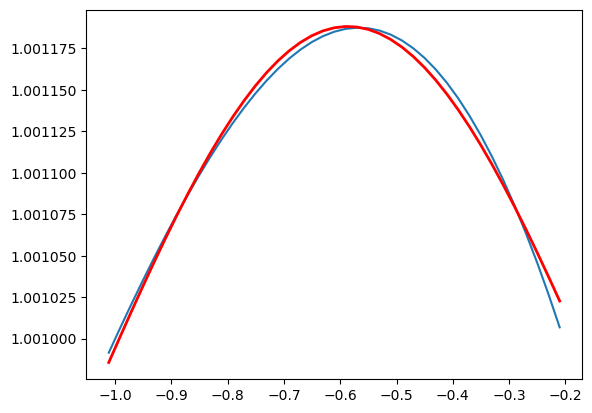

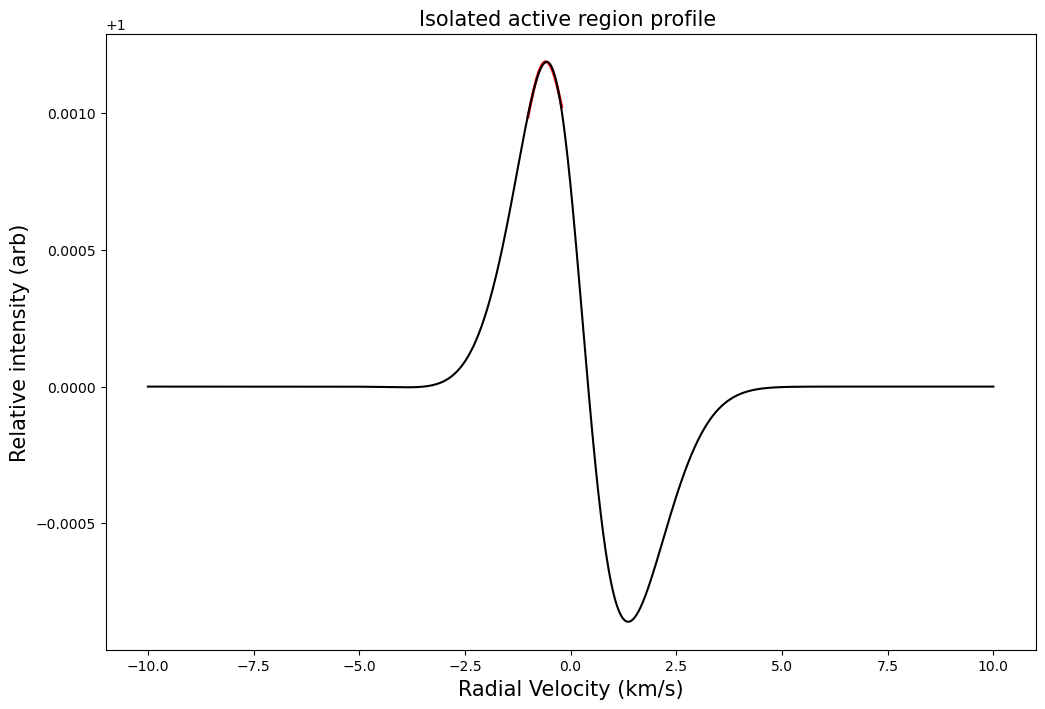

0.0012465124316030085 -0.6106106106106104 30 1
[ 7.92660060e-04 -6.26212533e-01  5.38431497e-01  1.00045422e+00]


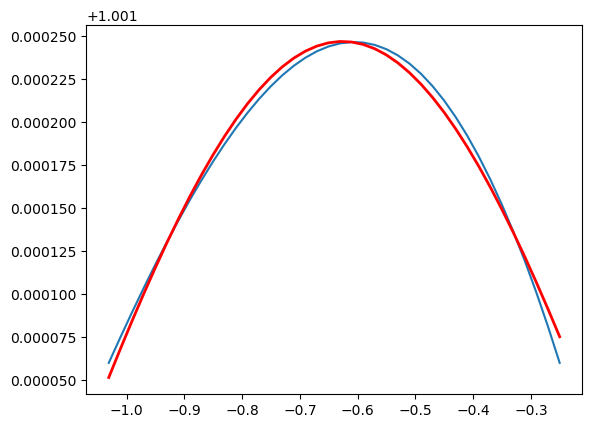

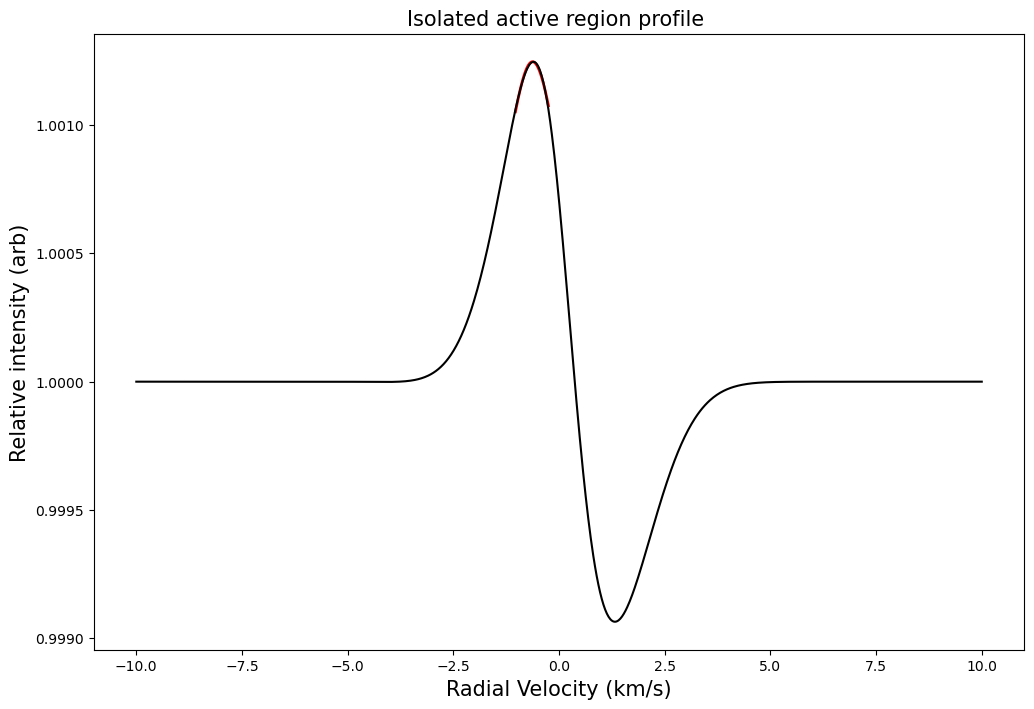

0.0013351666919219074 -0.6506506506506504 30 1
[ 7.58403654e-04 -6.63507127e-01  5.11250177e-01  1.00057735e+00]


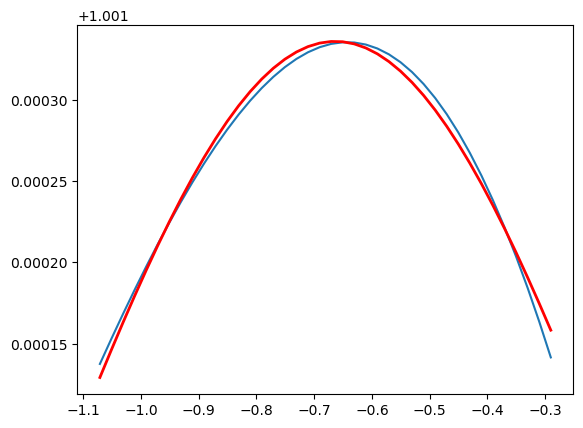

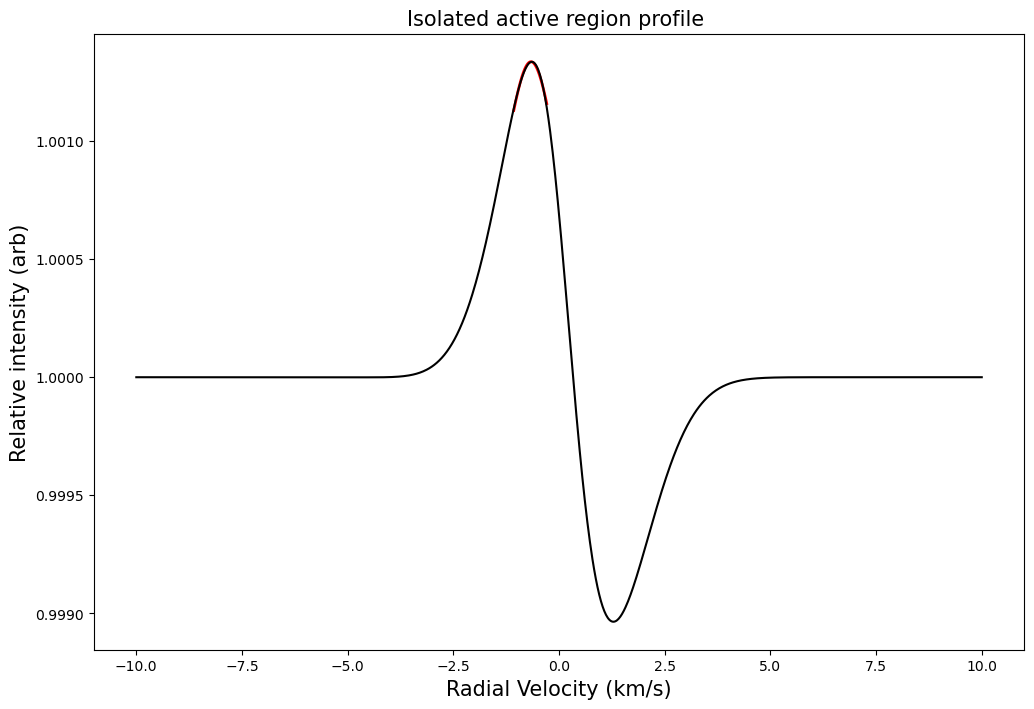

0.001454211205149436 -0.6706706706706704 30 1
[ 6.13290902e-04 -6.95074002e-01  4.38744921e-01  1.00084185e+00]


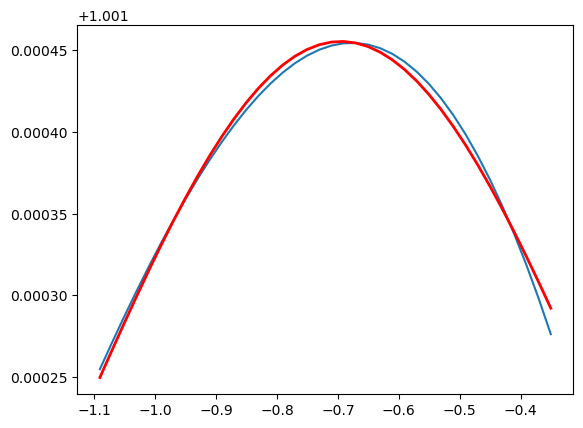

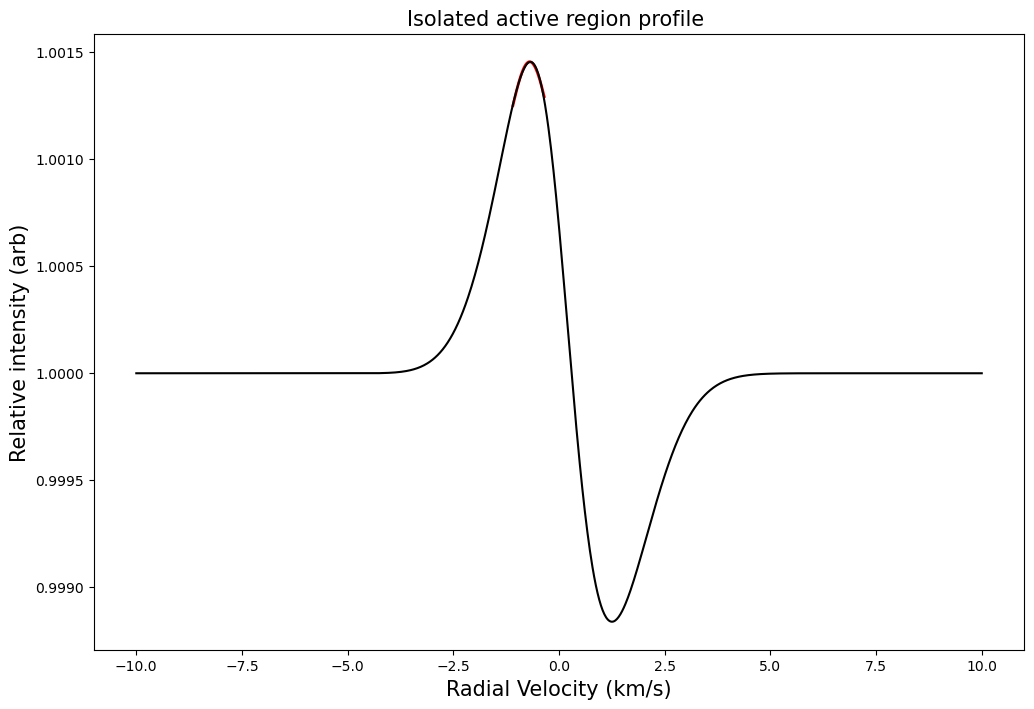

0.0016033496563867544 -0.7107107107107105 30 1
[ 8.11072799e-04 -7.25256676e-01  4.90802448e-01  1.00079278e+00]


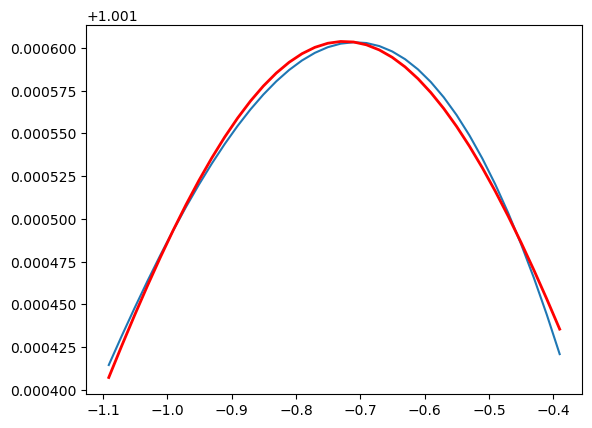

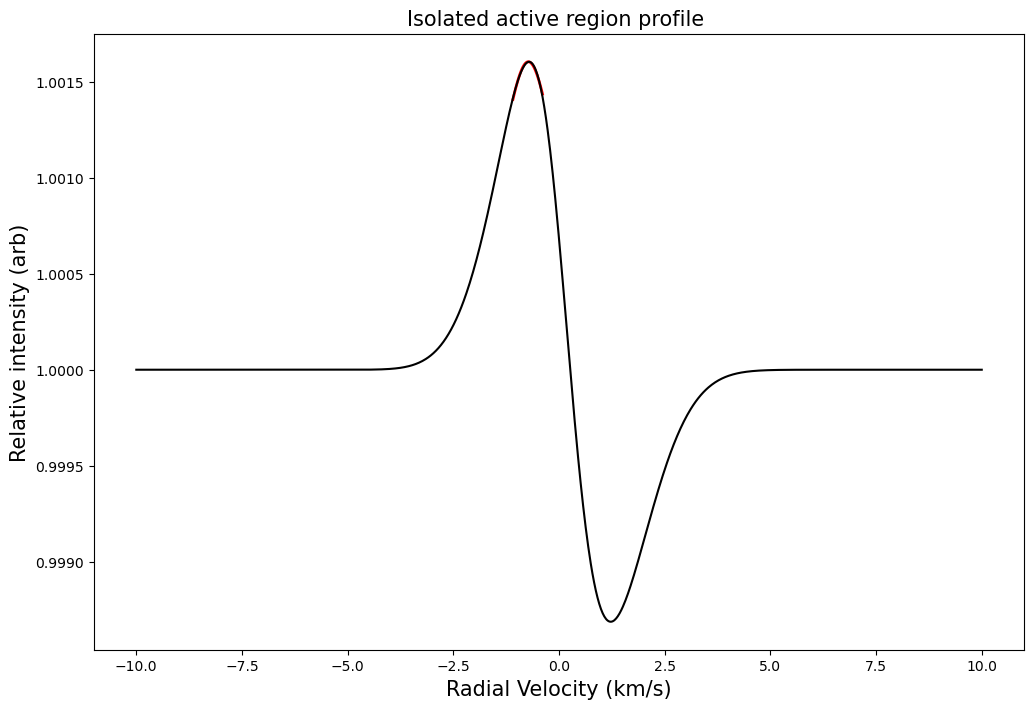

0.0017808830586083513 -0.7307307307307305 30 1
[ 0.0011125  -0.7510987   0.55494049  1.0006686 ]


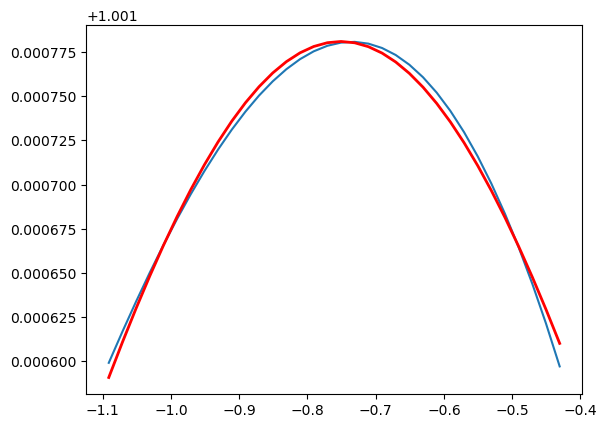

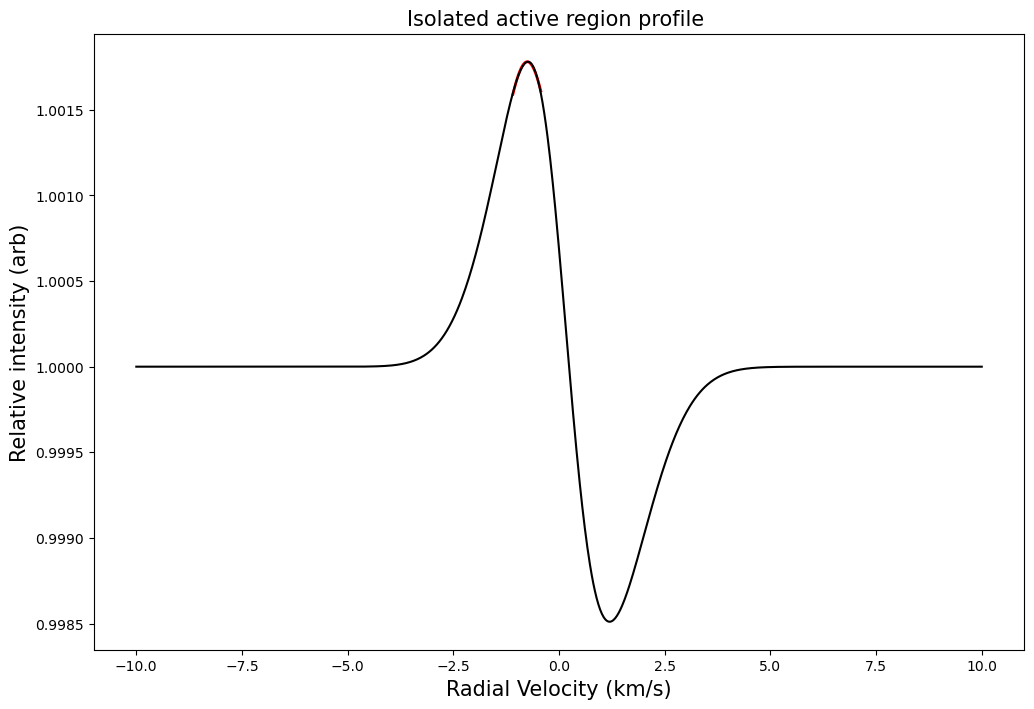

0.0019834164565408763 -0.7507507507507505 30 1
[ 7.81920824e-04 -7.72486435e-01  4.36136630e-01  1.00120228e+00]


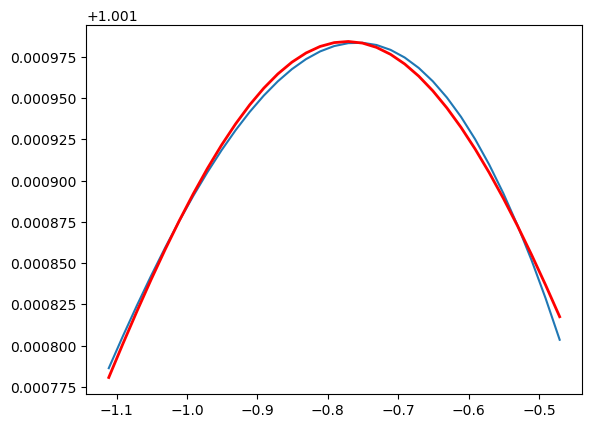

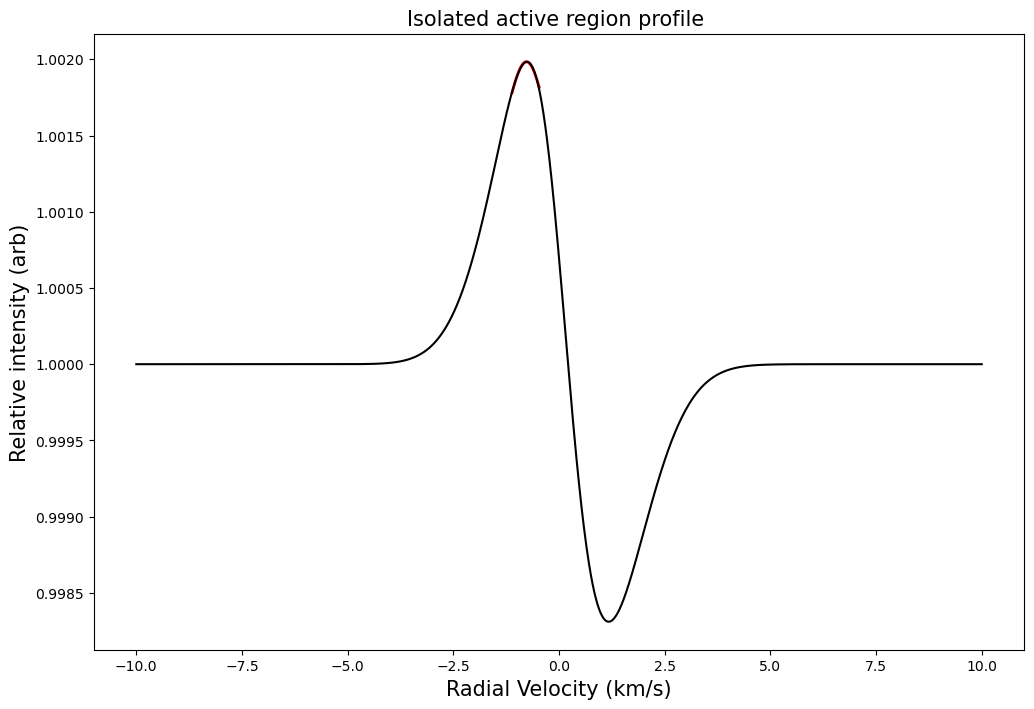

0.0022057119912968215 -0.7707707707707705 30 1
[ 0.00124166 -0.79112099  0.53162312  1.00096438]


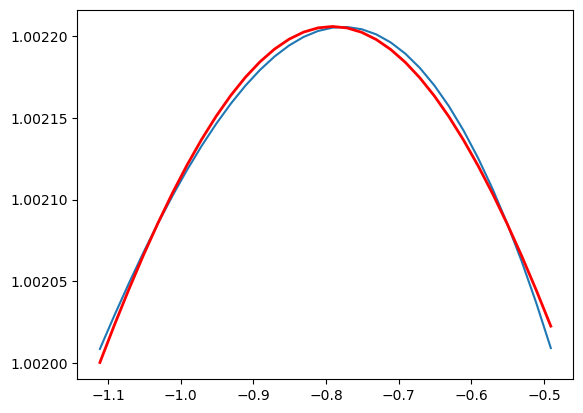

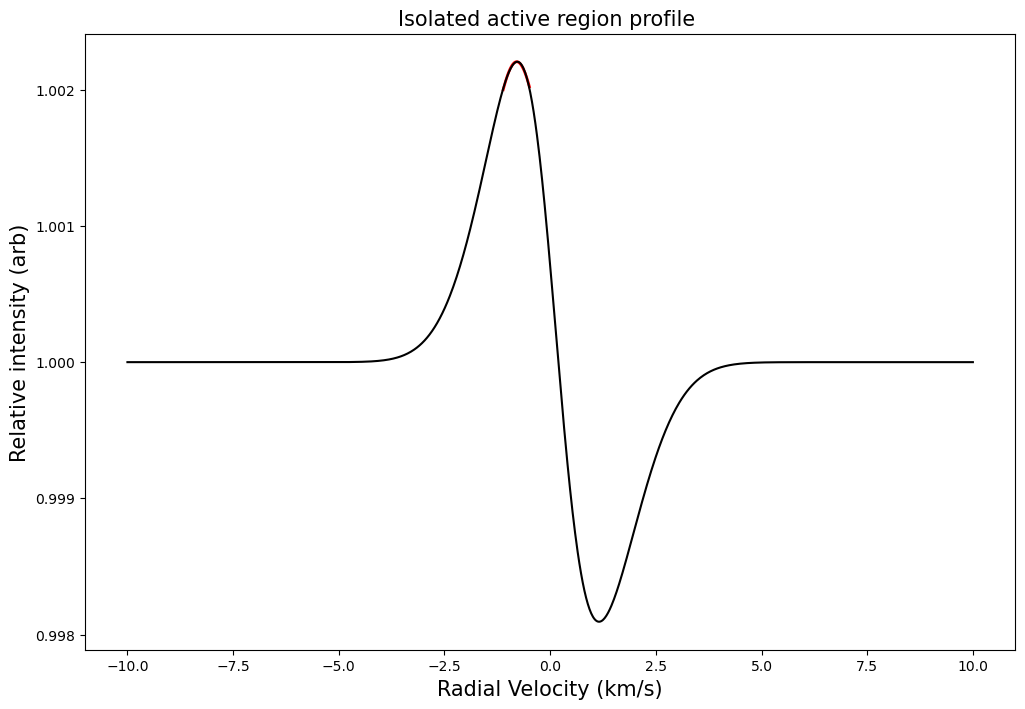

0.002440392415533177 -0.7907907907907905 30 1
[ 0.00133904 -0.8027603   0.52767793  1.00110156]


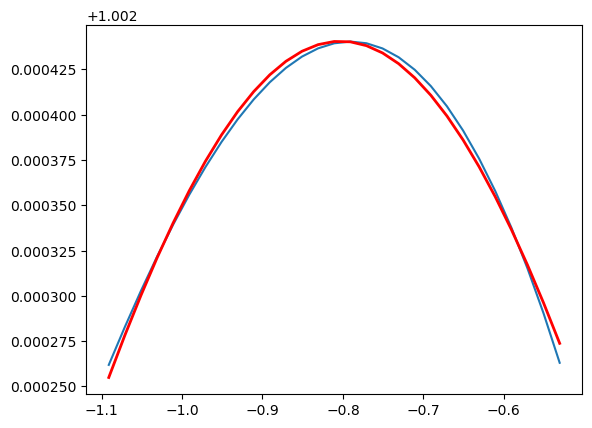

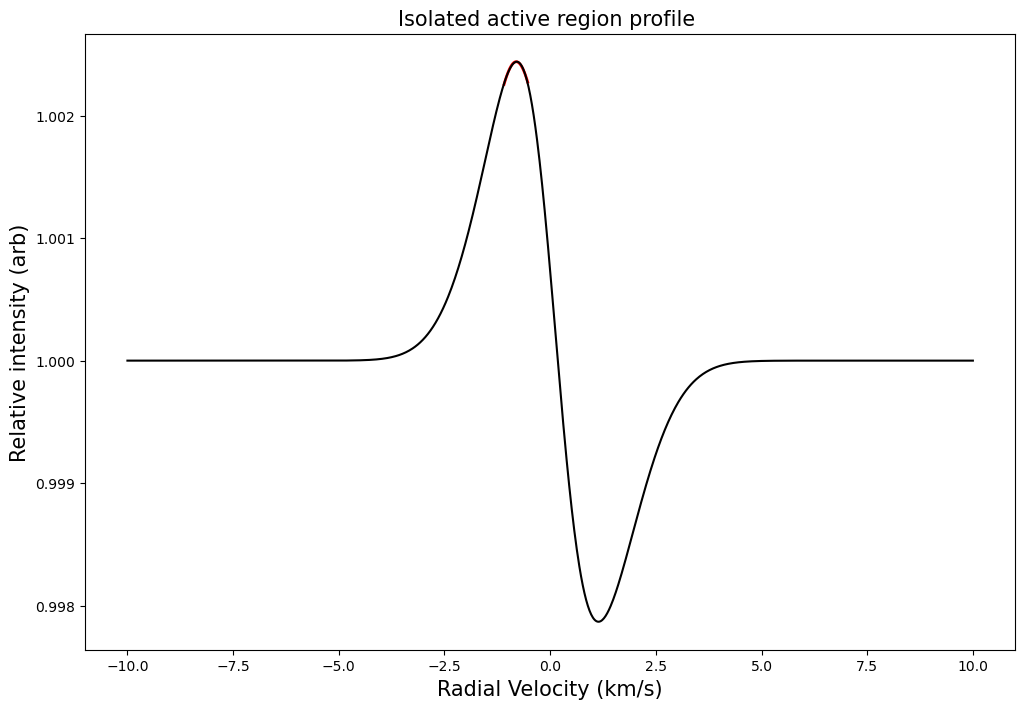

0.0026781419969710285 -0.7907907907907905 30 1
[ 0.00122053 -0.81124888  0.48005653  1.00145816]


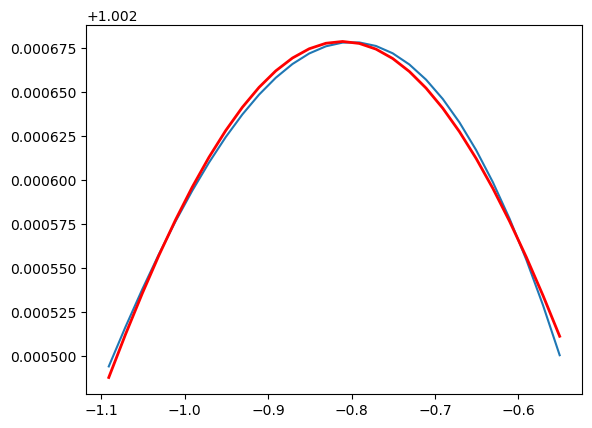

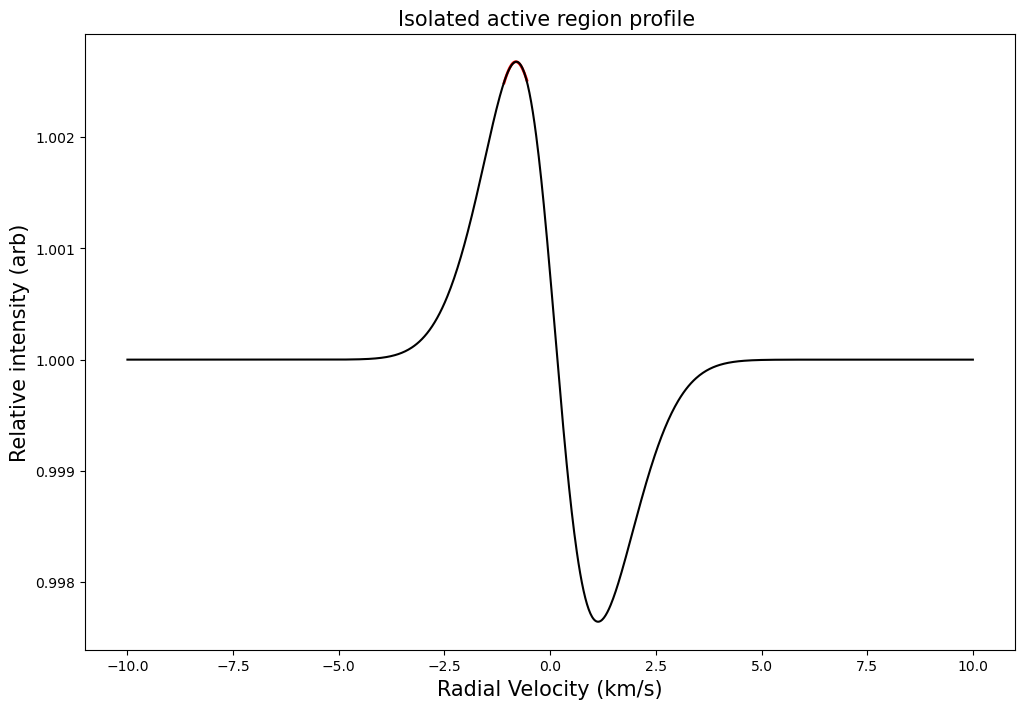

0.0029094257038710936 -0.8108108108108105 30 1
[ 8.83134758e-04 -8.14470196e-01  3.87560802e-01  1.00202708e+00]


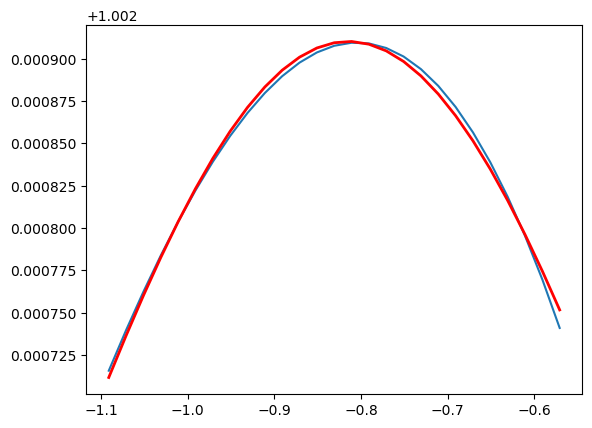

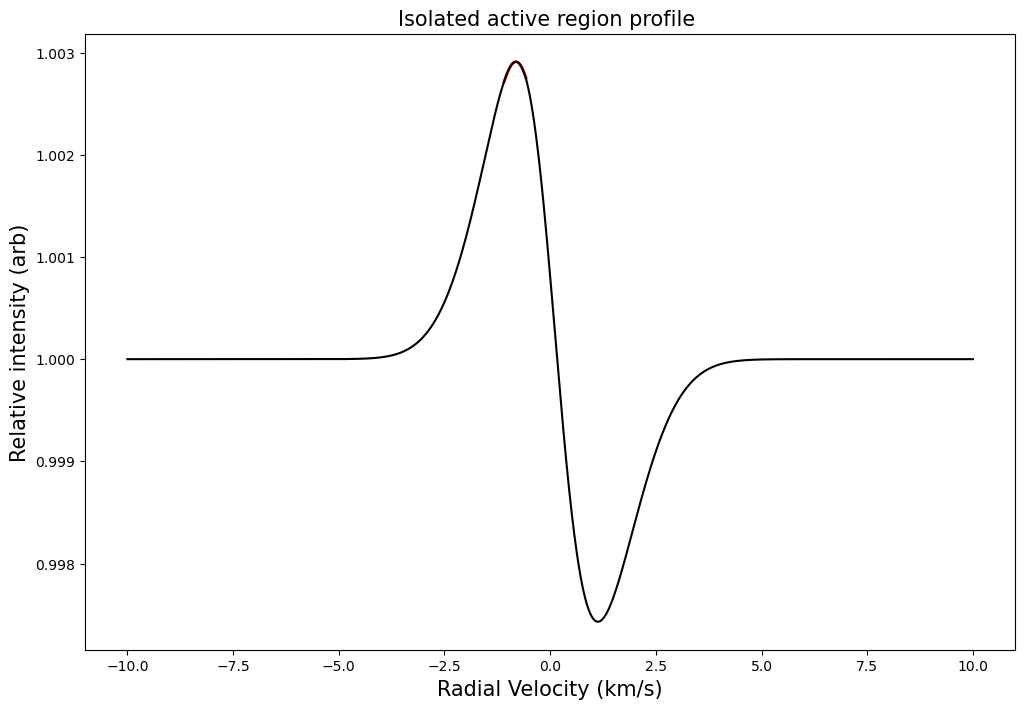

0.003123204972754534 -0.8108108108108105 30 1
[ 0.00162416 -0.8140221   0.51600222  1.00149938]


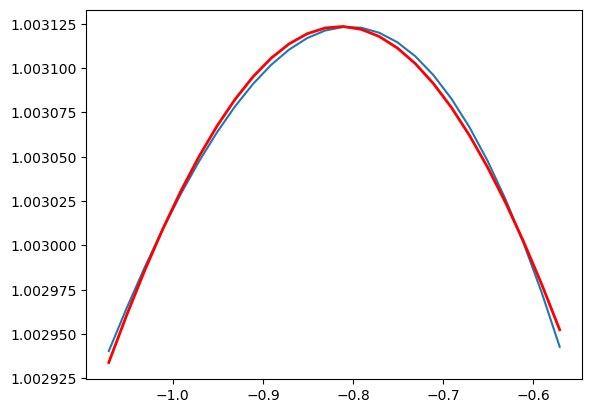

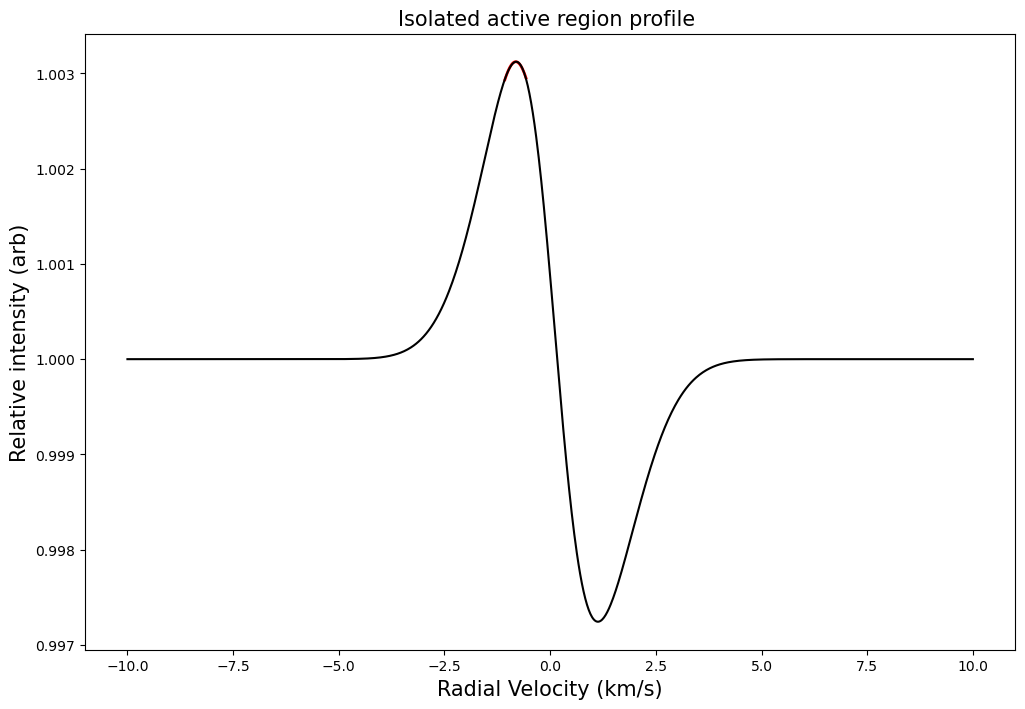

0.0033093141118858416 -0.7907907907907905 30 1
[ 0.00321828 -0.80811509  0.71173778  1.00009115]


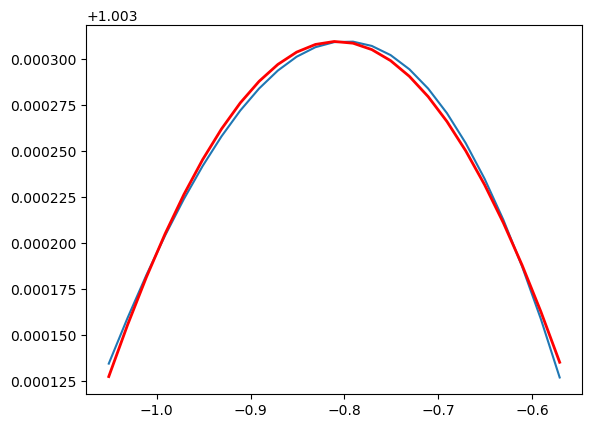

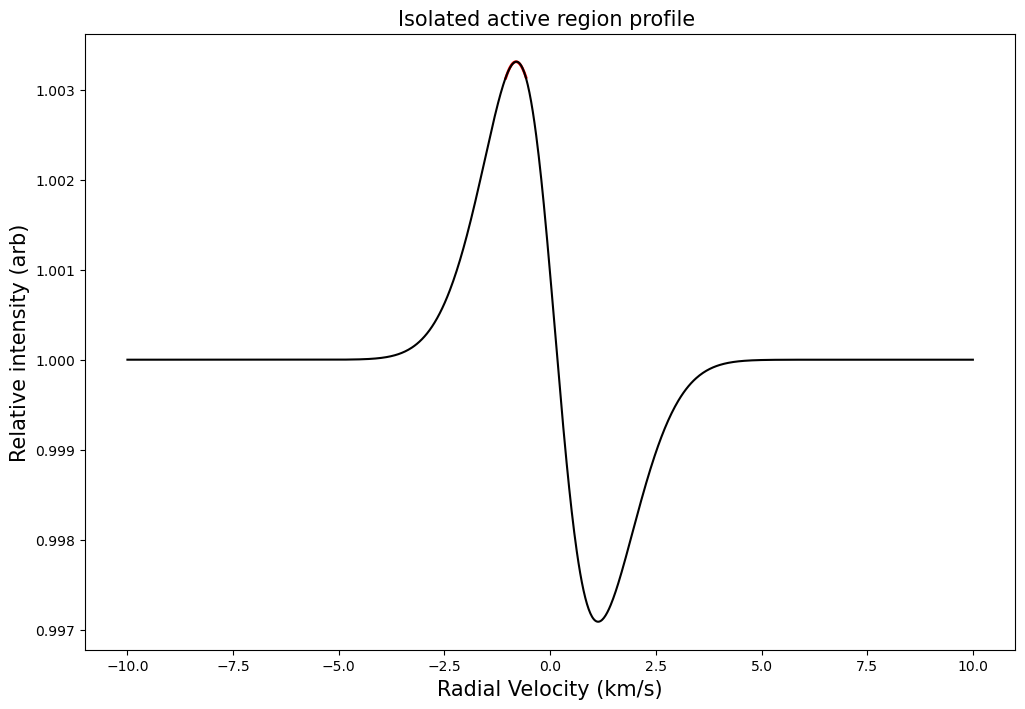

0.003458983514998293 -0.7907907907907905 30 1
[ 0.0010435  -0.79717903  0.38618617  1.00241611]


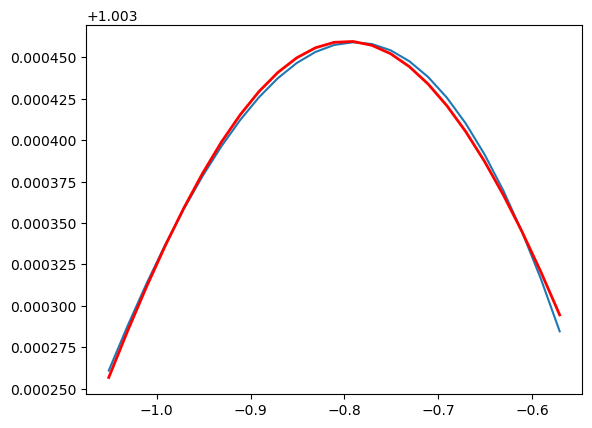

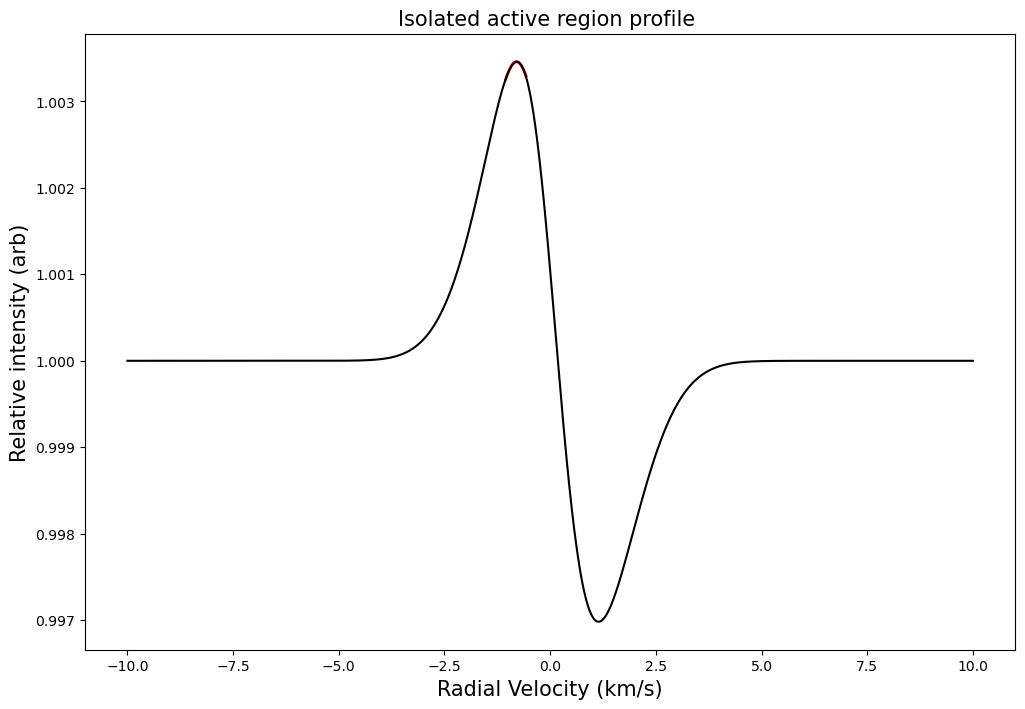

0.003564631848508526 -0.7707707707707705 30 1
[ 0.001506   -0.78242933  0.45973821  1.002059  ]


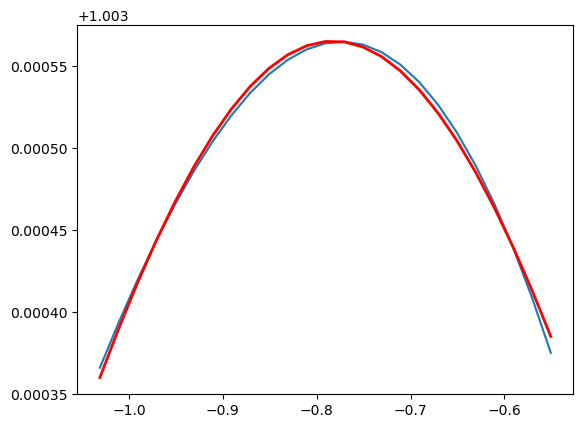

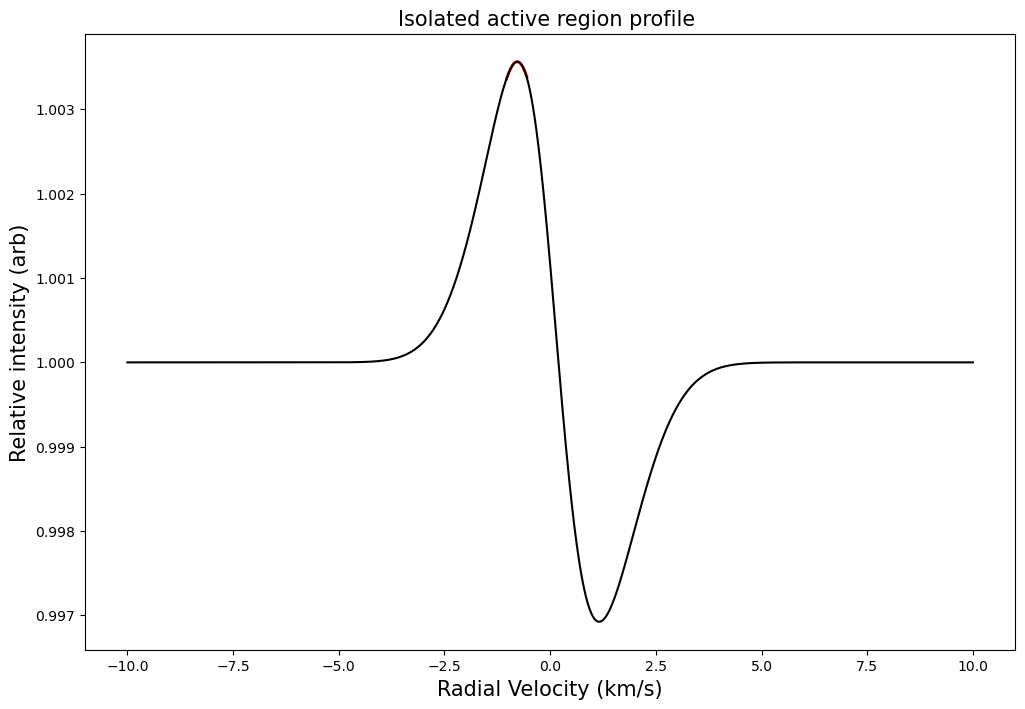

0.003621863640952405 -0.7507507507507505 30 1
[ 0.0303194  -0.76224421  2.08190598  0.9733022 ]


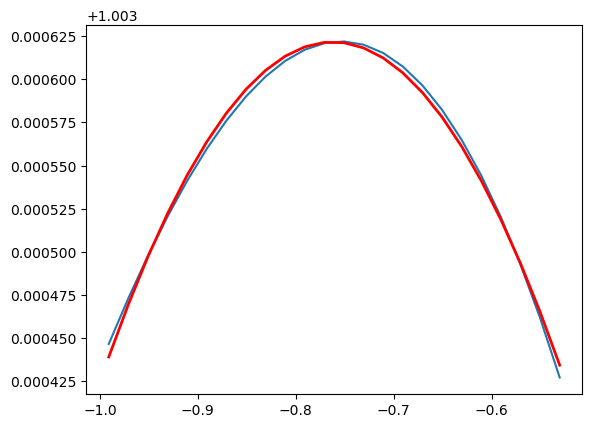

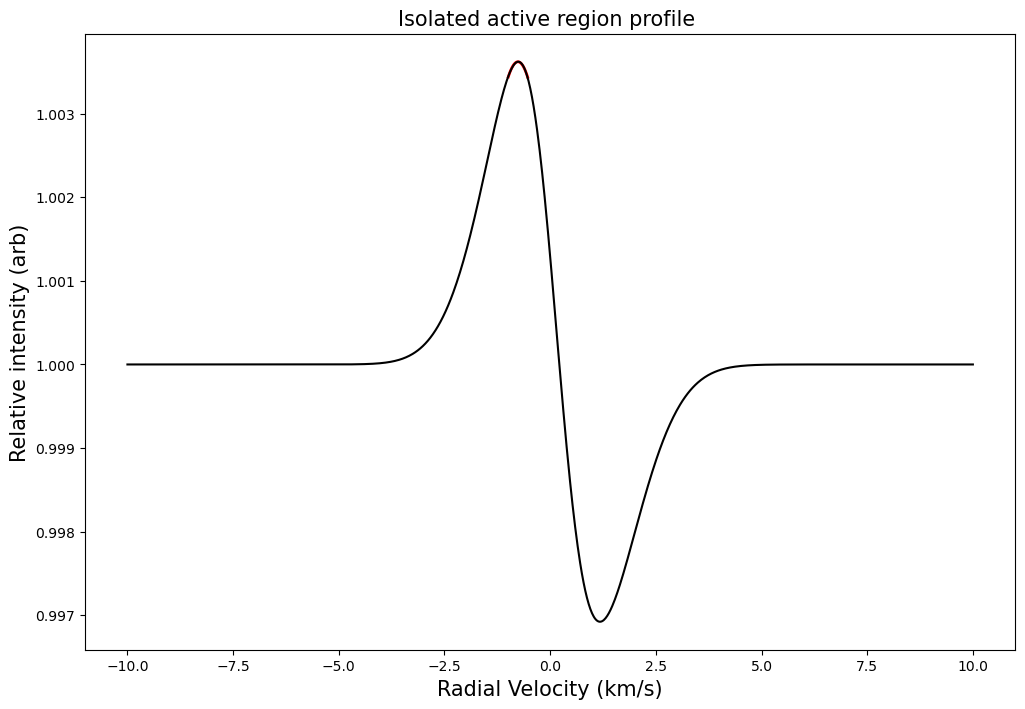

0.0036290306692372543 -0.7307307307307305 30 1
[ 0.00308205 -0.73785469  0.65290018  1.00054696]


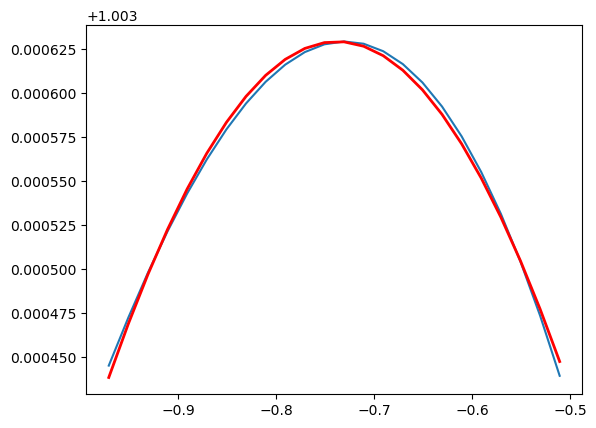

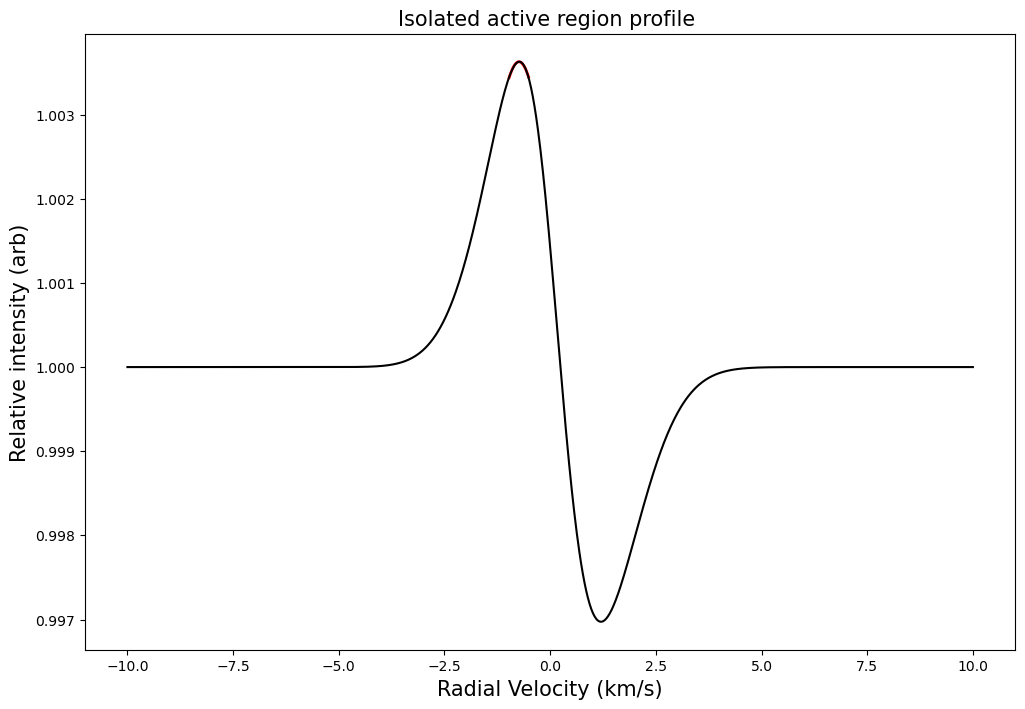

0.0035870642491120375 -0.7107107107107105 30 1
[ 0.00116154 -0.70885944  0.39280838  1.00242638]


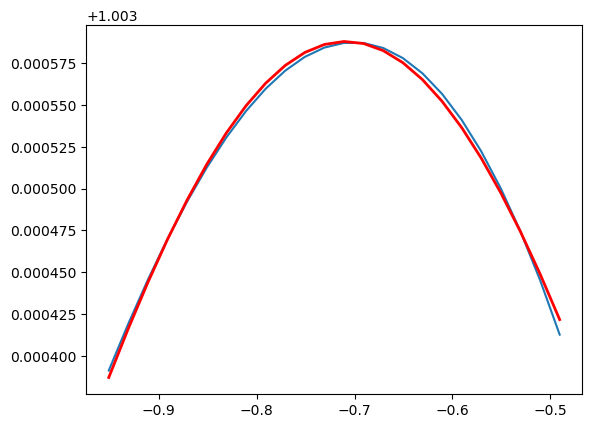

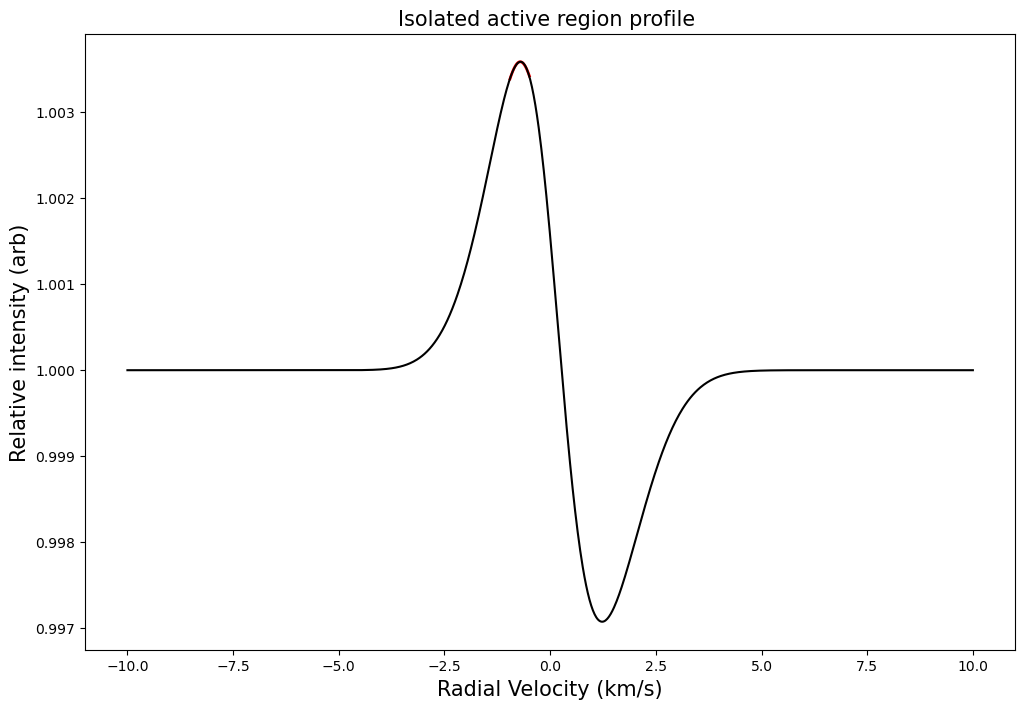

0.003501053182153102 -0.6706706706706704 30 1
[ 0.00254897 -0.67697911  0.59434587  1.00095212]


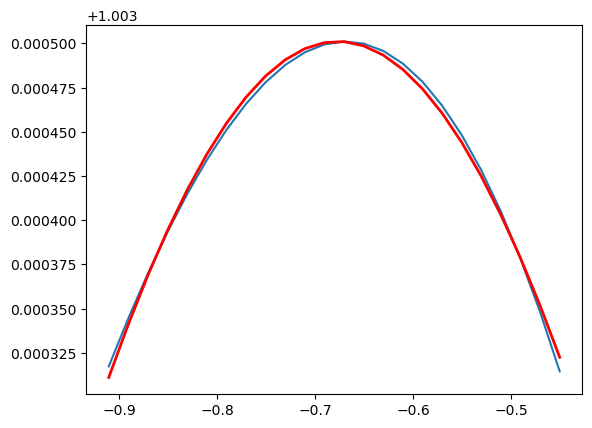

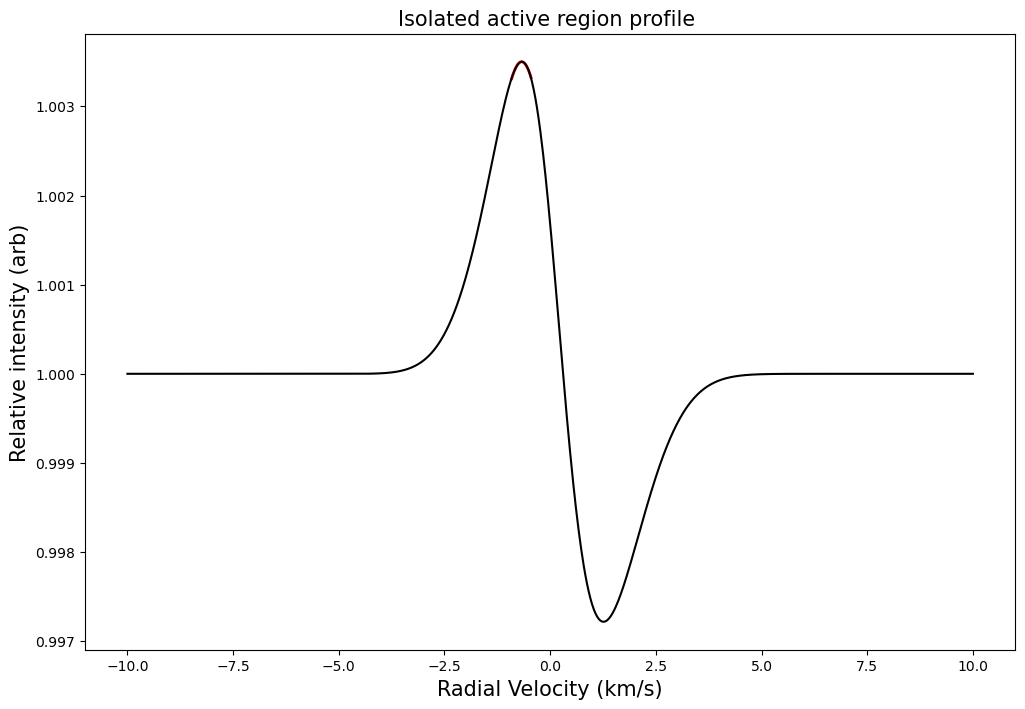

0.003376335067387437 -0.6306306306306304 30 1
[ 0.00993914 -0.64144523  1.1967179   0.99343697]


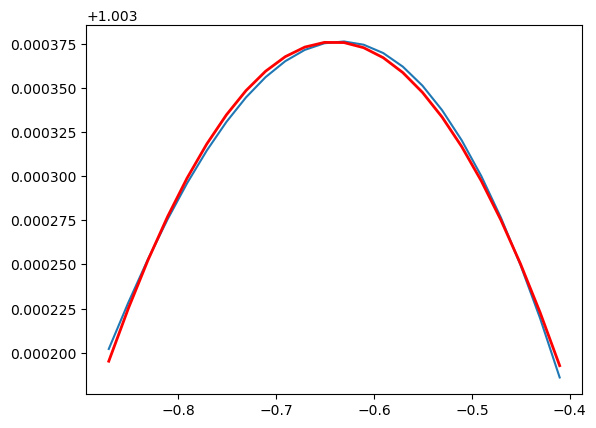

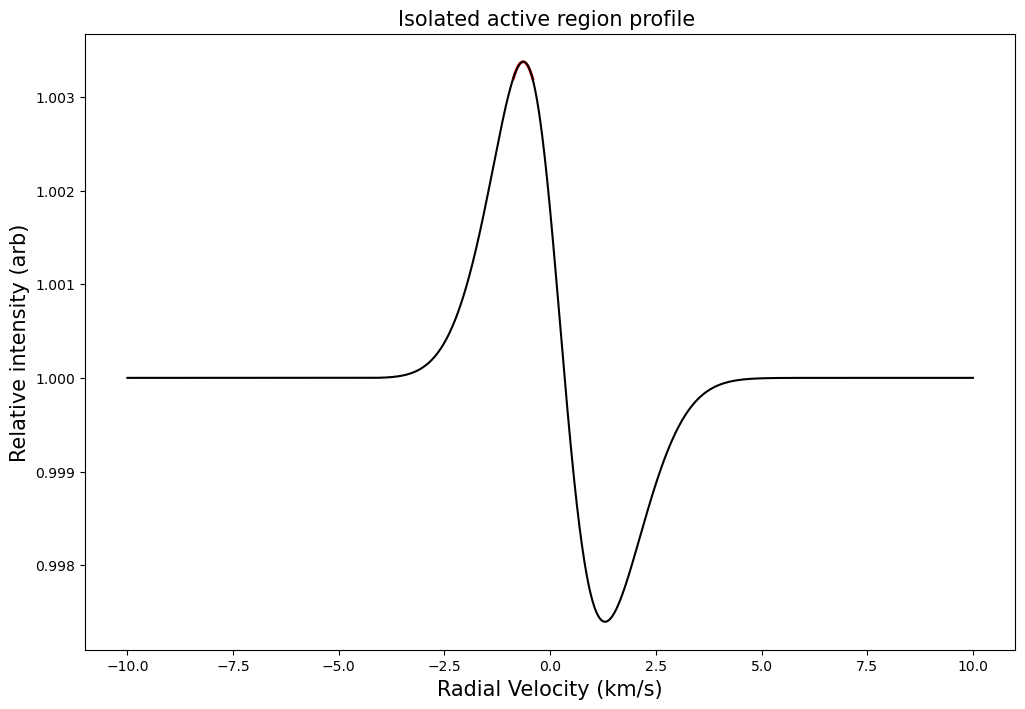

0.0032210441138340595 -0.5905905905905904 30 1
[ 0.00166558 -0.60362496  0.48844918  1.00155579]


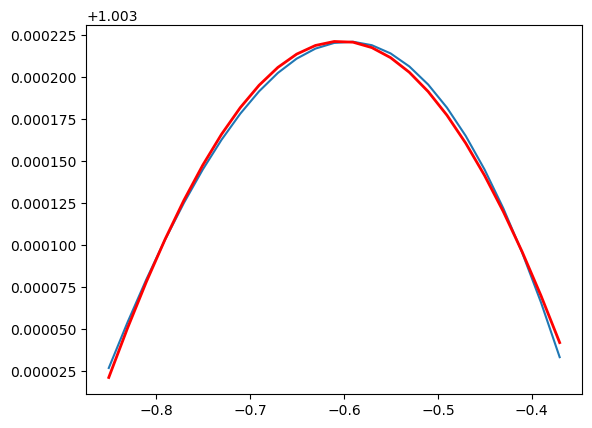

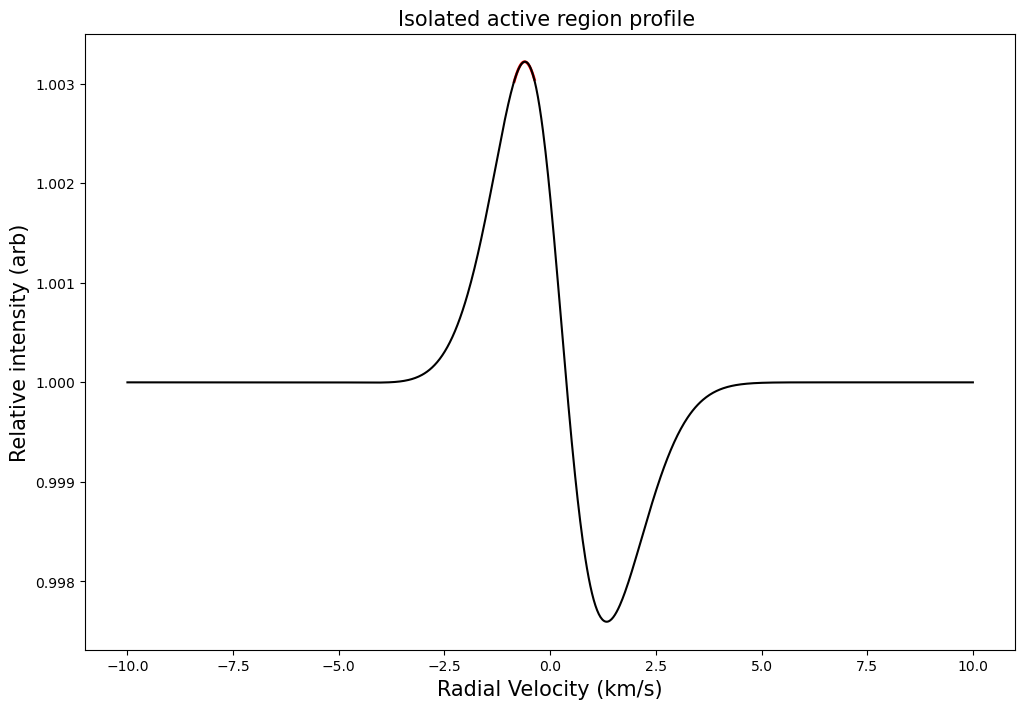

0.003043717625026643 -0.5505505505505504 30 1
[ 0.00162438 -0.56369864  0.49157256  1.00141966]


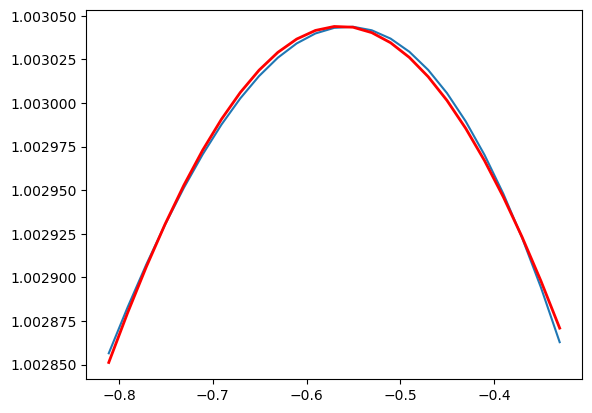

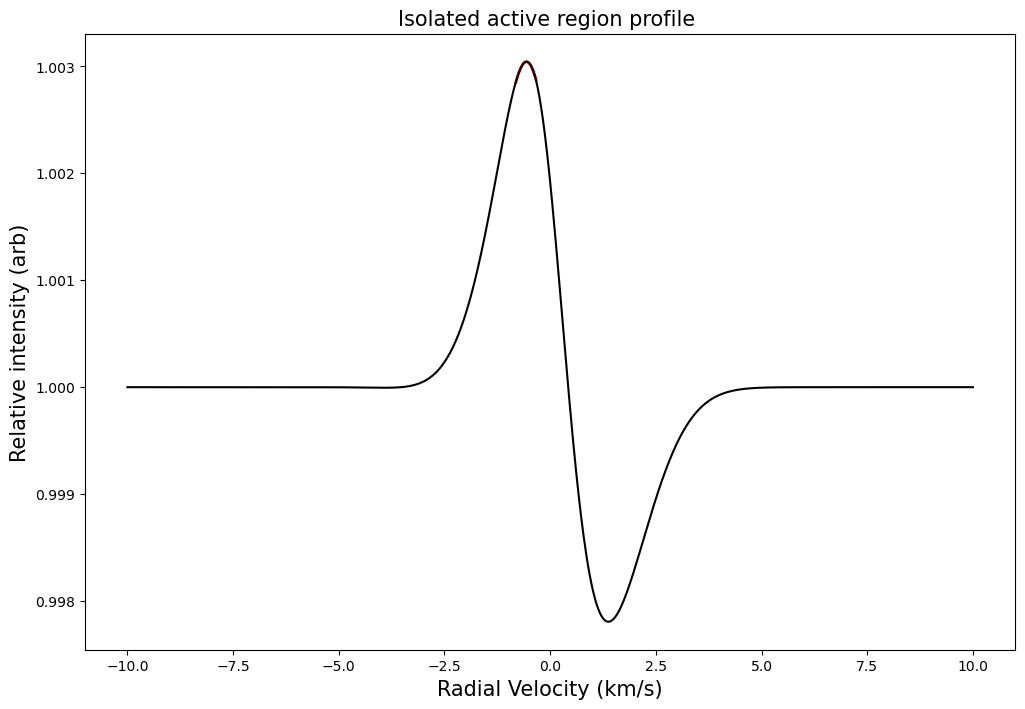

0.0028525724867465296 -0.5105105105105103 30 1
[ 0.001501   -0.52322158  0.48300371  1.00135189]


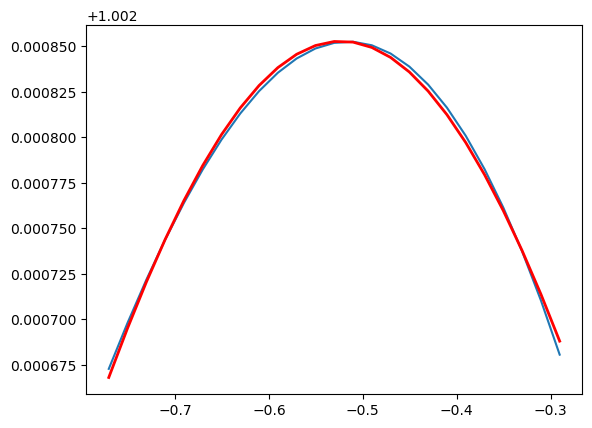

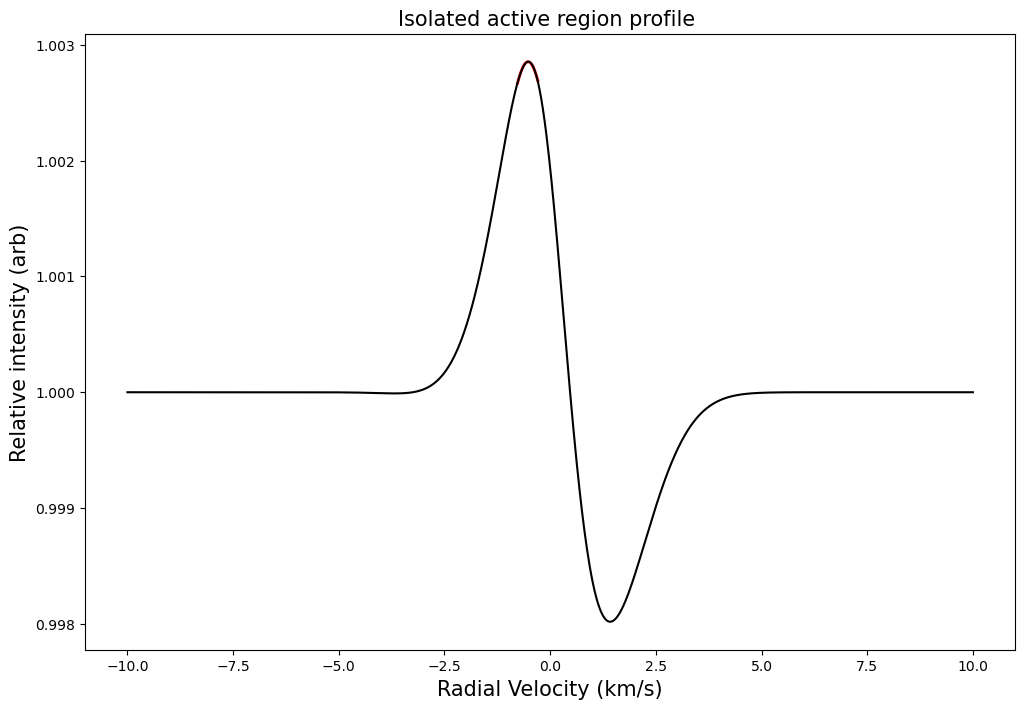

0.002654903765452188 -0.4704704704704703 30 1
[ 0.001852   -0.48493813  0.55326018  1.00080313]


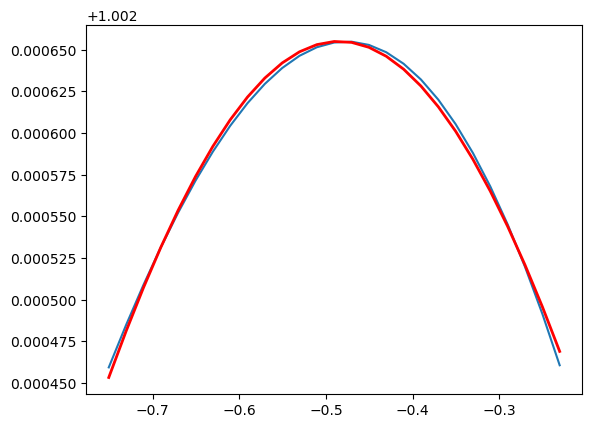

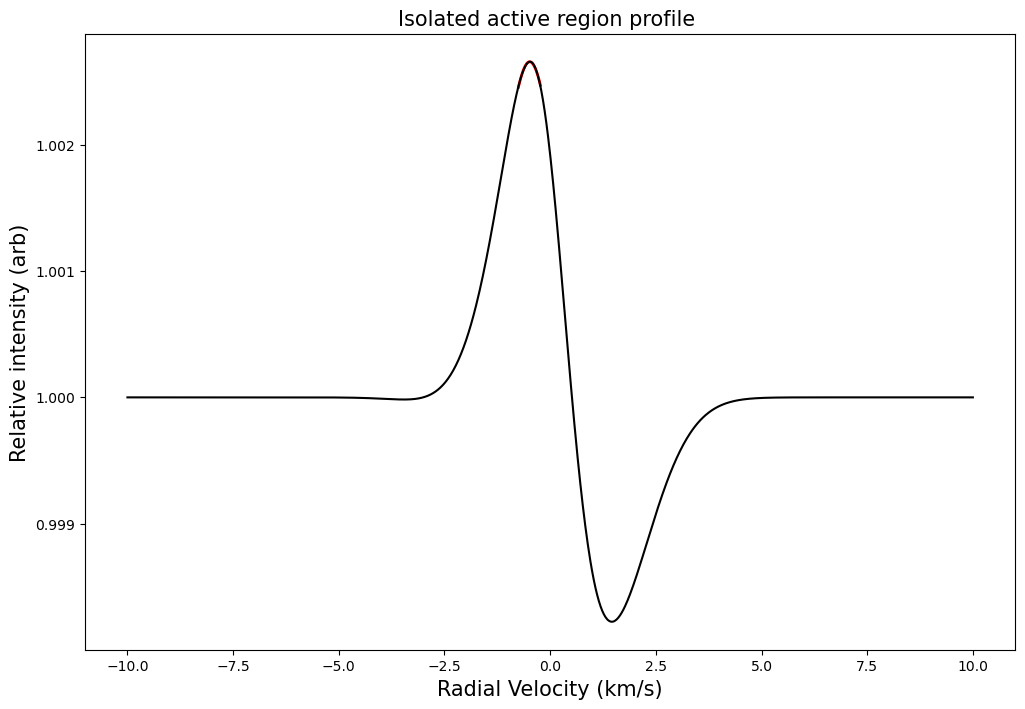

0.0024566697003427507 -0.4304304304304303 30 1
[ 0.00241339 -0.44784311  0.65440184  1.00004348]


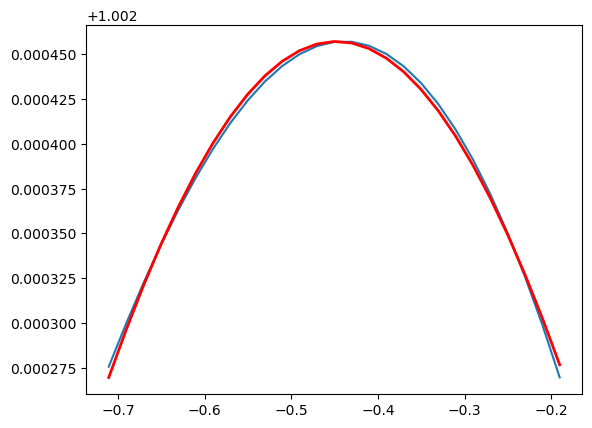

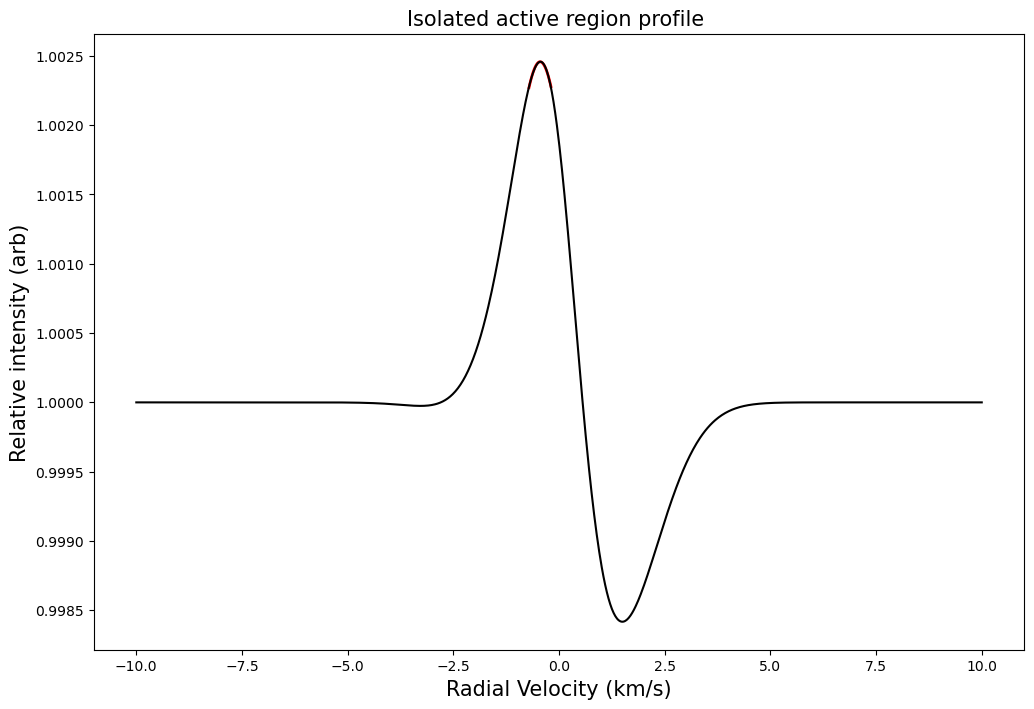

0.002263001821360522 -0.41041041041041026 30 1
[ 0.00175159 -0.41529503  0.57379298  1.00051153]


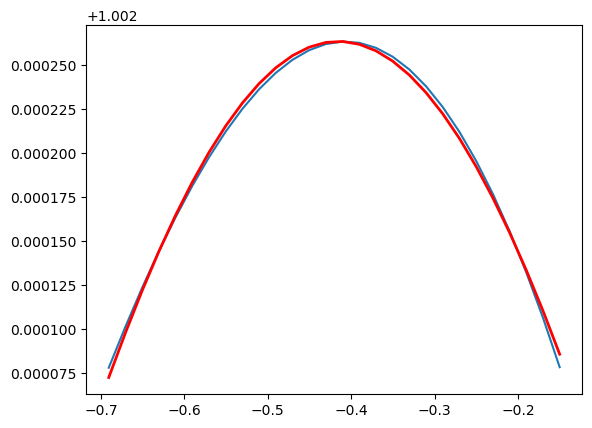

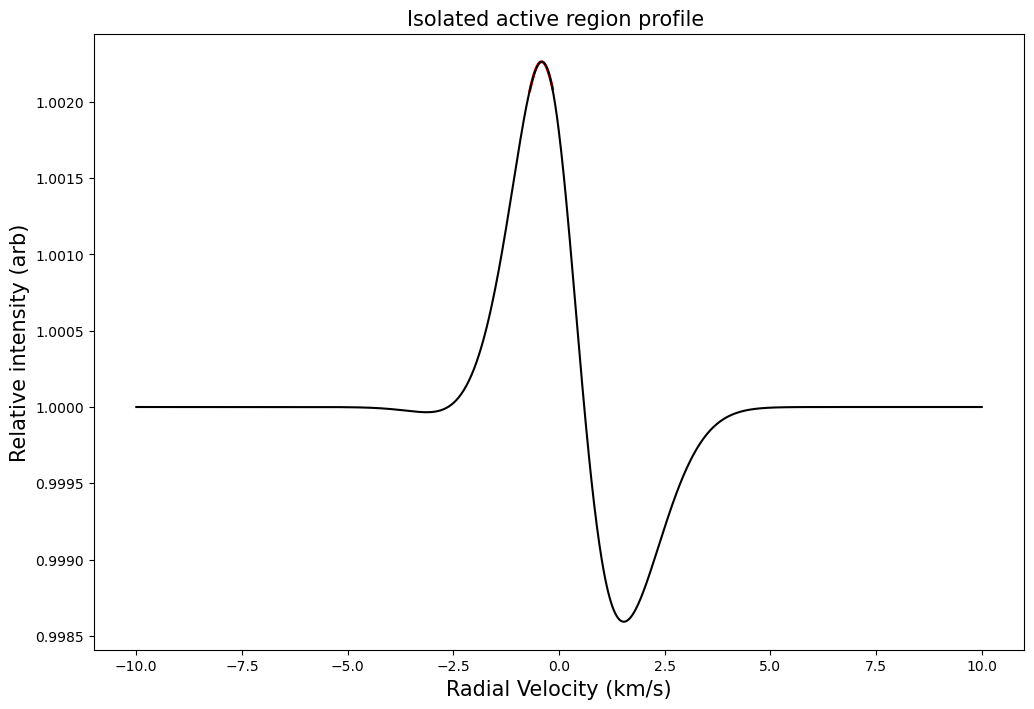

82 48


ValueError: x and y must have same first dimension, but have shapes (0,) and (48,)

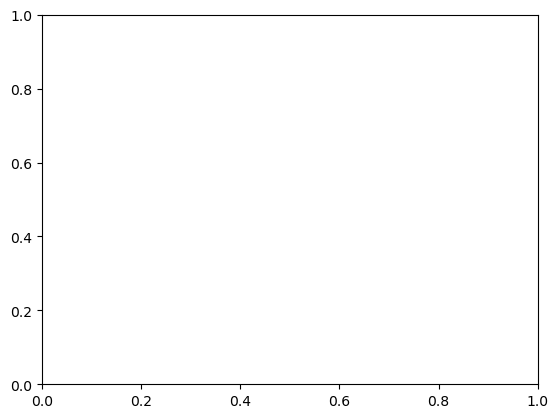

In [10]:
import scipy
from scipy.optimize import curve_fit
from astropy.modeling import models, fitting

''' This cell uses the previously derived active and inactive profile arrays to create a reference array - comparing the both cases
    This allows for a direct analysis of what contribution the active region has on the radial velocity measurements from the star
             -> By plotting the reference profile and fitting to it a gaussian curve, we can extract the radial velocity value of the
                active region as it moves across the surface (throughout the phases) from the properties of the fitted curve
              -> Storing these in arrays representing the particular 48 day 'selective' recorded period and the total 81 day duration period,
                 We can plot both to see how the contribution to radial velocity measurements from a given active region varies with time
'''



'creating active vs inactive reference profile'
ref_profile_full = []; rot_ref_profile_full=[];
ref_profile_selective = []; rot_ref_profile_selective=[];
day = data['jdb']-55278                                      # Loading in the days from the HARPS 2017 Alpha Cen b data and converting from Julian days
plt.style.use('default')                                     # Changing back to a white graph background

for i in range(len(active_gaussian_full)):        # Comparison for the full 81 day sample duration
    for j in range(len(rv_values)):
        ref_profile_full.append(active_gaussian_full_norm[i][j] / inactive_gaussian_full_norm[i][j])    # Comparing gaussian intensity profiles at each rv bin (interval) between active vs inactive
    rot_ref_profile_full.append(ref_profile_full)           # Appending the difference between the two at each interval in a new array of equal size
    ref_profile_full = []
    
for i in range(len(active_gaussian_selective)):   # Comparison for the selective 48 day (recorded) sample values
    for j in range(len(rv_values)):
        ref_profile_selective.append(active_gaussian_selective_norm[i][j] / inactive_gaussian_selective_norm[i][j])
    rot_ref_profile_selective.append(ref_profile_selective)
    ref_profile_selective = []

'''Used to quickly plot reference profile array as a test - to find where the positive peak lies'''
'''for i in range(n_phase):
    plt.figure(figsize=(12,8))
    plt.plot(rv_values,rot_ref_profile_full[i])
    #print(rv_values[np.argmax(inactive_gaussian_full[i])])
    plt.ylim(0.999,1.001)
    plt.xlabel('Radial Velocity (km/s)', size = 15)
    plt.ylabel('Normalised Flux (arb)', size = 15)''' 

def Gauss(x, a1, x01,sigma,offset):                             # Defining a function to carry out a gaussian fit to the reference (comparison of the two) profile
    y1 = a1 * np.exp(-0.5*((x - x01)**2 / (sigma**2))) +offset
    return y1 

basic_rv = []
av_rv_full = [];av_rv_selective = []; e = 0 #phase = []
pos_ref_profile = [];pos_rv_values = [];phase_selective = []

for k in range(len(active_gaussian_full)): 
    pos_ref_profile = [];pos_rv_values = []
    #mean_trial = rv_values[np.argmax(rot_ref_profile_full[k])]   #sum(rv_values * rot_ref_profile_full[k]) / sum(rot_ref_profile_full[k])
    #sigma_trial = np.sqrt(sum(rot_ref_profile_full[k] * (rv_values - mean_trial) ** 2) / sum(rot_ref_profile_full[k]))
    
        
    for i in range(len(rv_values)):      # An if loop to narrow the region of the profile to the most positive, close to the peak values 
                                            #      -> overcoming the unexpected double peaks in the profile that throw off the curve fitting
        #if rot_ref_profile_full[k][i] >= (np.max(rot_ref_profile_full[k]) - 0.0003): 
        if rot_ref_profile_full[k][i] >= (np.max(rot_ref_profile_full[k]) - 0.0002): # Use to tweak the range of stored values - and hence the window of the curve fitting 
            pos_ref_profile.append(rot_ref_profile_full[k][i])
            pos_rv_values.append(rv_values[i])    
      
    
    plt.plot(pos_rv_values,pos_ref_profile)    # Plot of the positive curve of the reference profile upon which the gaussian curve will be fitted

    popt,pcov = curve_fit(Gauss, pos_rv_values,pos_ref_profile, p0=[(np.max(rot_ref_profile_full[k])-1), pos_rv_values[np.argmax(pos_ref_profile)],  1, 1])      # Curve fitting tool
    print((np.max(rot_ref_profile_full[k])-1), pos_rv_values[np.argmax(pos_ref_profile)],  30, 1)   
    print(popt)

    plt.plot(pos_rv_values,Gauss(pos_rv_values,*popt),'r-', linewidth = 2)   # Plot of gaussian fit overlayed in red on top of the actual reference profile peak
    plt.show()
   
    plt.figure(figsize=(12,8))
    #plt.ylim(0.98,1.02)
    #plt.plot(rv_values, Gauss(rv_values,*selective_popt),'r-', linewidth = 2)
    plt.plot(pos_rv_values, Gauss(pos_rv_values,*popt),'r-', linewidth = 2)
    #plt.plot(rv_values, rot_ref_profile_selective[k], 'k-')
    plt.plot(rv_values, rot_ref_profile_full[k], 'k-')
  
    plt.xlabel('Radial Velocity (km/s)', size = 15)
    plt.ylabel('Relative intensity (arb)', size = 15)     
    plt.title('Isolated active region profile ', size = 15)
    plt.show()
    

    if k == int(day[e]):
        av_rv_selective.append(popt[1])          # Storing the average radial velocity value of the given phase (selective trial) -
        #hase_selective.append(phase_full[k])    #        -> Derived from the centre point of the gaussian fit to the reference profile curve
        e +=1
    av_rv_full.append(popt[1])                   # Storing the average radial velocity value of the given phase (full 81 day duration trial)
    plt.clf()
    #phase.append((k/36.6))

    
'''Plotting the selective and total duration radial velocity measurements against time (as phase)'''
phase_full = np.linspace(0,2.2,82)
print(len(av_rv_full), len(av_rv_selective))
plt.plot(phase_selective,av_rv_selective, 'b-')
plt.plot(phase_full,av_rv_full, 'r-')
fig.set_size_inches(15,15)
plt.xlabel('Phase of rotation', size = 15)
plt.ylabel('Radial Velocity (km/s)', size = 15)
plt.show()

print(len(av_rv_full), len(av_rv_selective))


48 48 48 82 48


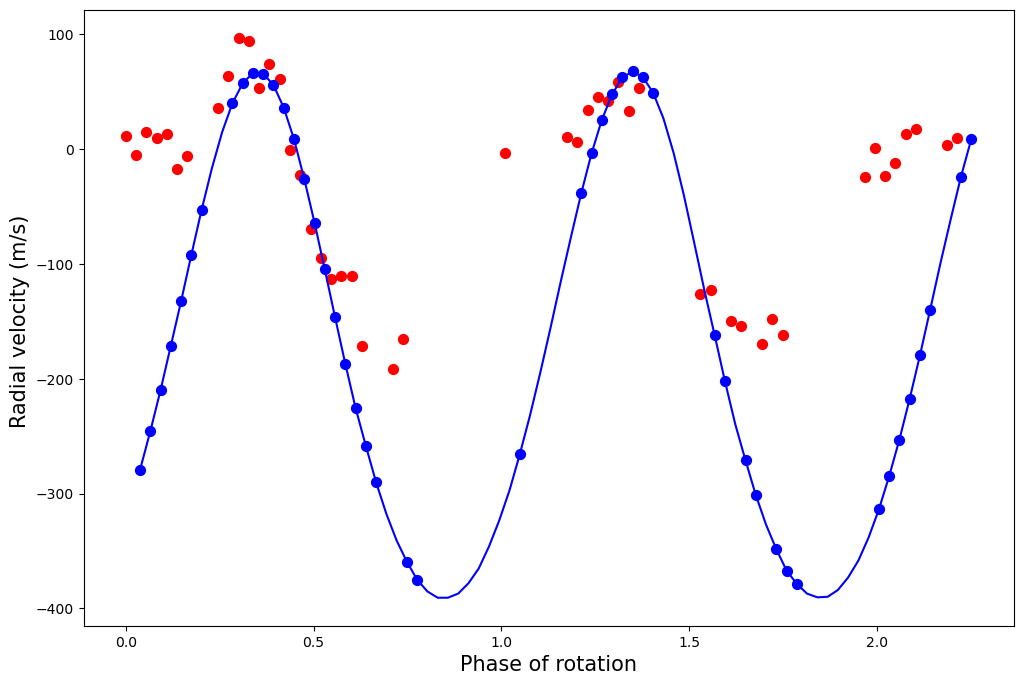

In [14]:
'''Importing the 2017 Thompson et al. paper data for Alpha Cen B to compare to the model data '''
model_data_curve = av_rv_full
model_data_points = av_rv_selective
import astropy.io.ascii as ascii 
from scipy.interpolate import make_interp_spline

data = ascii.read('alpha_cen_active_data.dat')
day = data['jdb']; alpha_cen_rv = data['RV']; alpha_cen_feature_rv = 1000*data['CCFpeak']; alpha_cen_sigma = data['Sigma']
phase_interval = []; phase_point_interval = []; phase_interval_curve = []
total_period = day[47]-day[0]
period_rot = 36.6 # Days of alpha cen b rotation period
total_rotations = total_period/period_rot
fraction_rot = total_rotations/48

ydata_curve = [];ydata_points = [];e=0
for i in range(82):
    phase_interval_curve.append((i/36.6)+0.038)             # Note: the '+ constant' values to the i (x_data) and model_data_curve (y_data)                                                               
    #a+=fraction_rot                                            -> These allow for manual tweaking of the model curve to best fit the actual data 
for j in range (82):
    ydata_curve.append((model_data_curve[j]+ 0.424)*1000)
    if j == int(day[e]-day[0]):
        phase_interval.append((j/36.6))
        ydata_points.append((model_data_points[e]+0.424)*1000)
        phase_point_interval.append(phase_interval_curve[j])
        e+=1

print(len(phase_point_interval),len(ydata_points),len(phase_interval),len(ydata_curve),len(alpha_cen_feature_rv))

'Final plot of the RV variation between model vs data'
plt.style.use('default')
plt.figure(figsize=(12,8))
plt.scatter(phase_interval,alpha_cen_feature_rv, s=50, c='r', marker='o' )
plt.scatter(phase_point_interval,ydata_points,s=50,c='b',marker='o')
plt.plot(phase_interval_curve,ydata_curve,'b-')
plt.xlabel('Phase of rotation', size = 15)
plt.ylabel('Radial velocity (m/s) ', size = 15)  
plt.savefig('RV measured vs modeled - current')


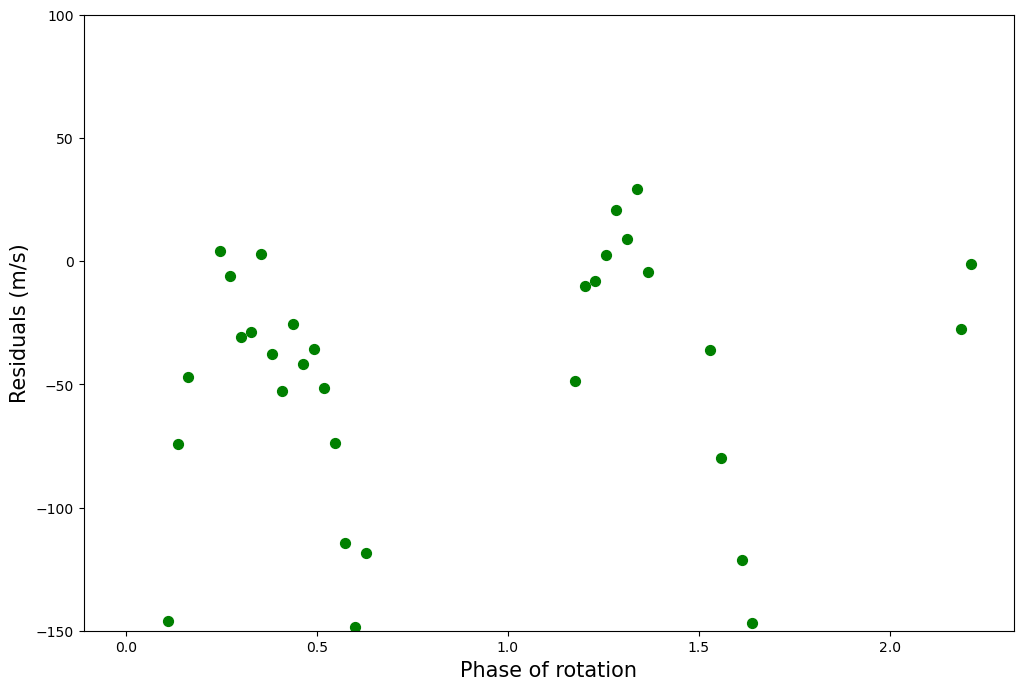

In [15]:
'''Calculation and plotting of residuals between data and model points'''

residuals = ydata_points - alpha_cen_feature_rv
plt.figure(figsize=(12,8))
plt.ylim(-150, 100)
plt.scatter(phase_interval,residuals, s=50, c='g', marker='o' )
plt.xlabel('Phase of rotation', size = 15)
plt.ylabel('Residuals (m/s)', size = 15)  
plt.savefig('RV measured vs modeled - residuals - 2.5% area - 68% lat - 200K difference.png')